# This project comes from a competition on Kaggle. 
# The goal is to predict sales for the 15 days after the last date in the training data for the thousands of product families sold at Favorita stores located in Ecuador.
# The data shared by the host are training data, testing data, and other complementary meta data such as the store information, the oil price information, and the holiday events information, and special events like wage paying and earthquake information.



#### There are a lot of time series forecasting techniques. Generally, the techniques can be divided into two categories, i.e. Classical statistical methods and machine learning methods. Based on the researches listed below:
* The M3-Competition: Results, Conclusions and Implications, 2000.
* The M4 Competition: Results, findings, conclusion and way forward, 2018.
* Statistical and Machine Learning forecasting methods: Concerns and ways forward, 2018.
* An Empirical Comparison of Machine Learning Models for Time Series Forecasting, 2010.

The results of this study suggest that:
* Classical methods like ETS and ARIMA out-perform machine learning and deep learning methods for one-step  
  forecasting on univariate datasets.
* Classical methods like Theta and ARIMA out-perform machine learning and deep learning methods for multi-step 
  forecasting on univariate datasets.
* Machine learning and deep learning methods do not yet deliver on their promise for univariate time series 
  forecasting, and there is much work to do.

Hence, this project will focus on exploring classicial statistical methods.

#### Why choose ARIMA model?
The classicial statistical techniques for time series forecasting:
1. Autoregression (AR)
2. Moving Average (MA)
3. Autoregressive Moving Average (ARMA)
4. Autoregressive Integrated Moving Average (ARIMA)
5. Seasonal Autoregressive Integrated Moving-Average (SARIMA)
6. Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
7. Vector Autoregression (VAR)
8. Vector Autoregression Moving-Average (VARMA)
9. Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
10. Simple Exponential Smoothing (SES)
11. Holt Winter’s Exponential Smoothing (HWES)

To use these techniques, basically there is an assumption about the property of the time series, the time series should be stationary, which means the mean and variance of the time series aren't changing over time. Also, When we apply these techniques, we are rquired to provide non-seasonal auto-regression model parameter (p), non-seasonal moving average parameter(q), sometimes seasonal auto-regressiona parameter(P) and seasonal moving average parameter(Q), and seasonal pattern (S).
Normally, we plot ACF and PACF to determine those parameters. However, this is not realistic for thousands families.

The lucky thing is there is an algorithm with Python called pmdarima which search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

#### To speed up the computation of thousand families, we will apply data preprocessing techniques before we use pmdarima. 
Here are preprocessing techniques being applied:

* delete those time series with the number of data points less than 16 (refering to this paper: MINIMUM SAMPLE SIZE   REQUIREMENTS BY Rob J. Hyndman and Andrey V. Kostenko)
* test stationary for each time series using Augmented Dickey-Fuller test
* Apply differencing techniques to non-stationary time series to detrend the data and desensonalize the data
* Acquire the "d"s and "D"s for the non-stationary time series

#### For this kaggle competition, the host doesn't provide actual sales data for test data. The model performance or your score in the competition is provided after submitting your forecasting data for those time period in testing data via Kaggle website. For this project, to test our model performance, the "train.csv" provided by host is going to be split into two part: training data and testing data. We use training data to build our model and test our model performance on testing data.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from random import seed
import random

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [131]:
train = pd.read_csv('/Users/liyu/Downloads/store-sales-time-series-forecasting/train.csv',parse_dates = ['date'])
test = pd.read_csv('/Users/liyu/Downloads/store-sales-time-series-forecasting/test.csv',parse_dates = ['date'])

In [132]:
print(train.shape, test.shape)

(3000888, 6) (28512, 5)


In [133]:
# store_nbr identifies the store at which the products are sold
# family identifies the type of product sold.
# sales gives the total sales for a product family at a particular store at a given date. 
# Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, 
# for instance, as opposed to 1 bag of chips).
# onpromotion gives the total number of items in a product family that were being promoted 
# at a store at a given date.

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [134]:
# It shows that the test data provided by the host does not include actual sales data.
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [25]:
# what is the earliest date and the last date in training data
print(train.date.min(), train.date.max())

2013-01-01 00:00:00 2017-08-15 00:00:00


In [12]:
# How many stores in Ecuador? 54 
train.store_nbr.nunique()

54

In [16]:
# how many unique families? 33
# We are going to predict total 1782 time series
print(train.family.unique(), train.family.nunique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 33


In [33]:
# We are going to check the frquency of the family items being sold.
# there are no missing dates for any families.
# Each single time series has 1684 data points
train.groupby(['store_nbr','family']).count().id.unique()

array([1684])

## Data Preprocessing

In [45]:
# It is noticed that some families's sales data at some stores are filled with 0.0.
# We will remove such kind of data to speed computation before going to next step.
train.loc[(train['family']=='BABY CARE') &(train['store_nbr']==1)].sort_index()

id  store_nbr     family  sales  onpromotion
date                                                         
2013-01-01        1          1  BABY CARE    0.0            0
2013-01-02     1783          1  BABY CARE    0.0            0
2013-01-03     3565          1  BABY CARE    0.0            0
2013-01-04     5347          1  BABY CARE    0.0            0
2013-01-05     7129          1  BABY CARE    0.0            0
...             ...        ...        ...    ...          ...
2017-08-11  2991979          1  BABY CARE    0.0            0
2017-08-12  2993761          1  BABY CARE    0.0            0
2017-08-13  2995543          1  BABY CARE    0.0            0
2017-08-14  2997325          1  BABY CARE    0.0            0
2017-08-15  2999107          1  BABY CARE    0.0            0

[1684 rows x 5 columns]

In [46]:
train.loc[(train['family']=='BABY CARE') &(train['store_nbr']==1)].sales.unique()

array([0.])

##### Delete time series without sales equaling to 0

In [136]:
# Remove families without sales at stores.
families = train['family'].unique()
stores = train['store_nbr'].unique()
no_sales_index = []
for family, store in list(itertools.product(families, stores)):
    temp = train.loc[(train['family']==family) & (train['store_nbr']==store)]
    N = len(temp)
    M = len(temp.loc[temp['sales']==0.0])
    if M/N == 1:
        index_drop = train.loc[(train['family']==family) & (train['store_nbr']==store)].index
        no_sales_index.append(index_drop)

In [137]:
train = train.drop(list(itertools.chain(*no_sales_index)))

In [138]:
# We can see the data's size is smaller than before.
train.shape

(2911636, 6)

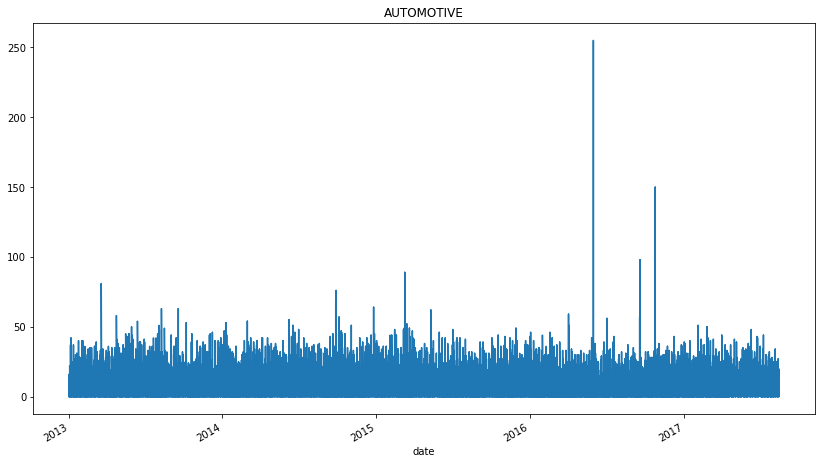

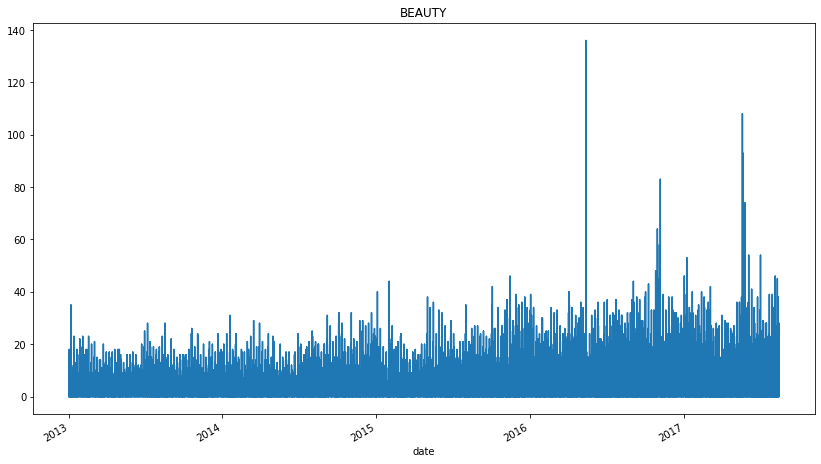

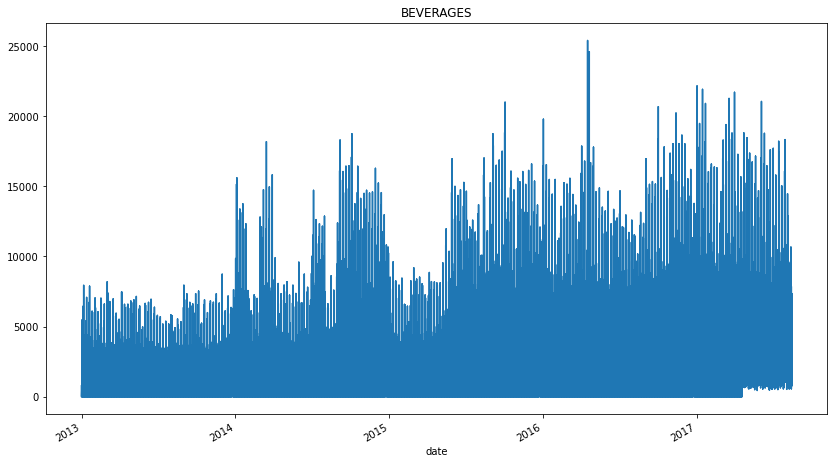

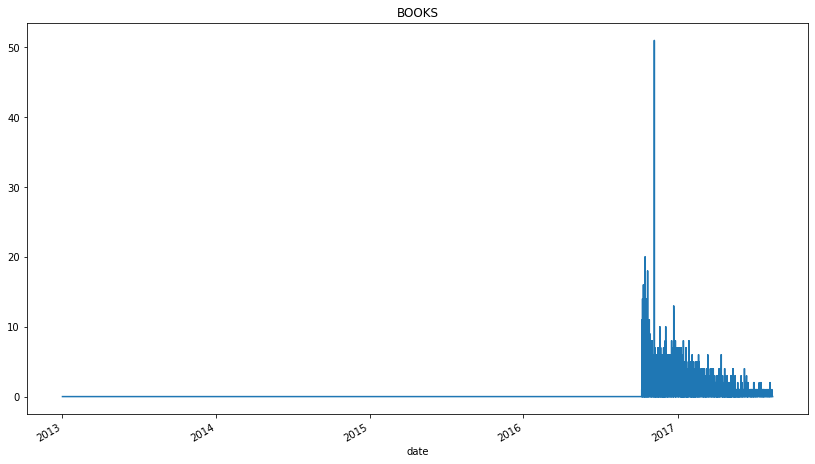

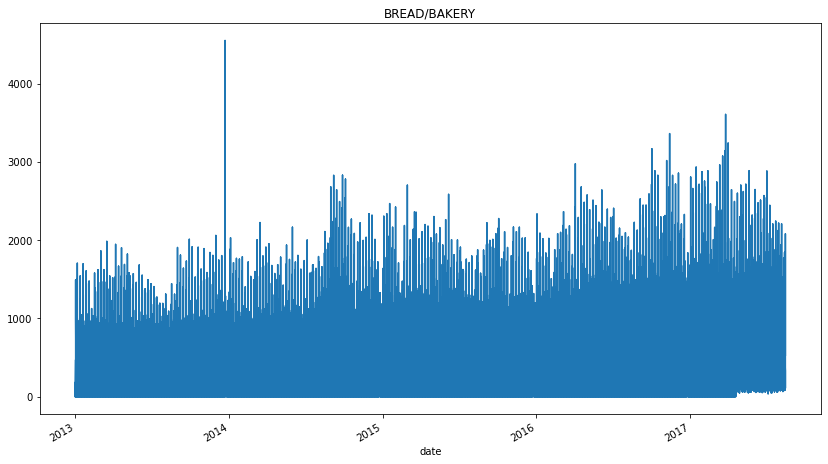

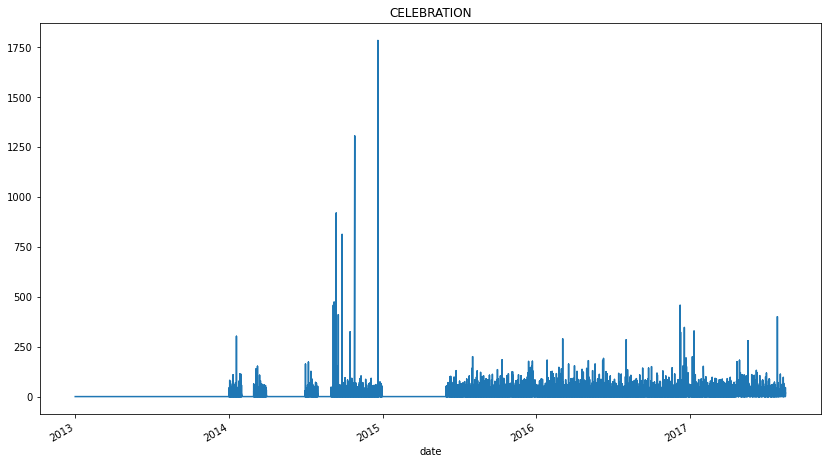

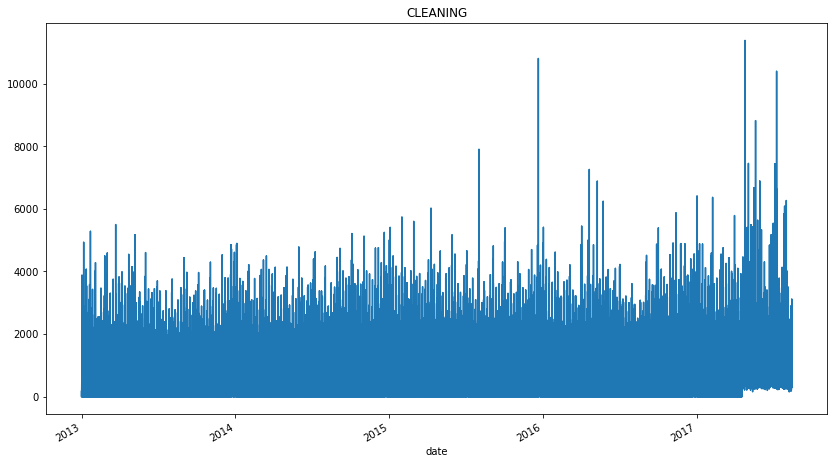

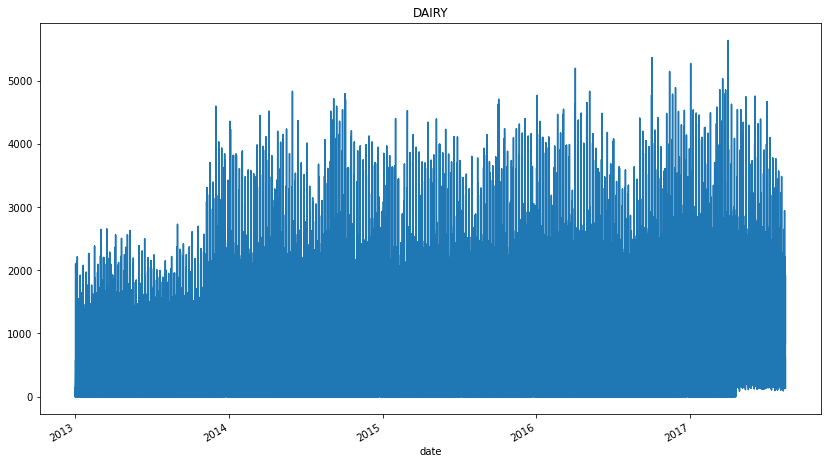

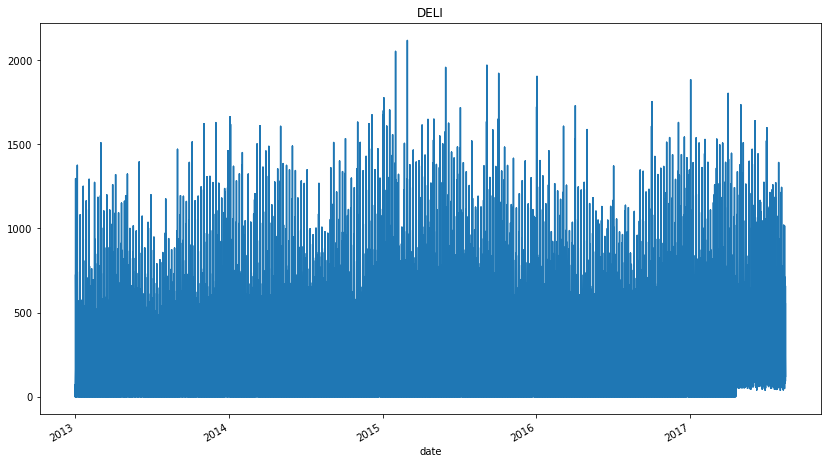

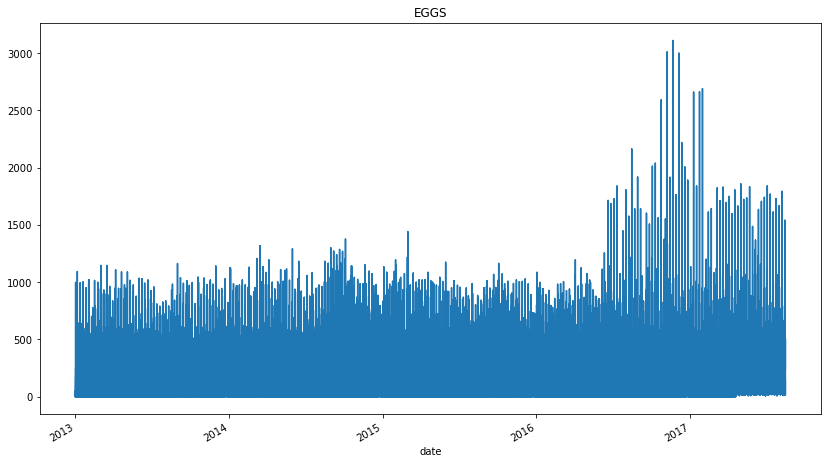

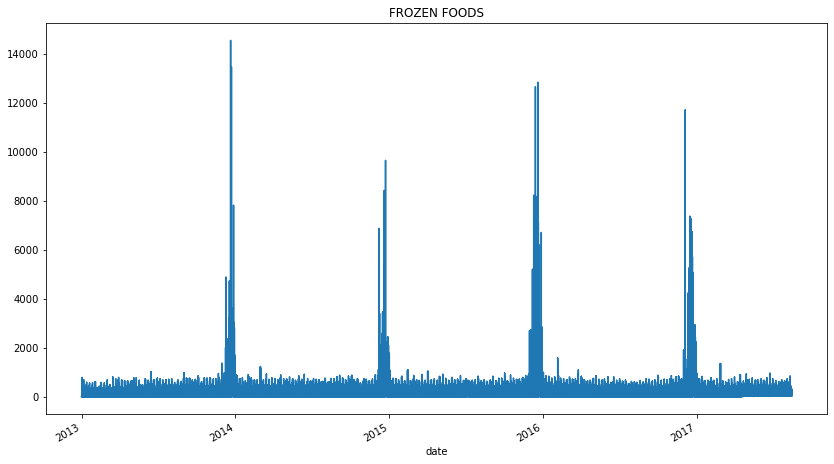

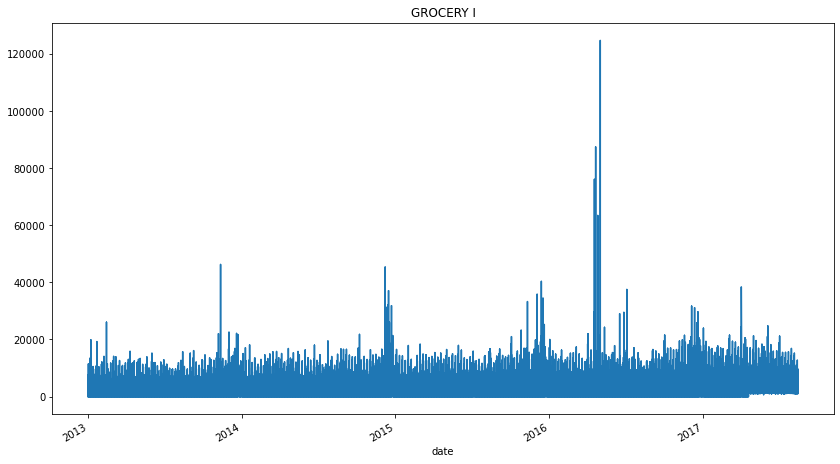

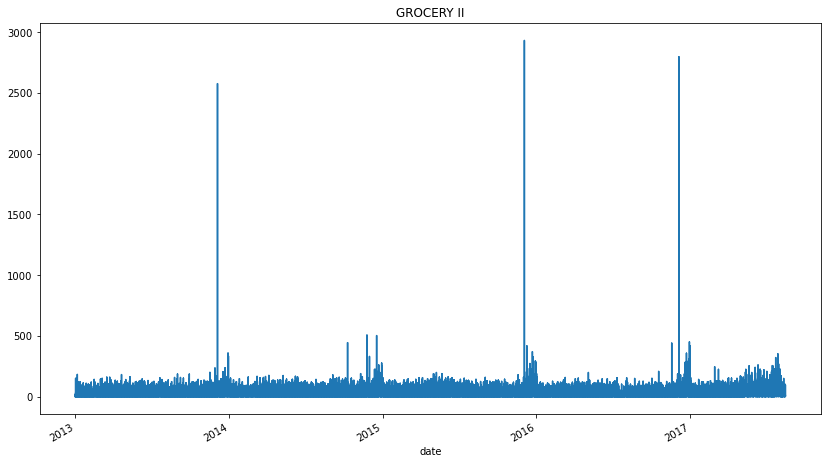

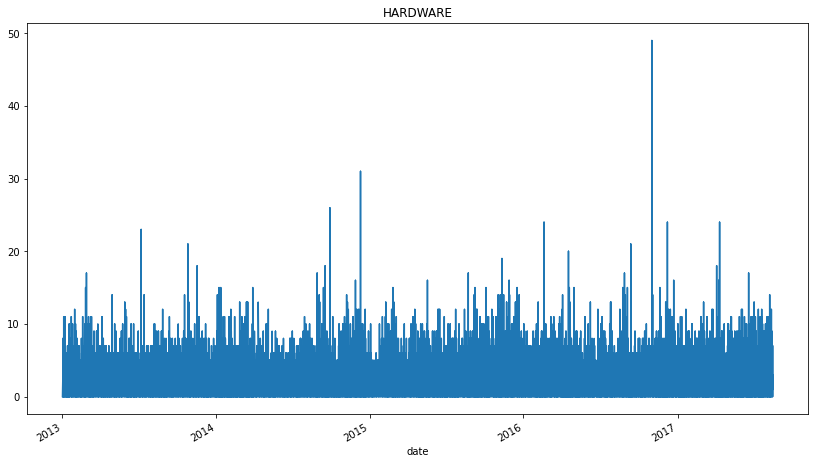

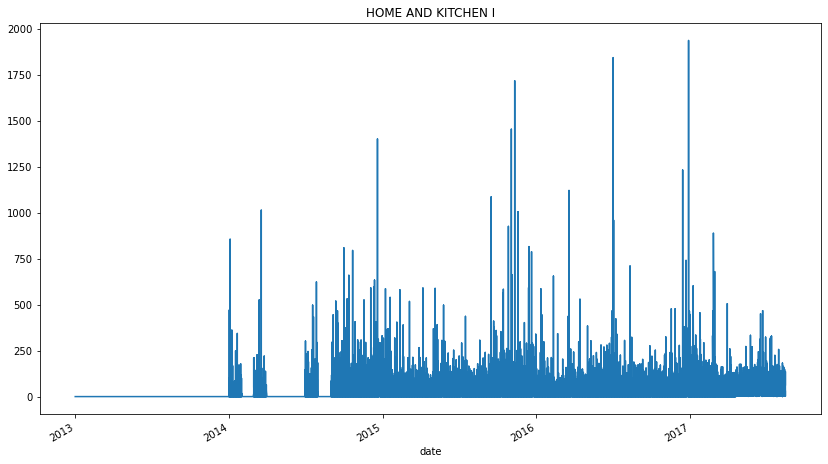

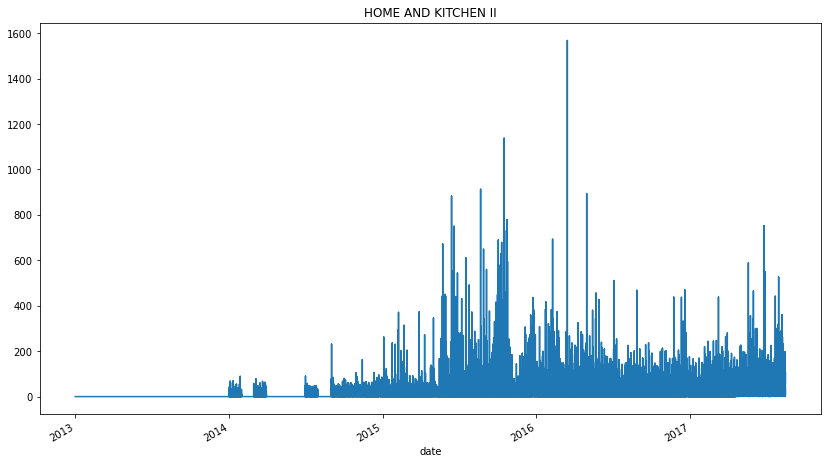

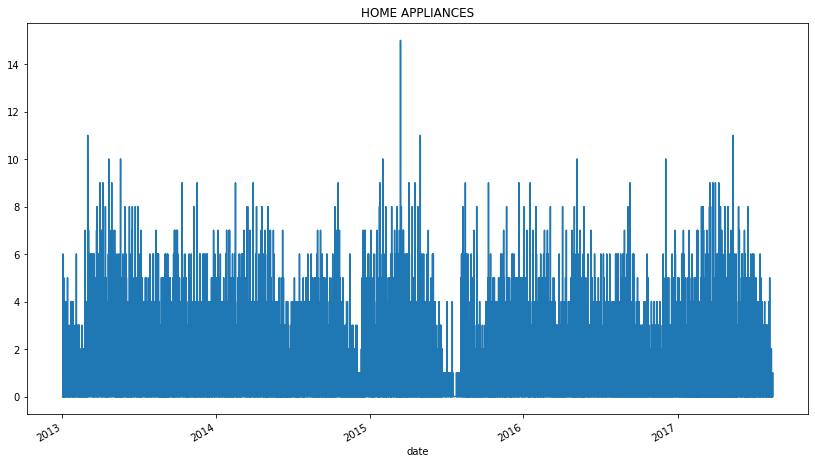

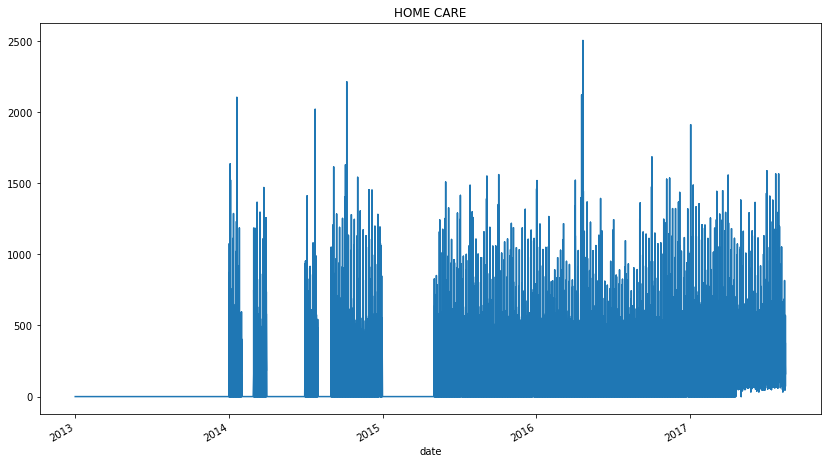

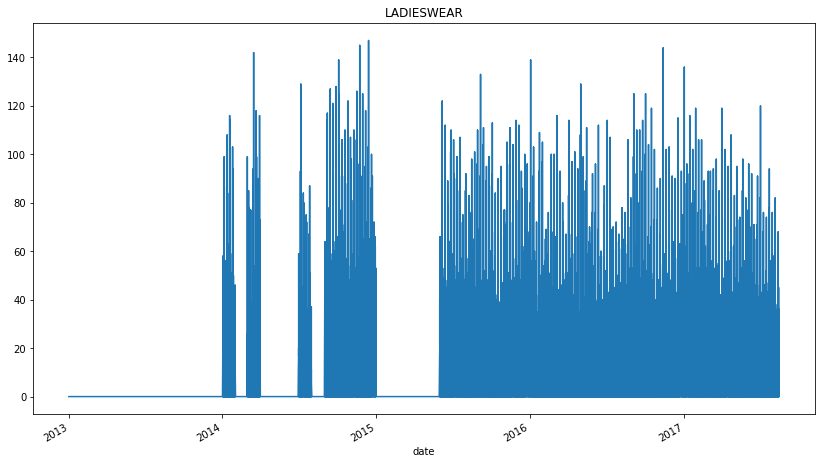

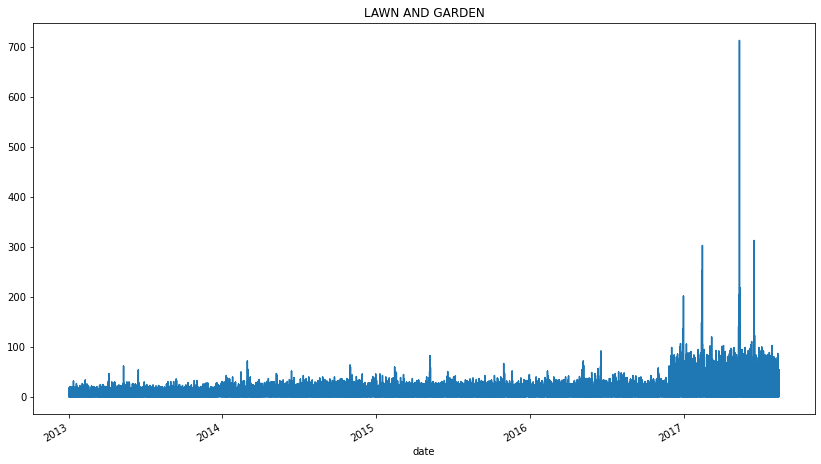

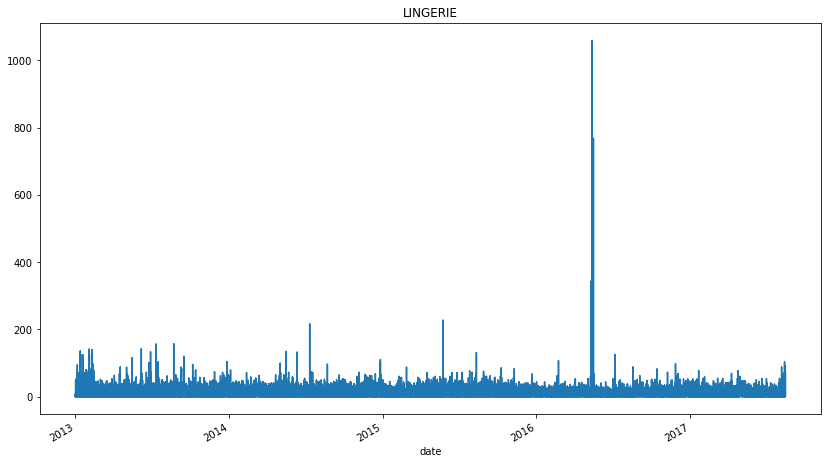

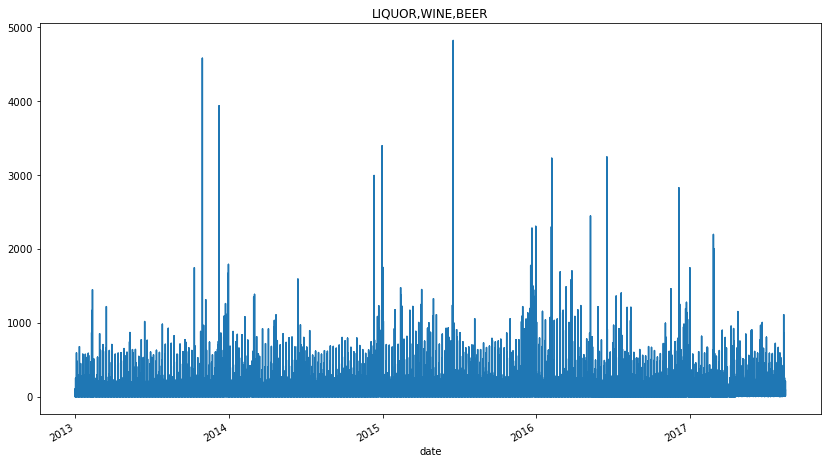

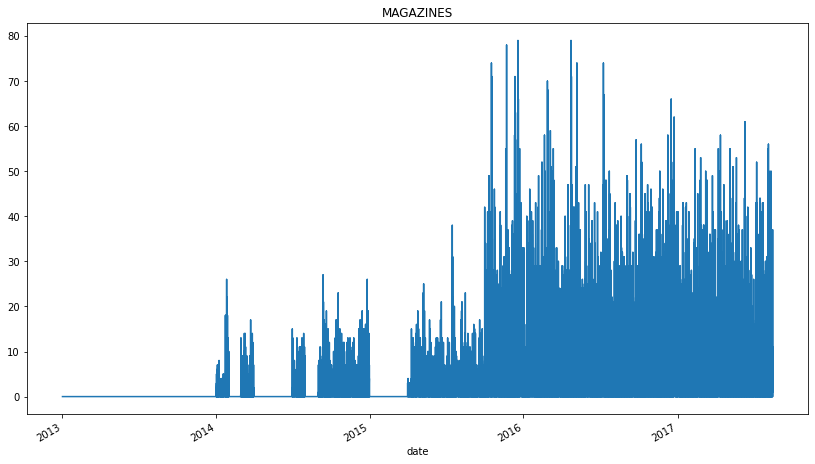

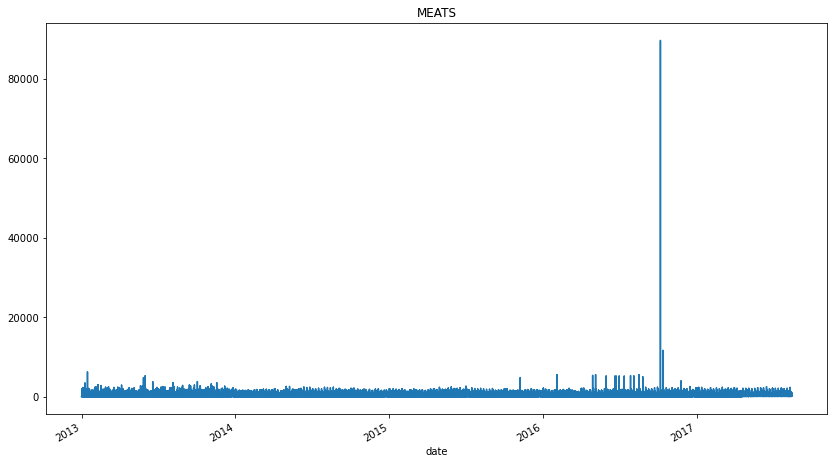

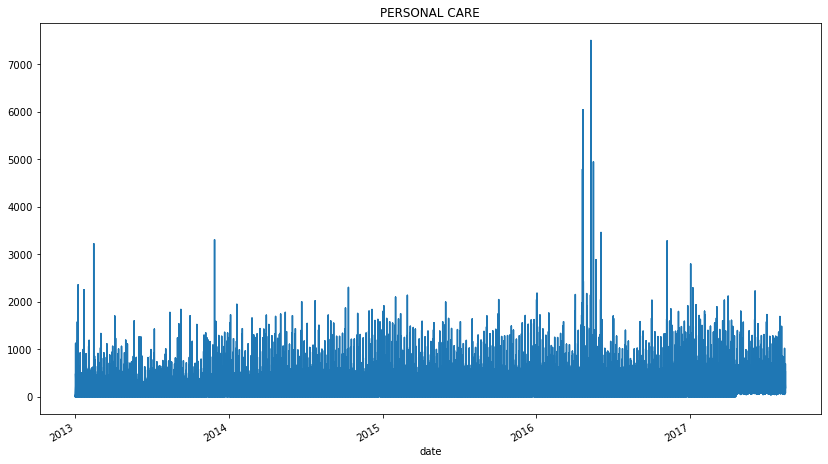

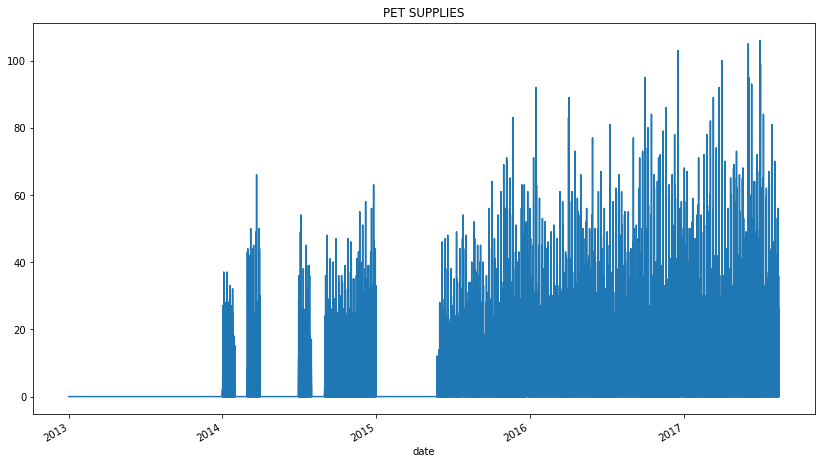

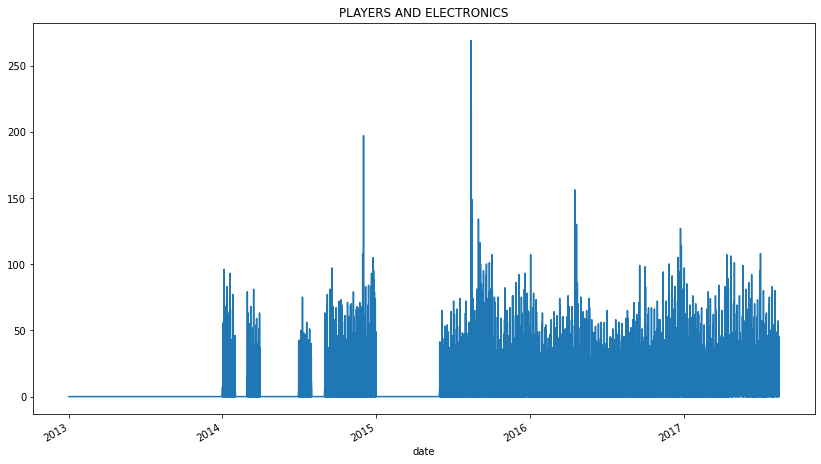

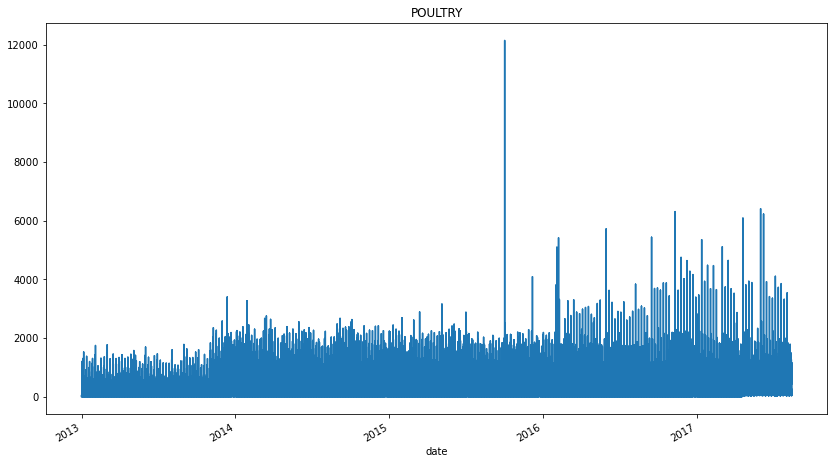

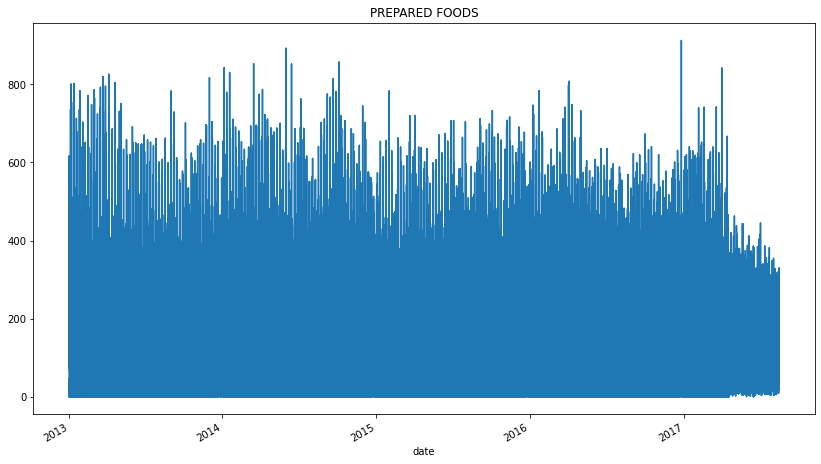

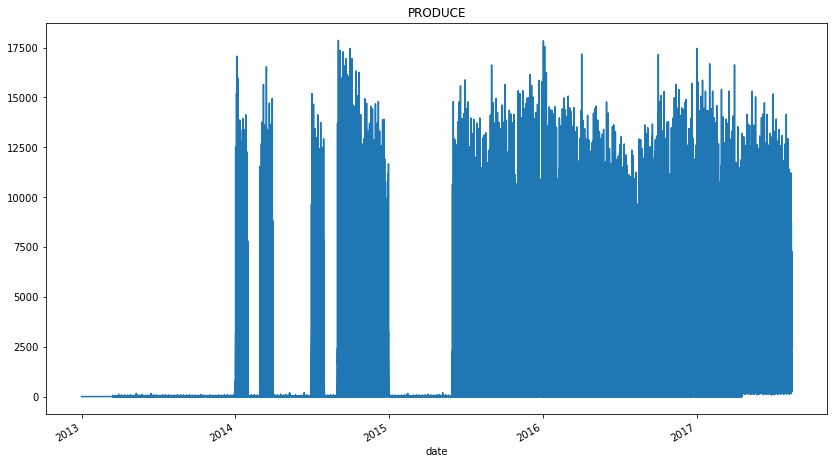

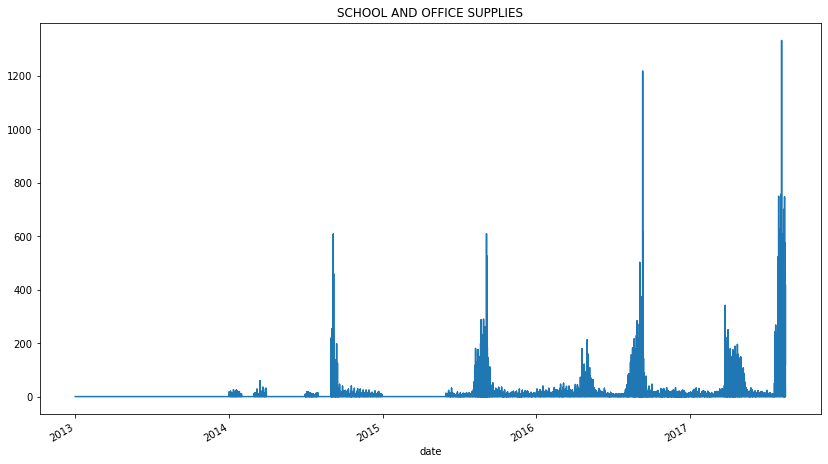

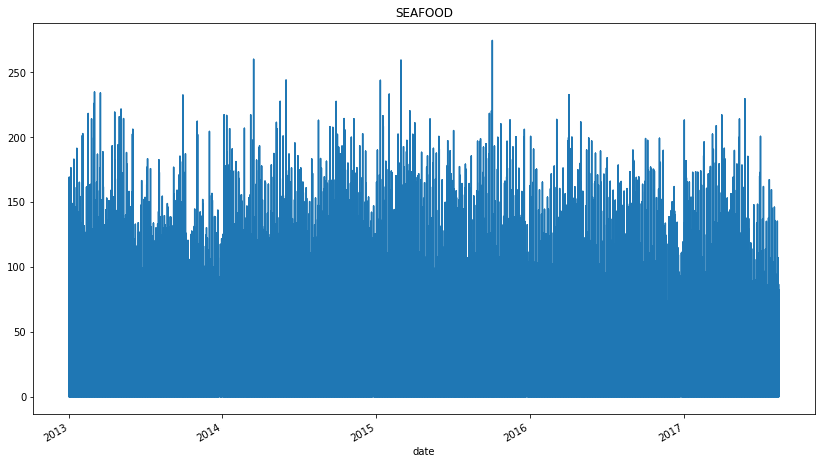

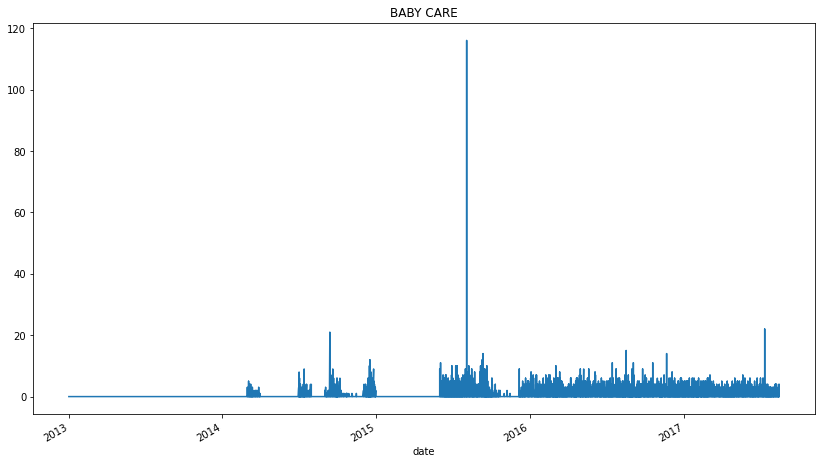

In [139]:
# There are total 33 families. By plotting their sales vs time, we can have a general idea how the sales changes by time
# The chart tells us that some products are sold continuously starting from 2013. However, some products are sold just 
# starting from recent year, such as 2016. Some products were sold intermittently at earlier years.
train.index=train.date
for family in train.family.unique():
    series = train['sales'].loc[train['family']==family]
    series.plot(figsize=(14,8), legend=None, title=family)
    plt.show()

##### Delete time series with the number of data points less than 16

In [140]:
train.reset_index(drop=True,inplace=True)
train.head()

id       date  store_nbr        family  sales  onpromotion
0   0 2013-01-01          1    AUTOMOTIVE    0.0            0
1   2 2013-01-01          1        BEAUTY    0.0            0
2   3 2013-01-01          1     BEVERAGES    0.0            0
3   4 2013-01-01          1         BOOKS    0.0            0
4   5 2013-01-01          1  BREAD/BAKERY    0.0            0

In [141]:
combination = train[['store_nbr','family']].drop_duplicates()
for i in range(len(combination)):
    store_number = combination['store_nbr'][i]
    family_name = combination['family'][i]
    temp = train.loc[(train['store_nbr']==store_number) & (train['family']==family_name)]
    sales_data = temp.sales.values
    non_zero_cnt = np.count_nonzero(sales_data, axis=0)
    if non_zero_cnt <= 16:
        train=train.loc[~((train['store_nbr']==store_number) & (train['family']==family_name))]

In [147]:
train.shape

(2884692, 6)

In [148]:
print(combination.shape, combination_update.shape)

(1729, 2) (1713, 3)


#####  Stationary test using Augmented Dickey-Fuller test

In [7]:
combination_update = train[['store_nbr','family']].drop_duplicates().reset_index()
non_stationary_list = []
for i in range(len(combination_update)):
    temp_store = combination_update['store_nbr'][i]
    temp_family = combination_update['family'][i]
    temp = train.loc[(train['store_nbr']==temp_store) & (train['family']==temp_family)]
    X = temp['sales'].values
    result = adfuller(X)
    P = result[1]
    if P> 0.05:
        non_stationary_list.append(i)

In [8]:
print("There are %d non-stationary time series" % (len(non_stationary_list)))

There are 478 non-stationary time series


##### Apply differencing method to detrend, desensonalized the data

In [9]:
non_stationary_lst_diff = []
for lst in non_stationary_list:
    non_stationary_store = combination_update.iloc[lst,1:3].store_nbr
    non_stationary_family = combination_update.iloc[lst,1:3].family
    temp = train.loc[(train['store_nbr']==non_stationary_store) & (train['family']==non_stationary_family)]
    temp = temp[['date','sales']]
    temp.index=temp.date
    temp.drop('date',axis=1,inplace=True)
    diffdvds=diff(temp, k_diff=1, k_seasonal_diff=False)
    result = adfuller(diffdvds)
    P = result[1]
    if P> 0.05:
        non_stationary_lst_diff.append(lst) 

In [10]:
# It shows that after applying first order differencing, all of non-stationary time series turn into stationary.
print("There are %d non-stationary time series after applying first order differencing" % (len(non_stationary_lst_diff)))

There are 0 non-stationary time series after applying first order differencing


#### Train Test Split
* Will use the last 15 data points as testing data

In [25]:
# Sort the time series by store_nbr, family and order by date
train.sort_values(by=['store_nbr','family','date'], ascending=True, inplace=True)

In [31]:
# Split train/test one by one for each store_nbr & family combination
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for i in range(len(combination_update)):
    temp_store = combination_update['store_nbr'][i]
    temp_family = combination_update['family'][i]
    temp_data = train.loc[(train['store_nbr']==temp_store) & (train['family']==temp_family)]
    temp_train = temp_data[:1669]
    temp_test = temp_data[-15:]
    train_df = pd.concat([temp_train, train_df],ignore_index=True)
    test_df = pd.concat([temp_test, test_df],ignore_index=True)

In [32]:
print(train_df.shape, test_df.shape)

(2858997, 6) (25695, 6)


#### Build Auto ARIMA Forecasting Model
* From differencing process, we derived that d = 1 for those non-stationary time series
* The task of Auto ARIMA model focus on estimate p, q, which speed up the computation
* In our data, we need to do 1713 time series forecasting. Due to the limitation of the local machine, we will
  pick 100 random families to showcase the forecasting process. However, the work in this project can be scalable 
  to thousands of families if computation ability allows.

In [40]:
# Generate 100 index number to pick 100 family and store combinations
seed(1)
values = random.sample(range(1713), 100)
print(values)

[275, 1165, 1643, 1564, 129, 522, 241, 1014, 1558, 920, 967, 1334, 777, 1615, 429, 192, 999, 58, 1711, 798, 886, 1244, 1561, 1571, 4, 1425, 912, 545, 1477, 1642, 468, 1210, 209, 650, 62, 45, 52, 1330, 1108, 18, 780, 1405, 443, 864, 1486, 59, 1080, 454, 896, 1015, 1132, 477, 707, 472, 1386, 448, 941, 593, 44, 852, 1139, 1315, 204, 380, 1288, 1482, 607, 247, 1521, 681, 1456, 1025, 1039, 1699, 1372, 388, 621, 581, 1203, 1022, 1034, 805, 1206, 70, 983, 497, 1523, 1633, 827, 848, 1361, 354, 751, 1123, 1439, 1588, 1381, 1511, 767, 177]


In [41]:
# There are no duplicates in 100 random integers
len(set(values))

100

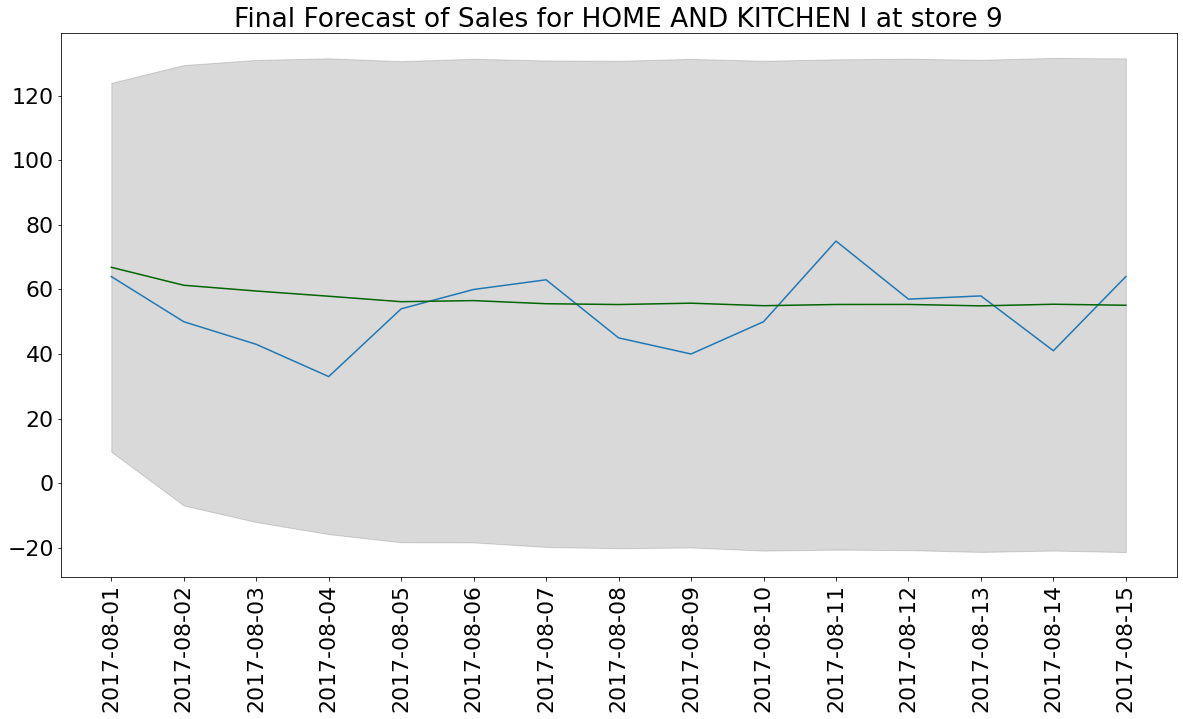

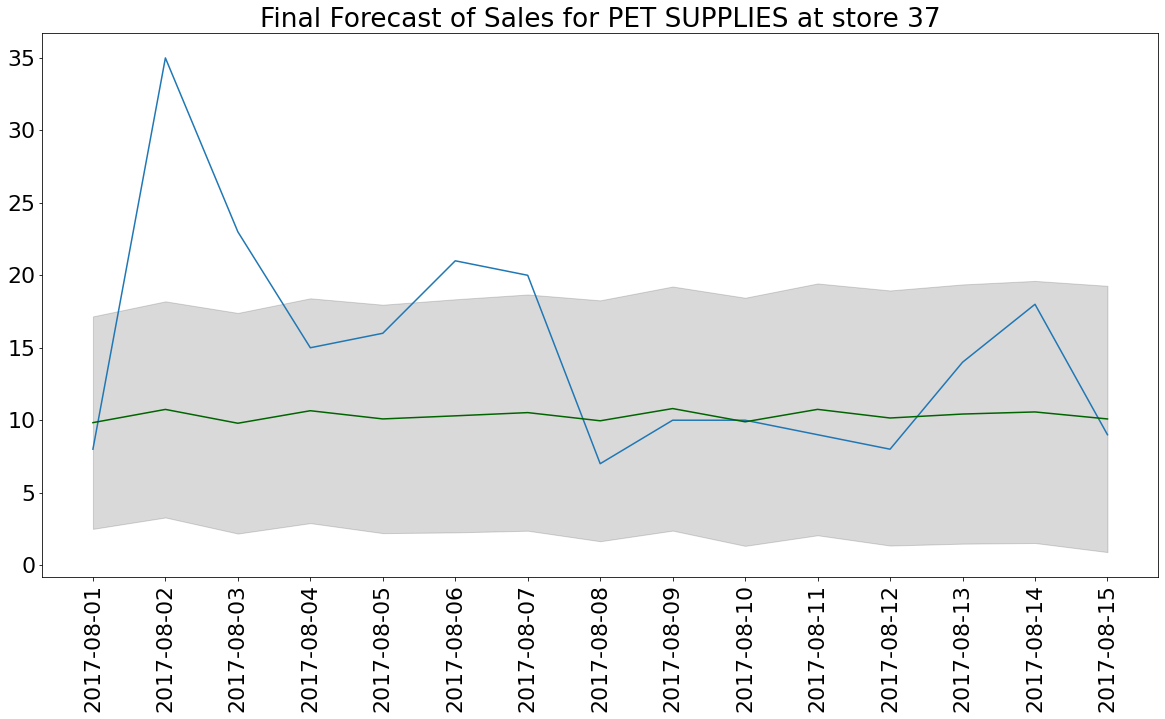

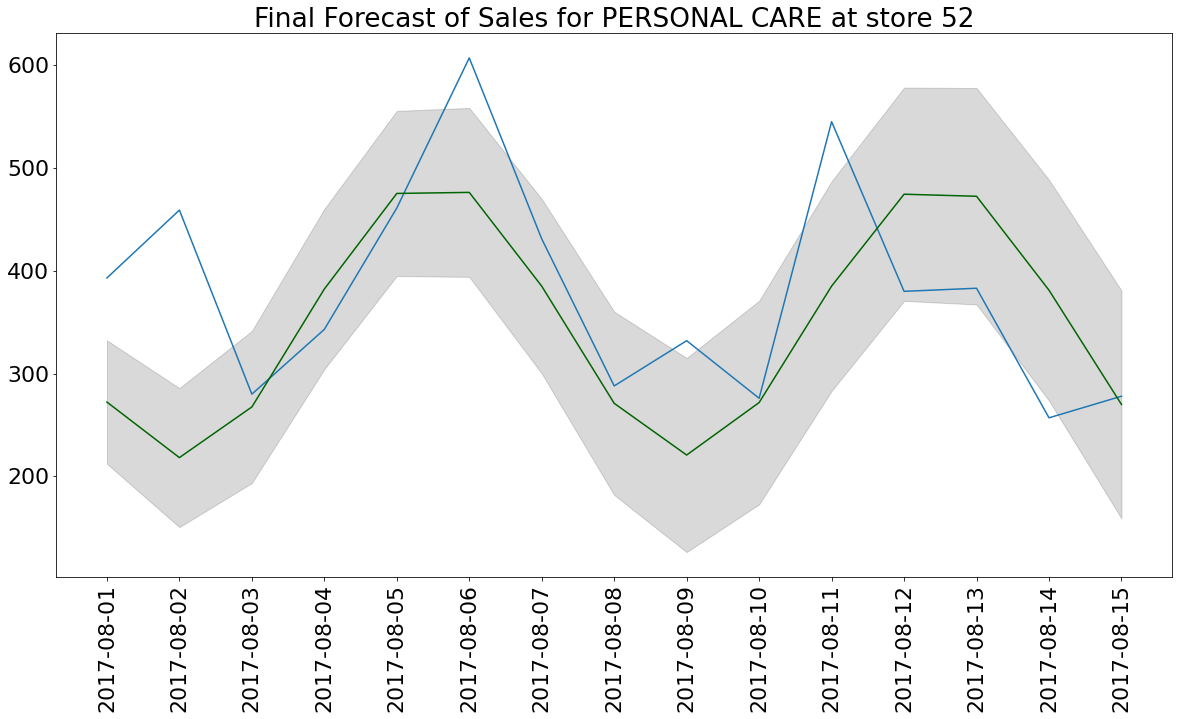

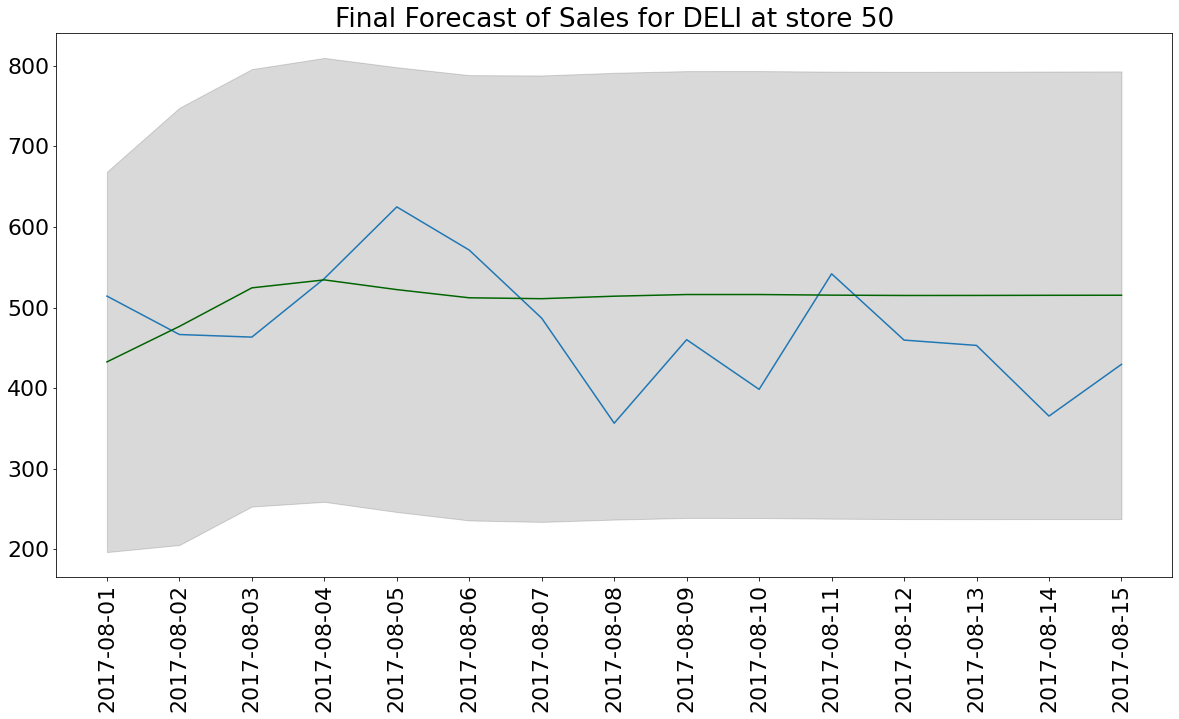

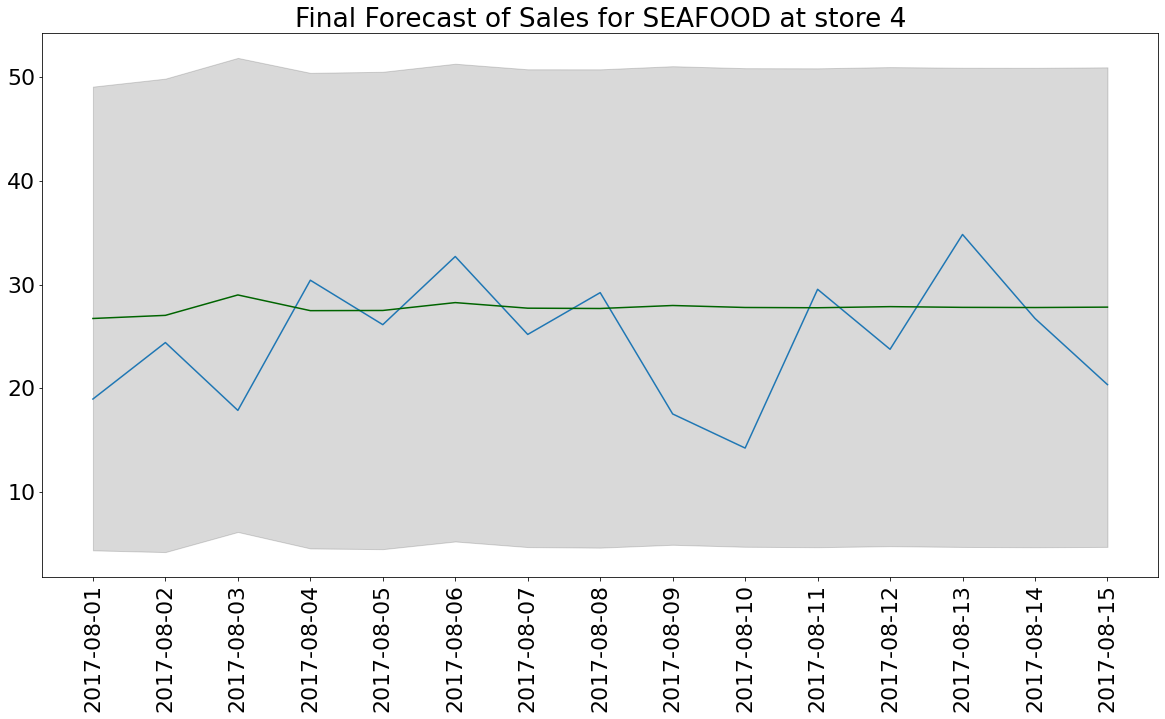

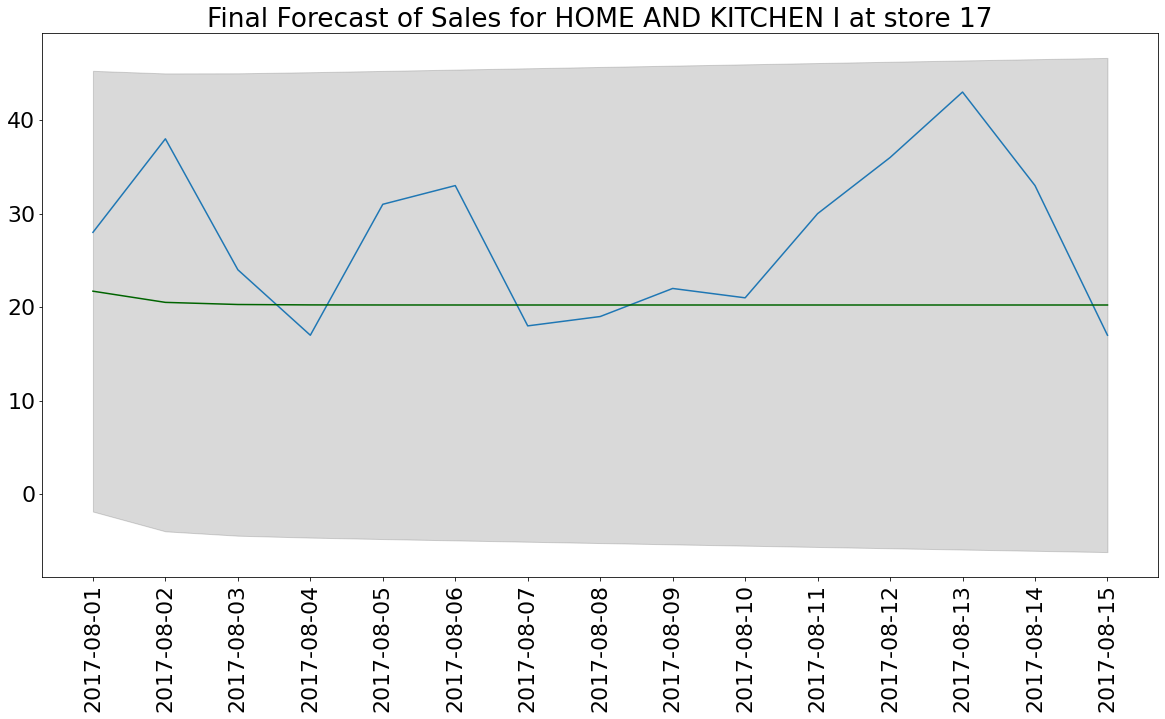

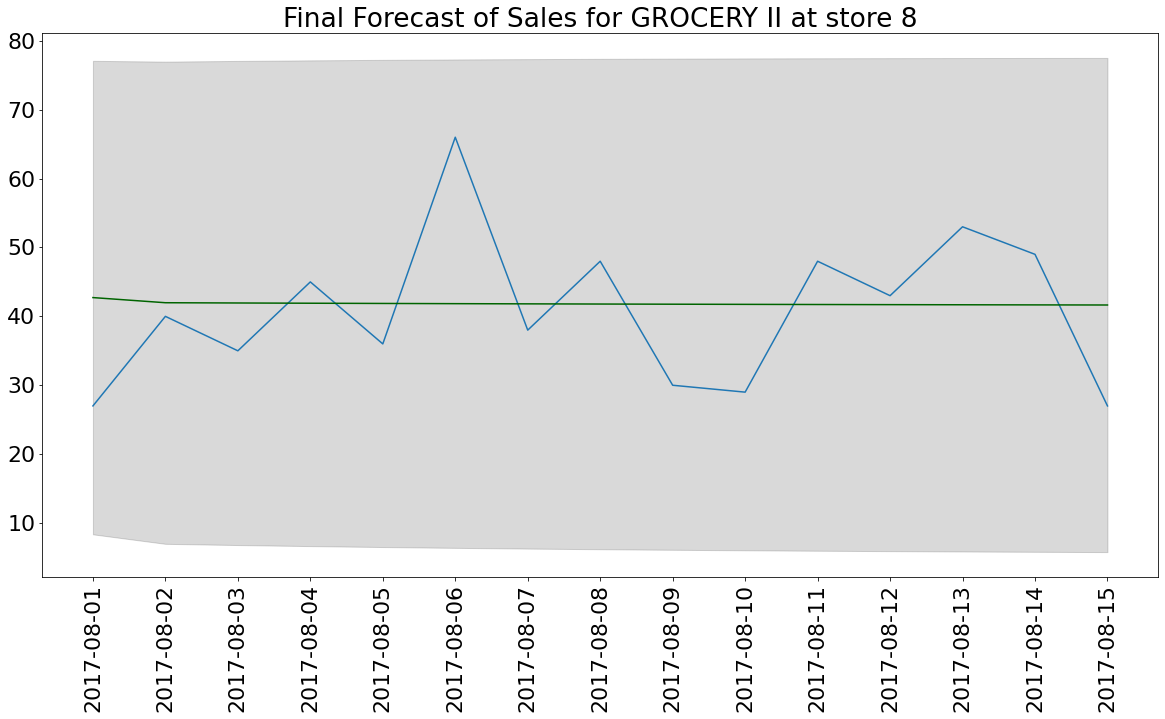

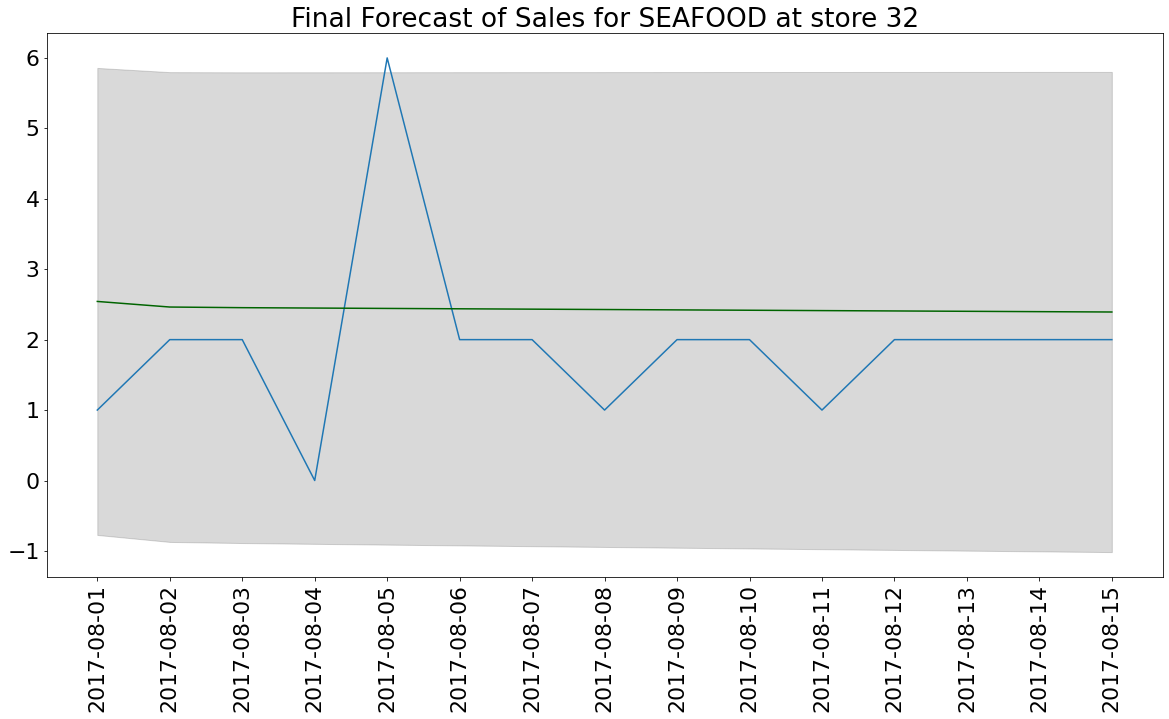

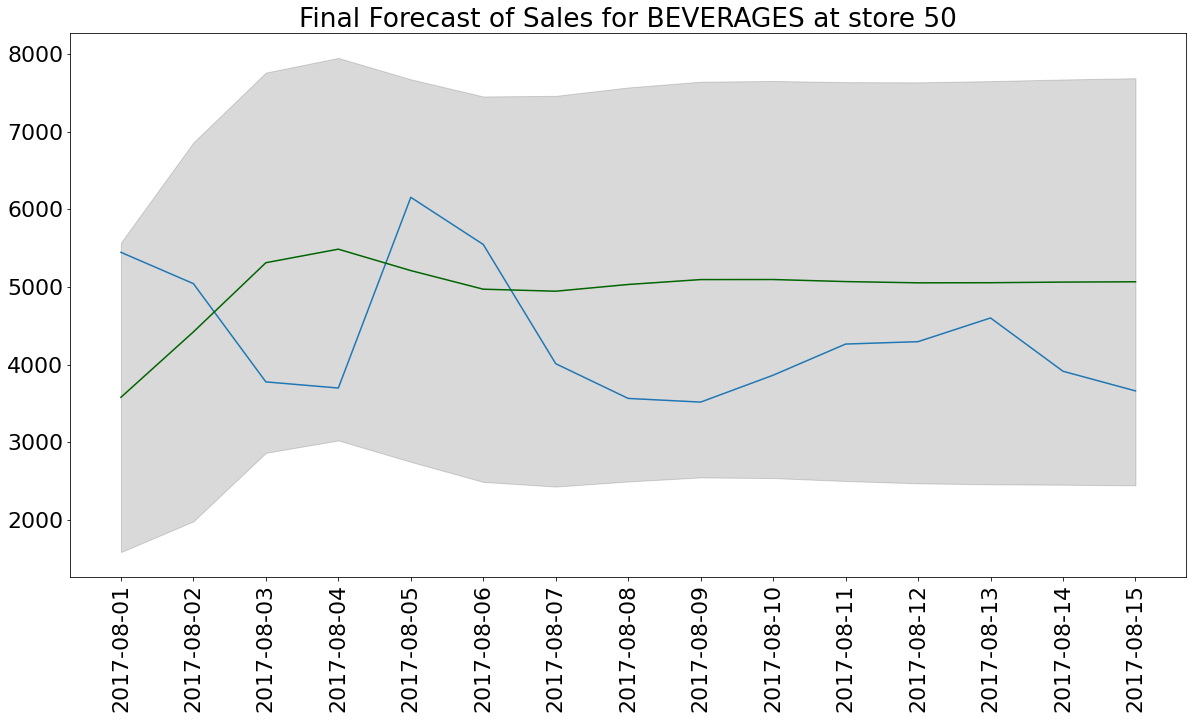

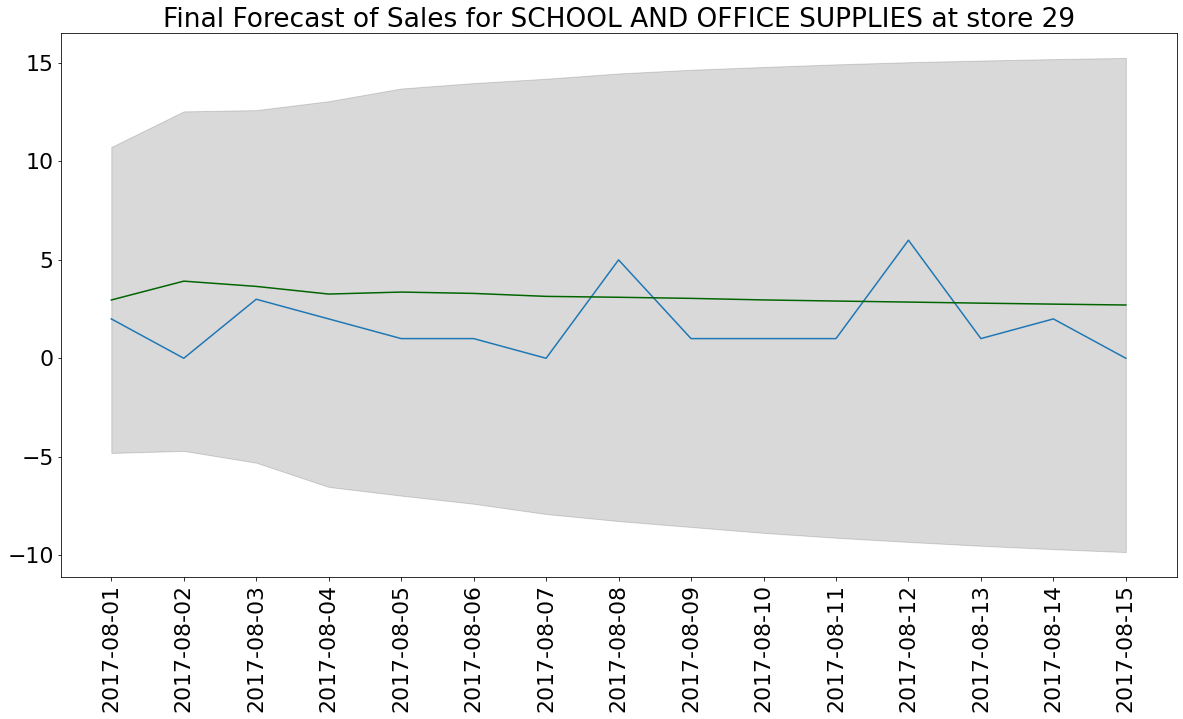

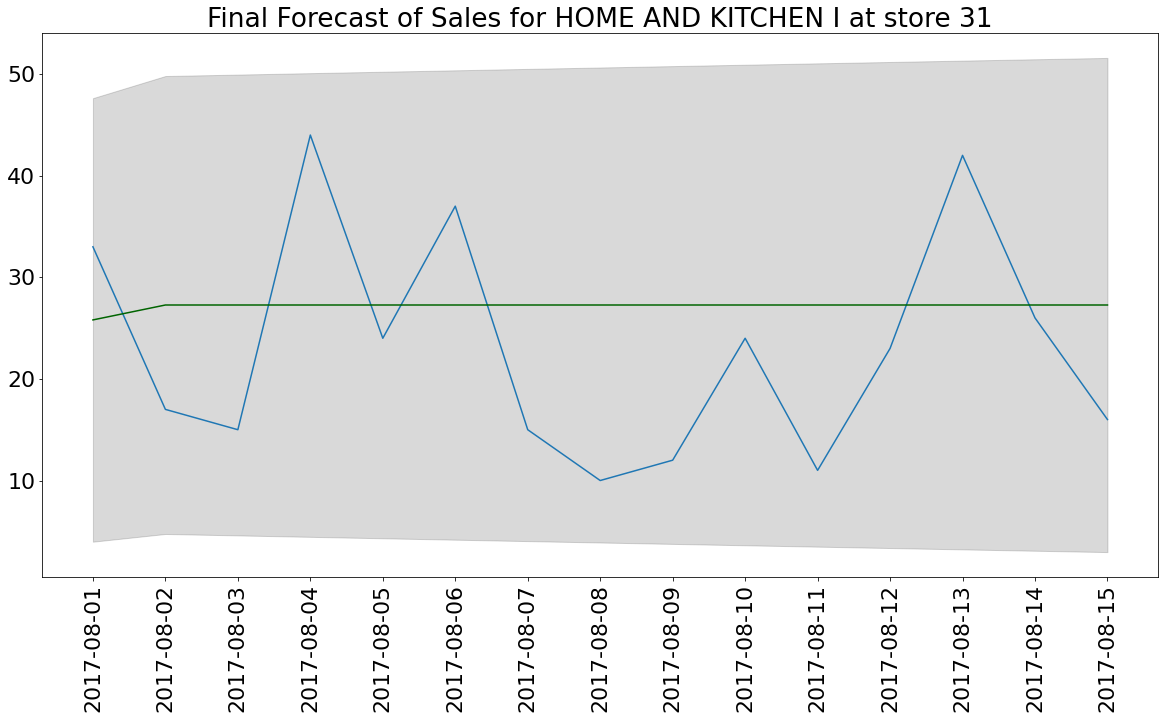

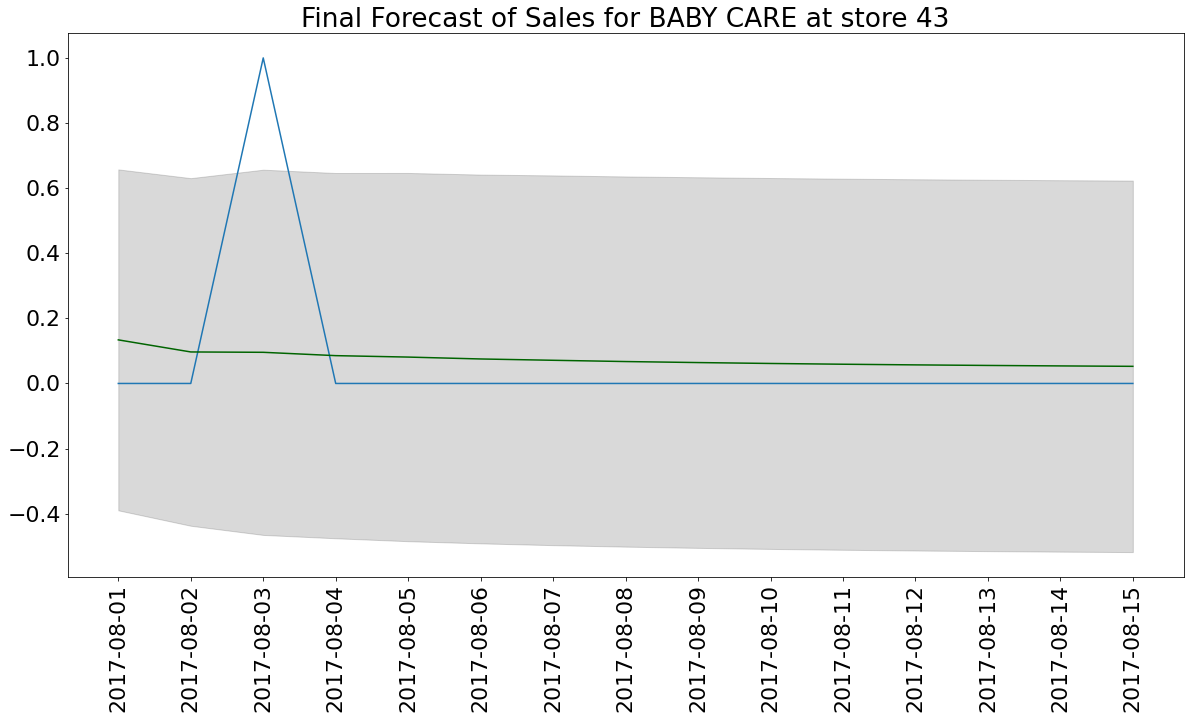

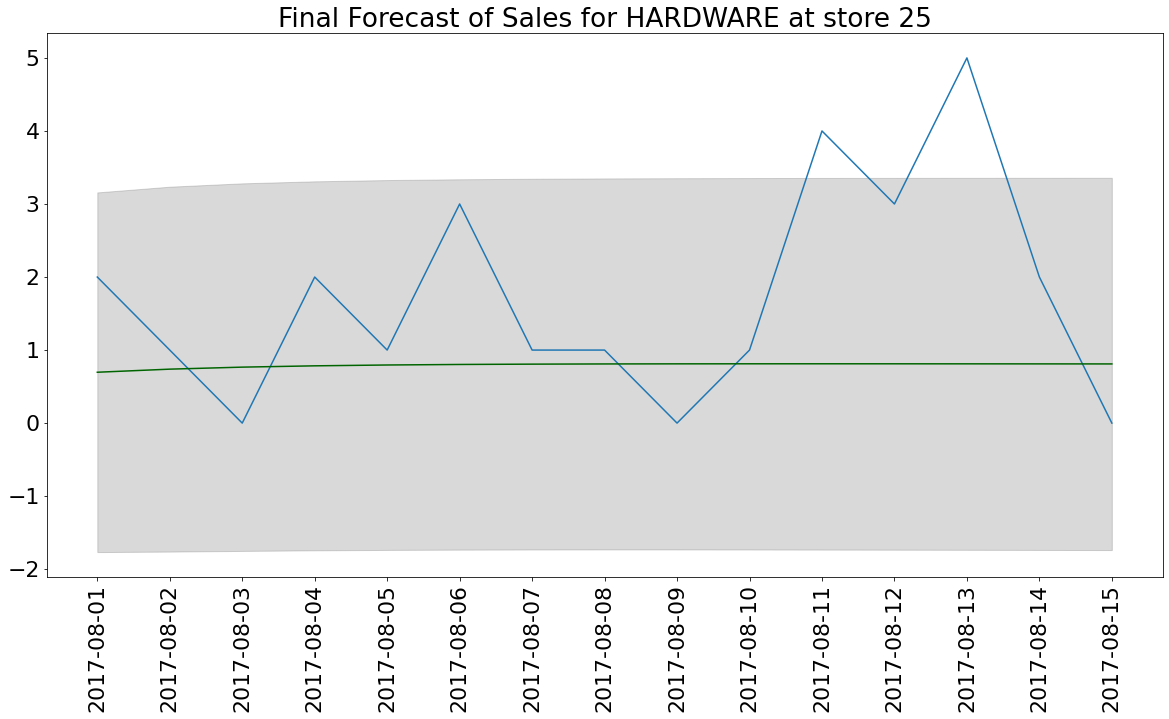

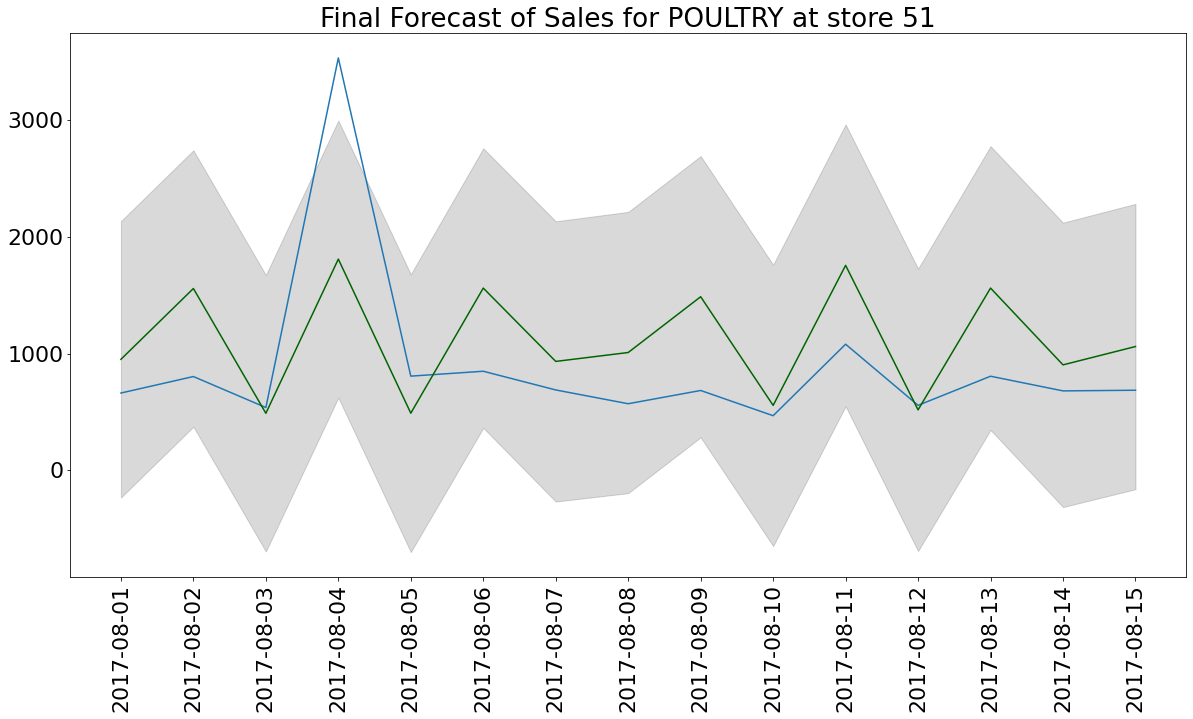

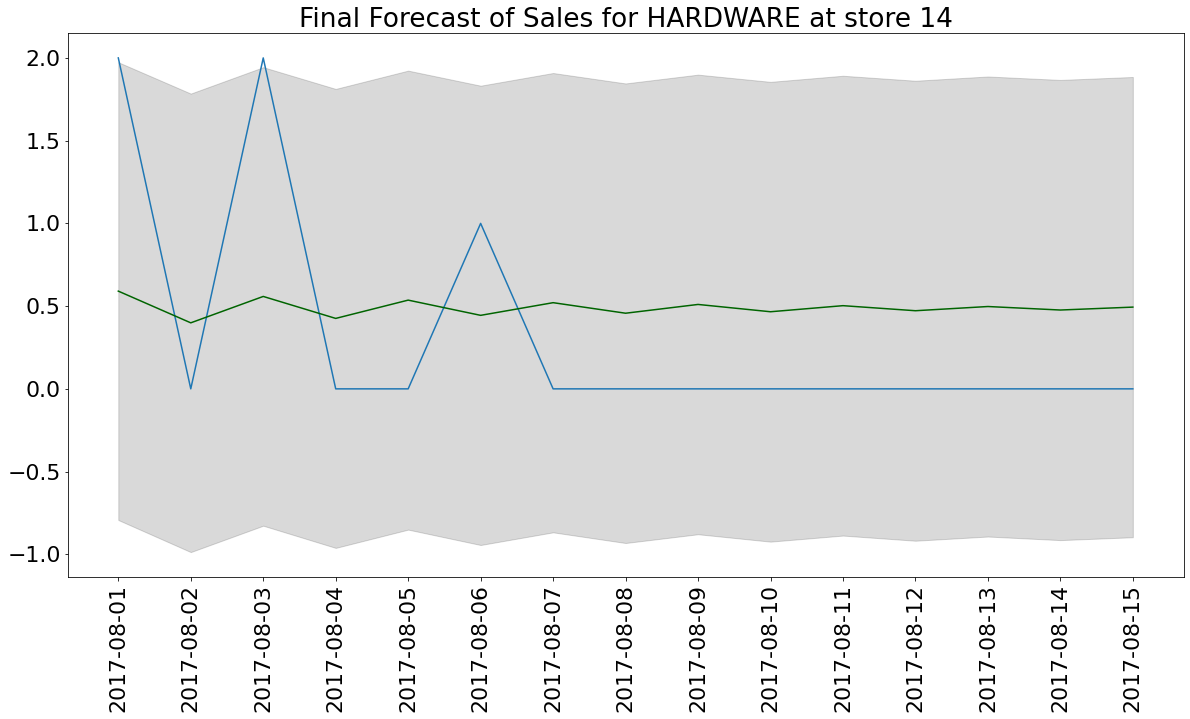

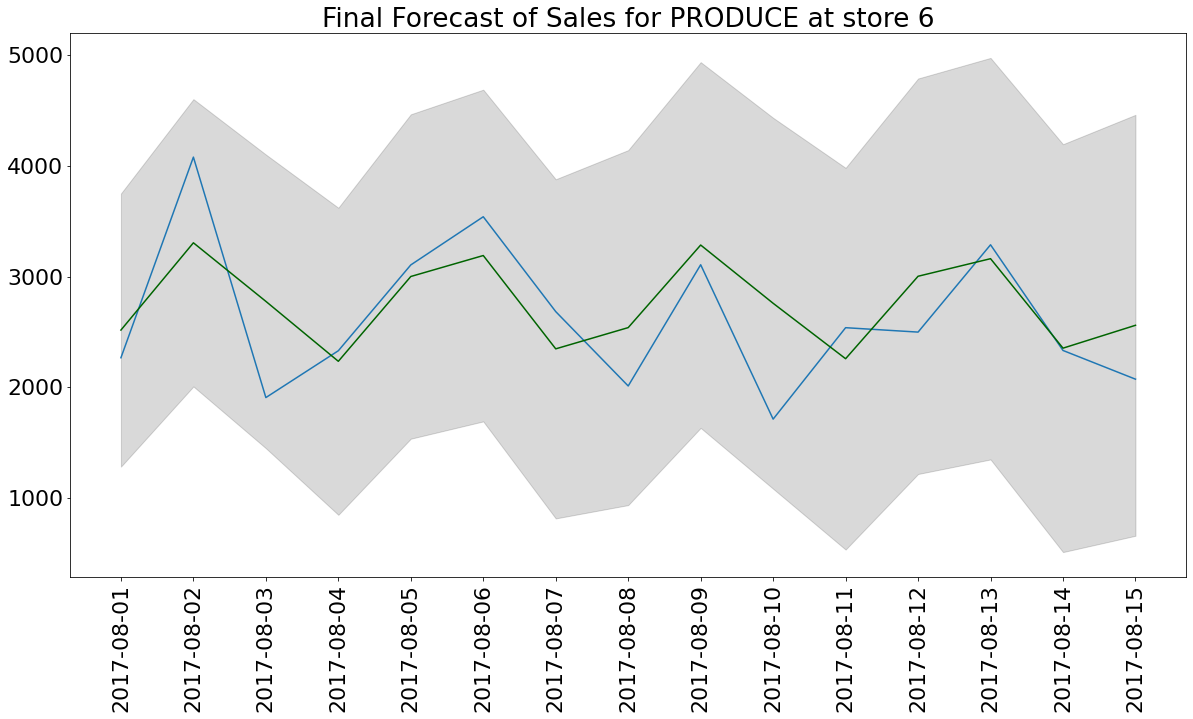

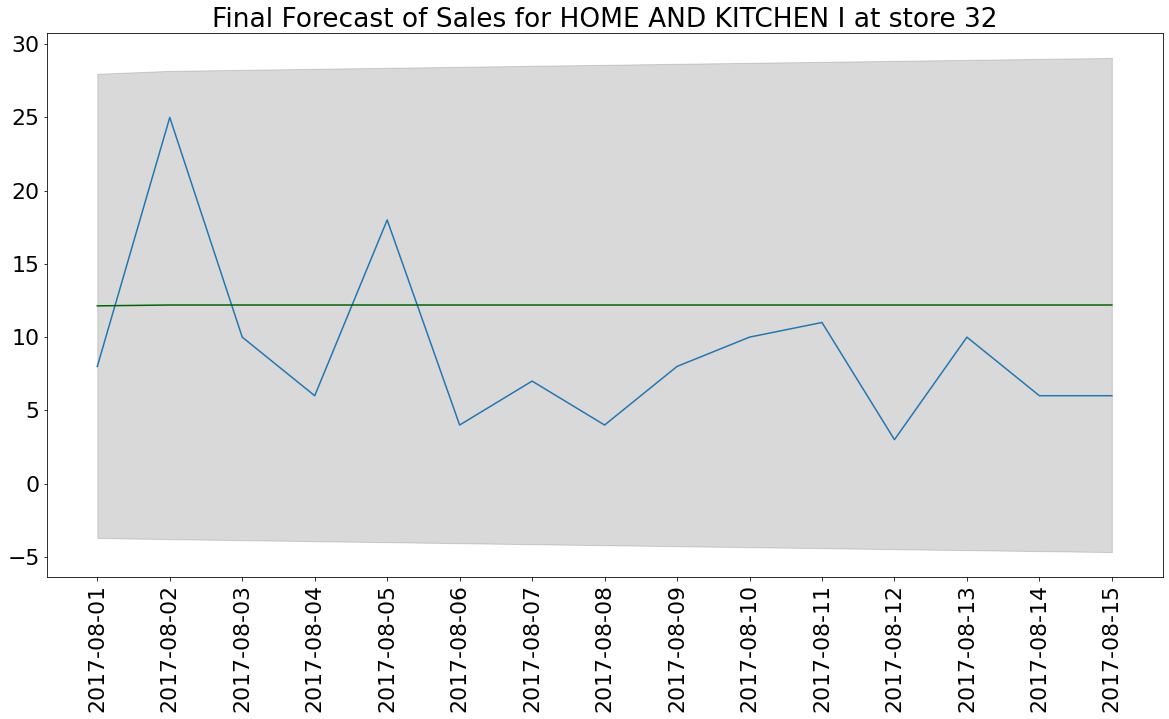

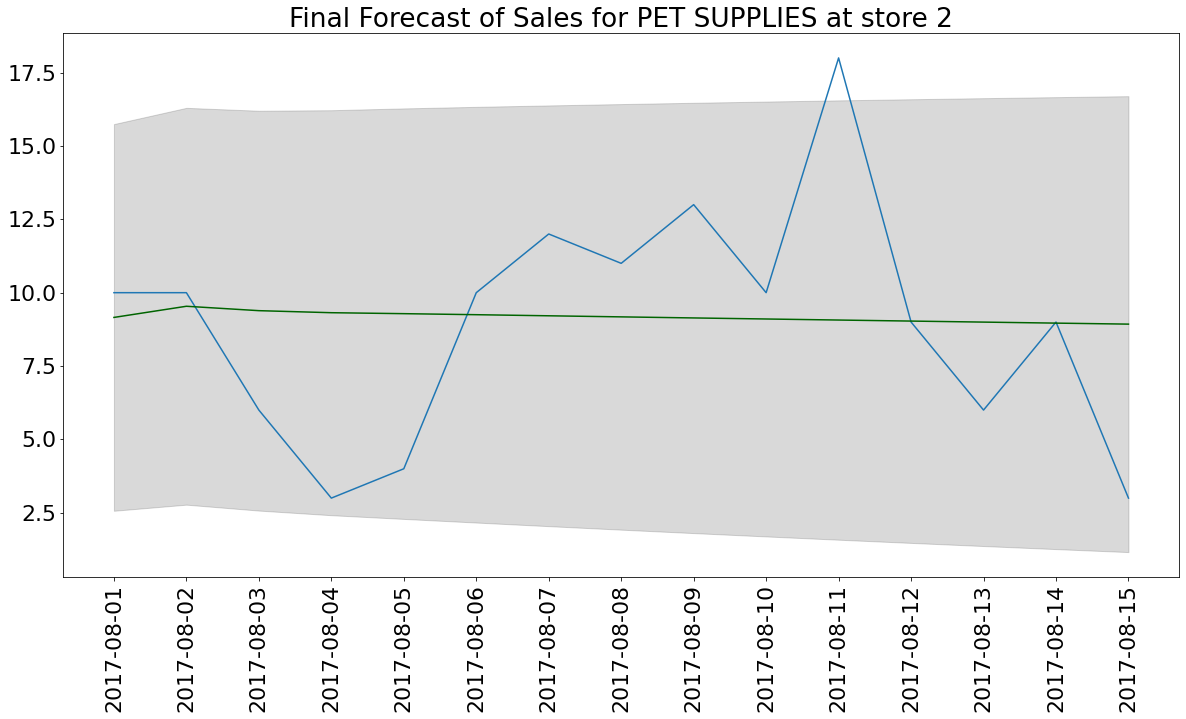

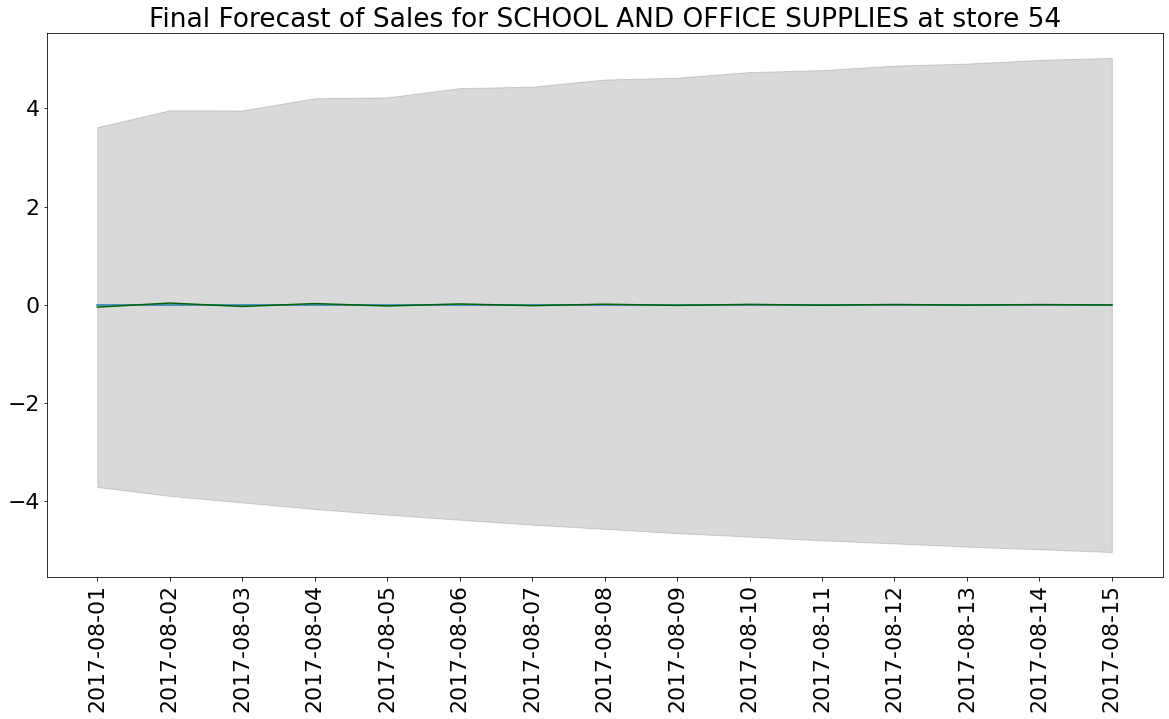

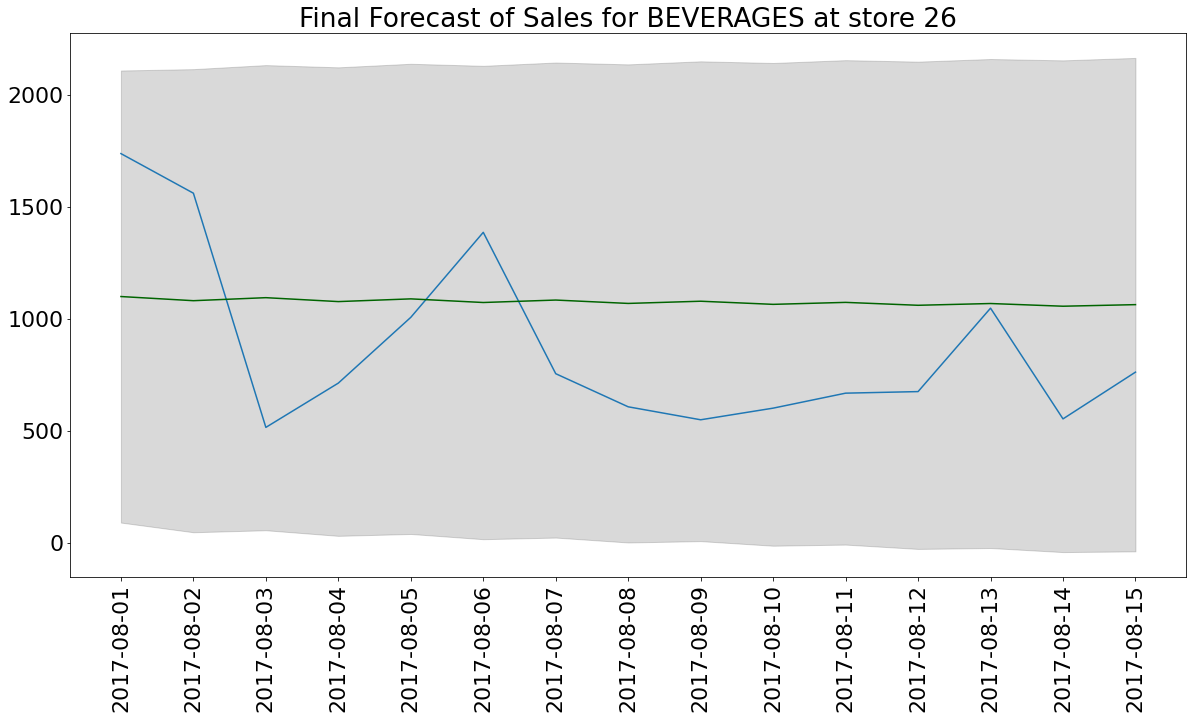

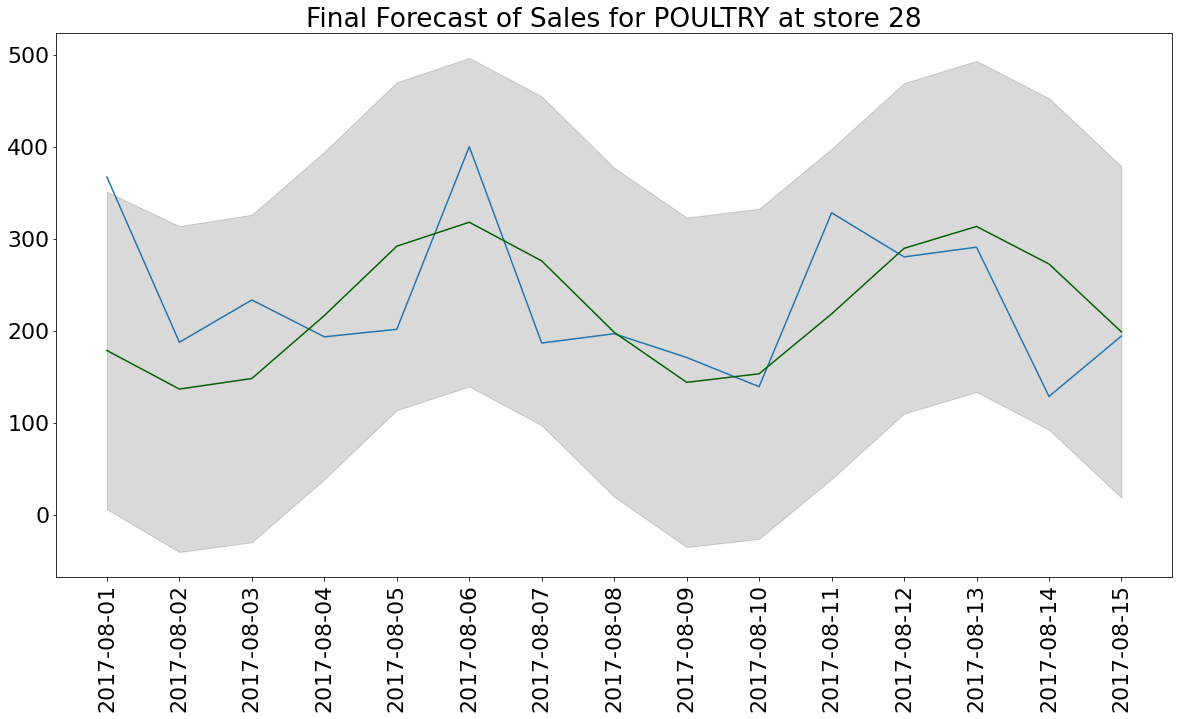

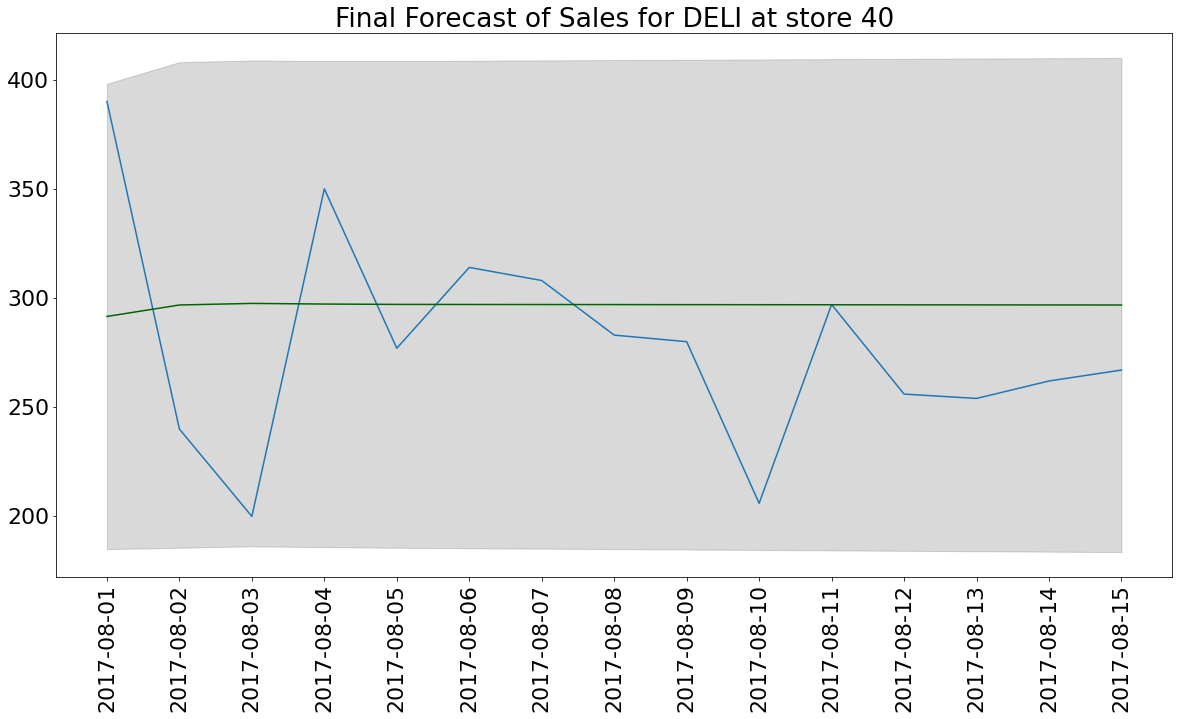

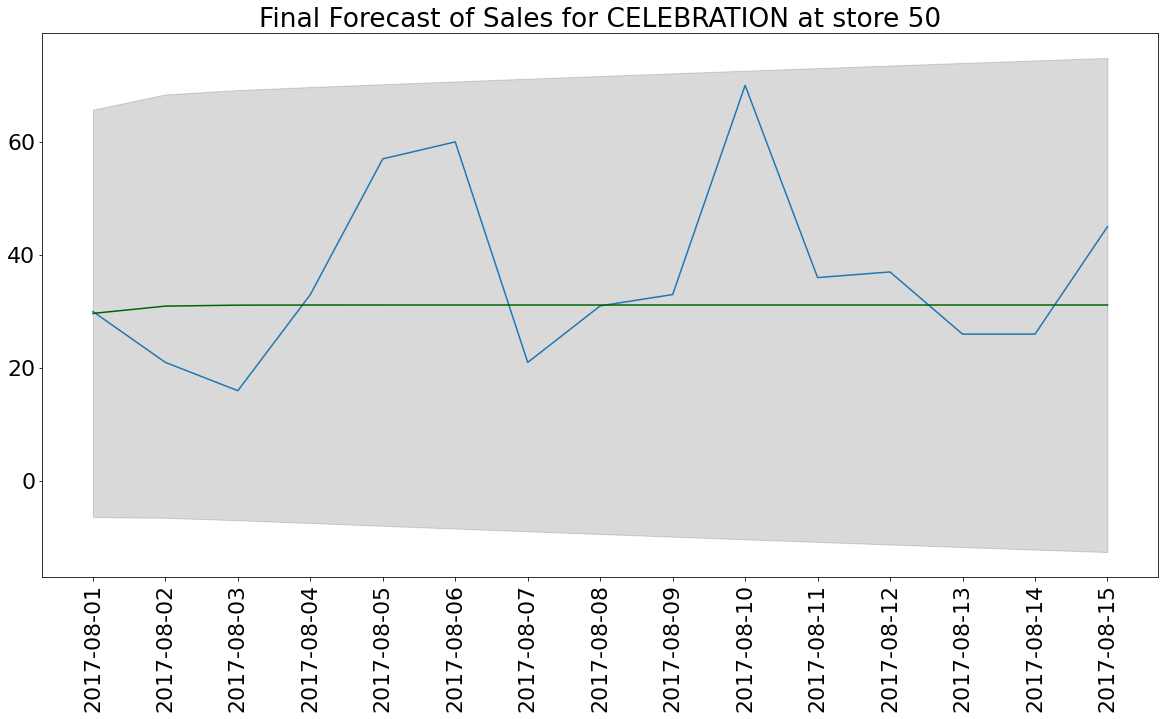

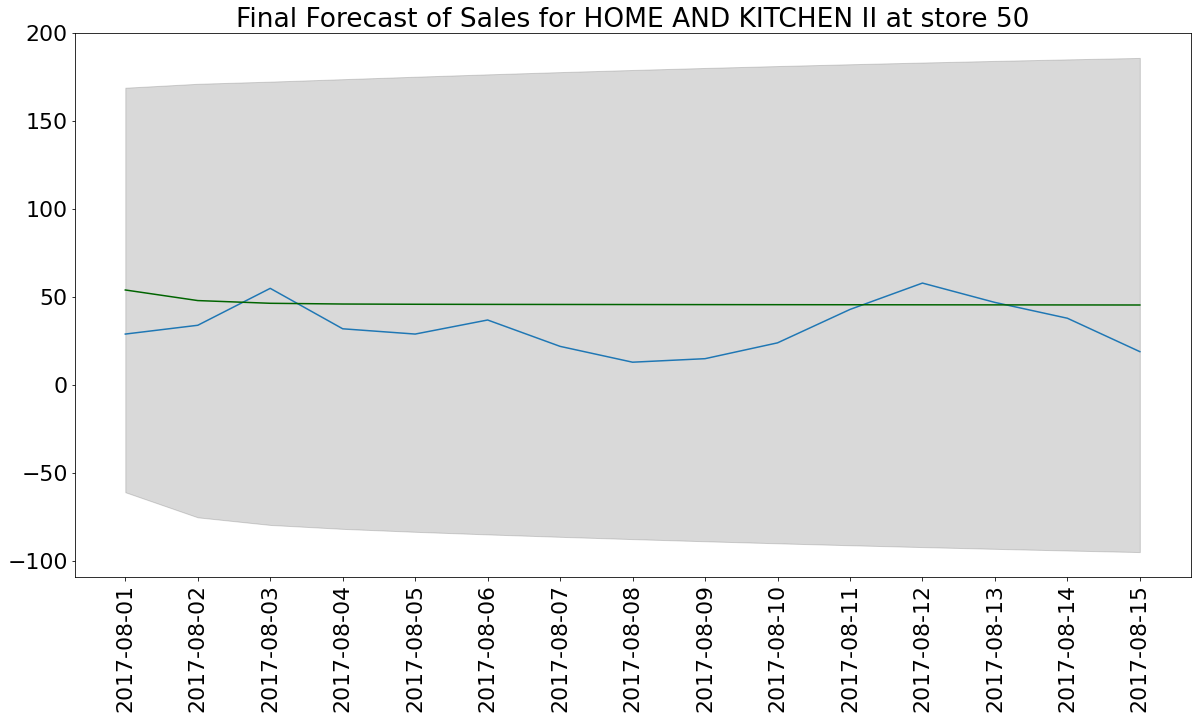

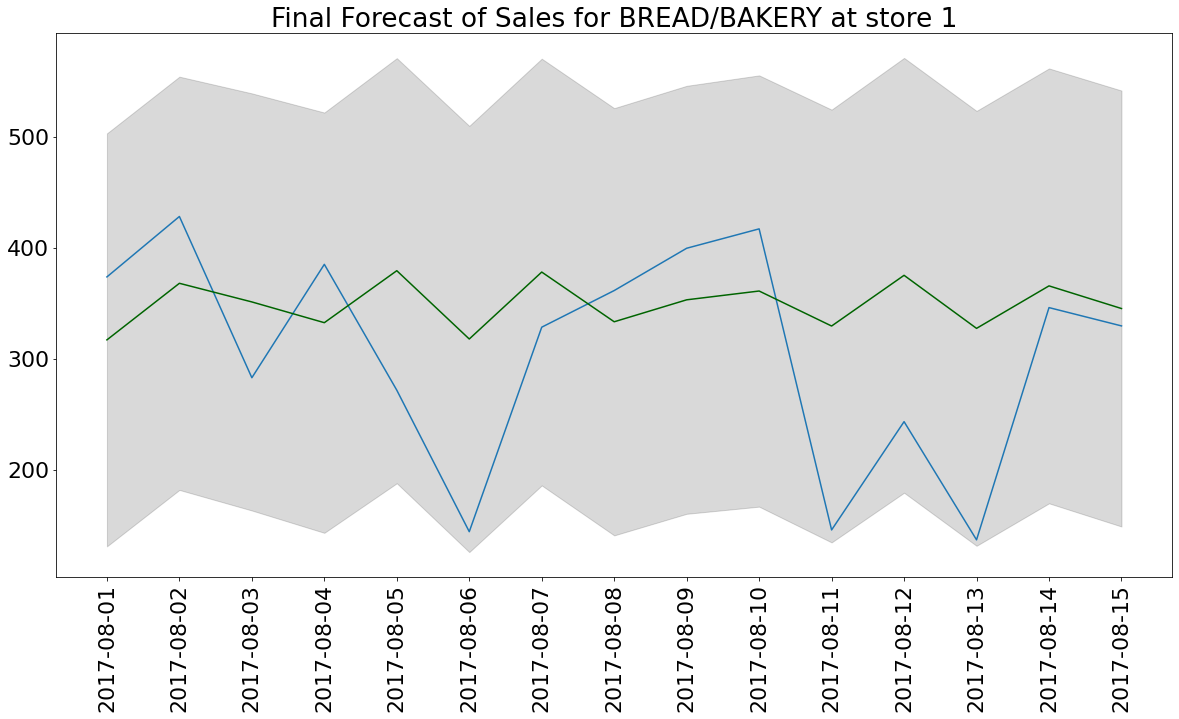

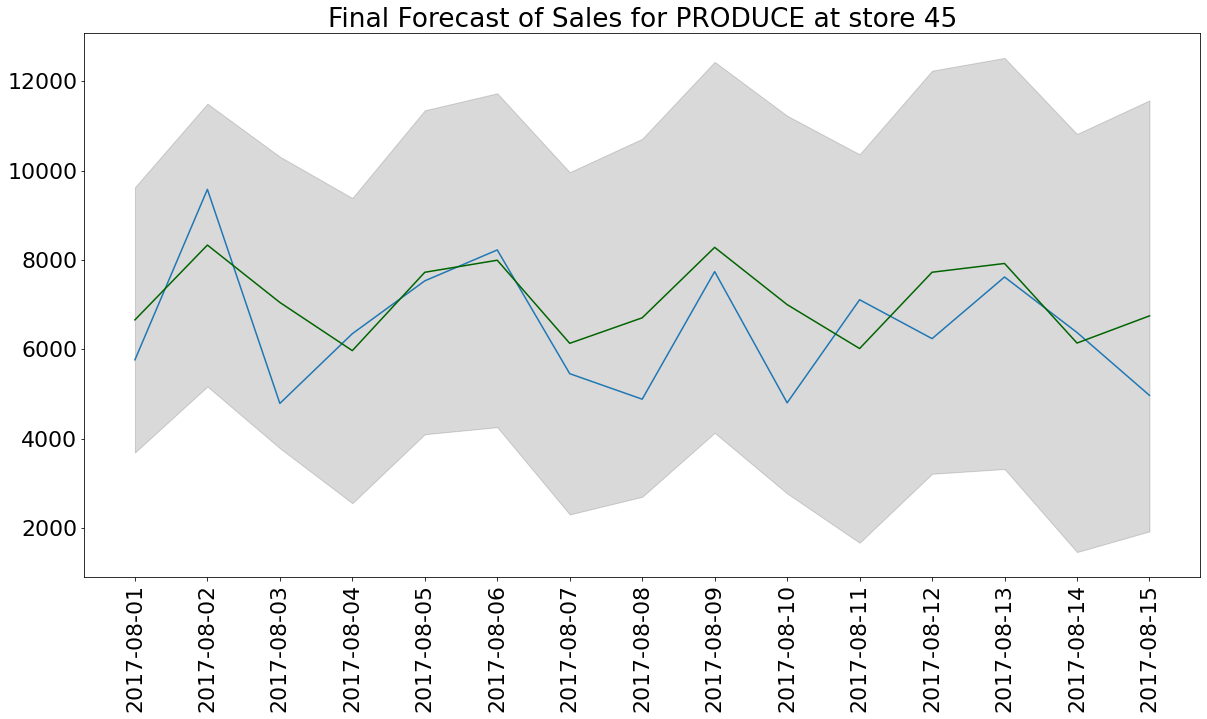

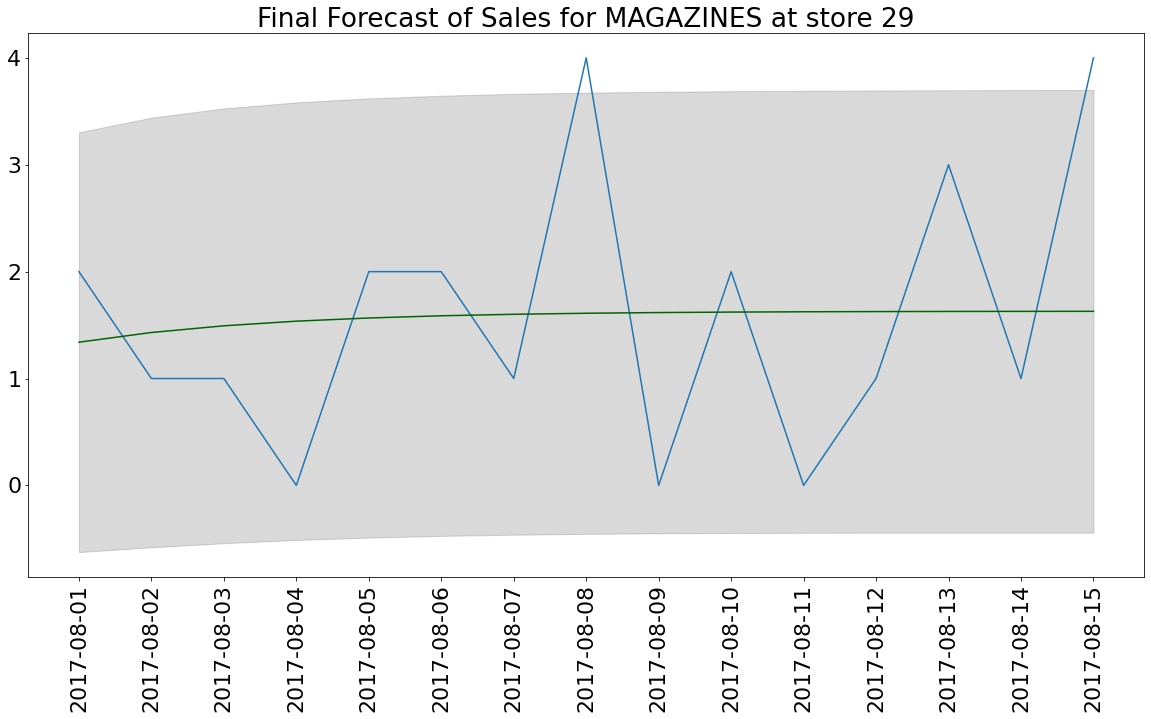

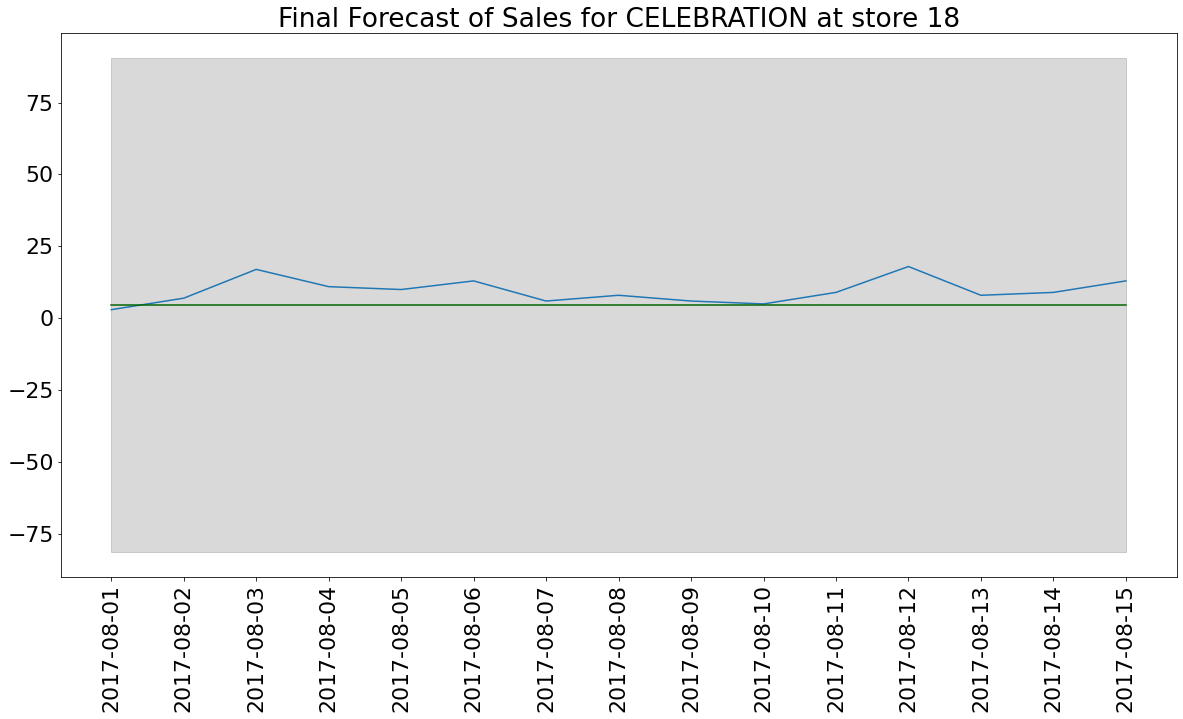

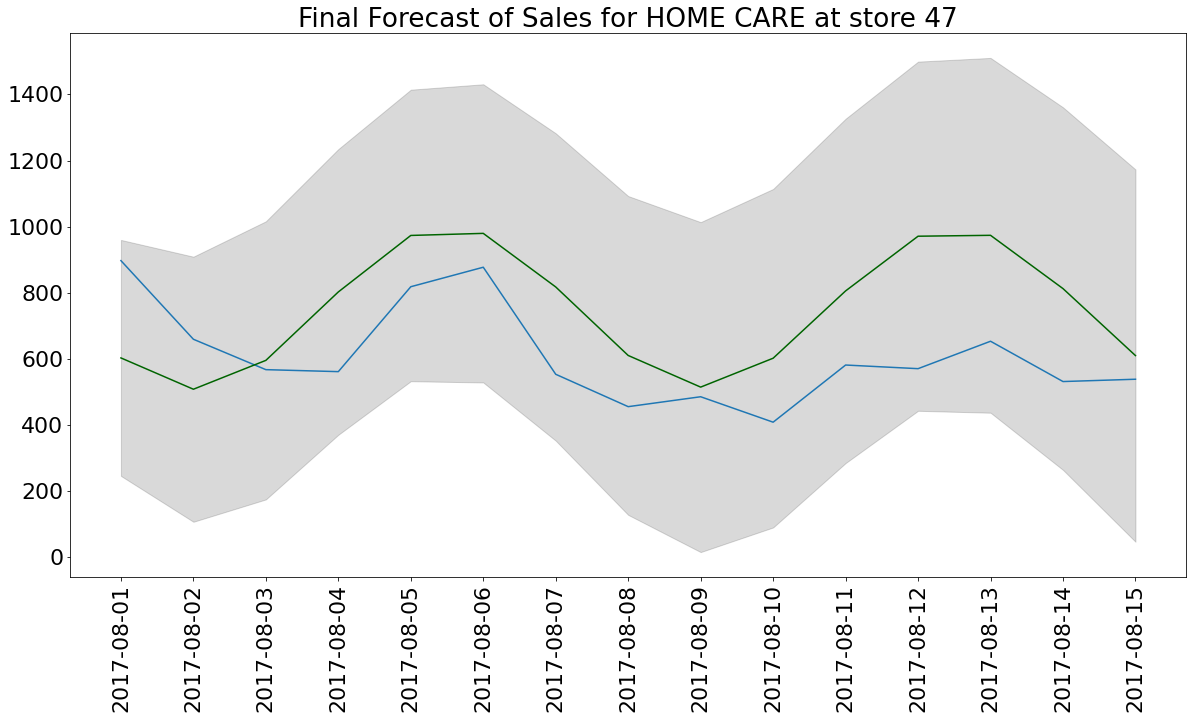

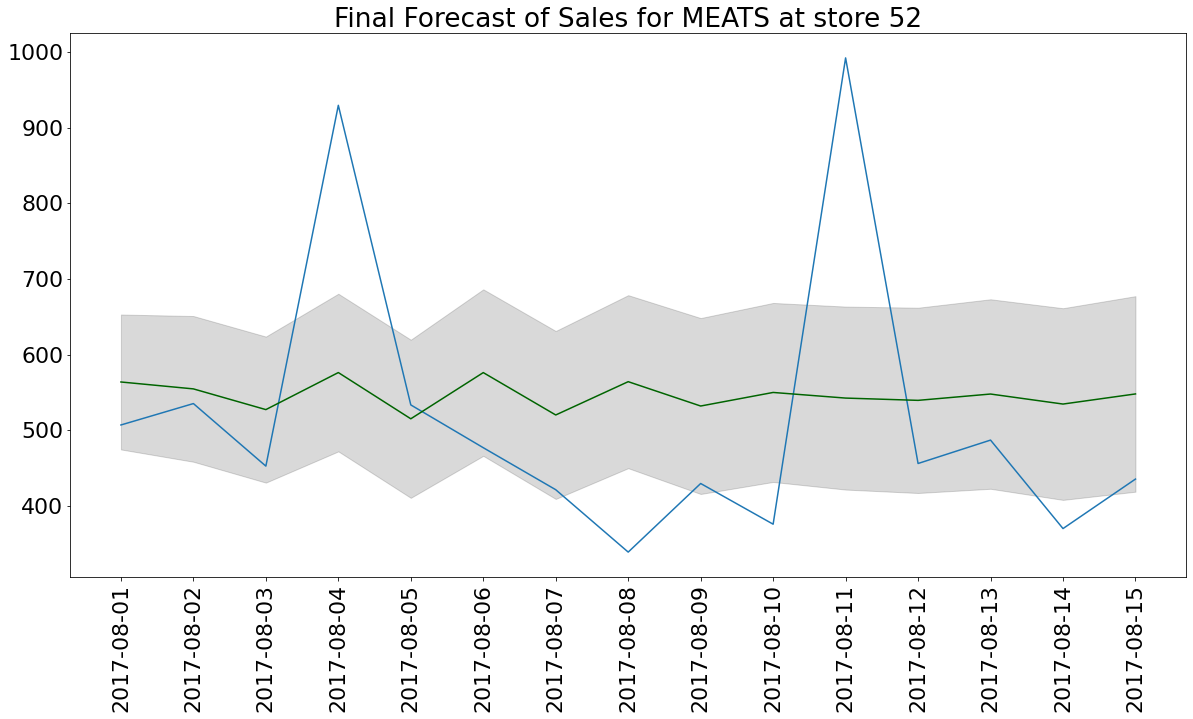

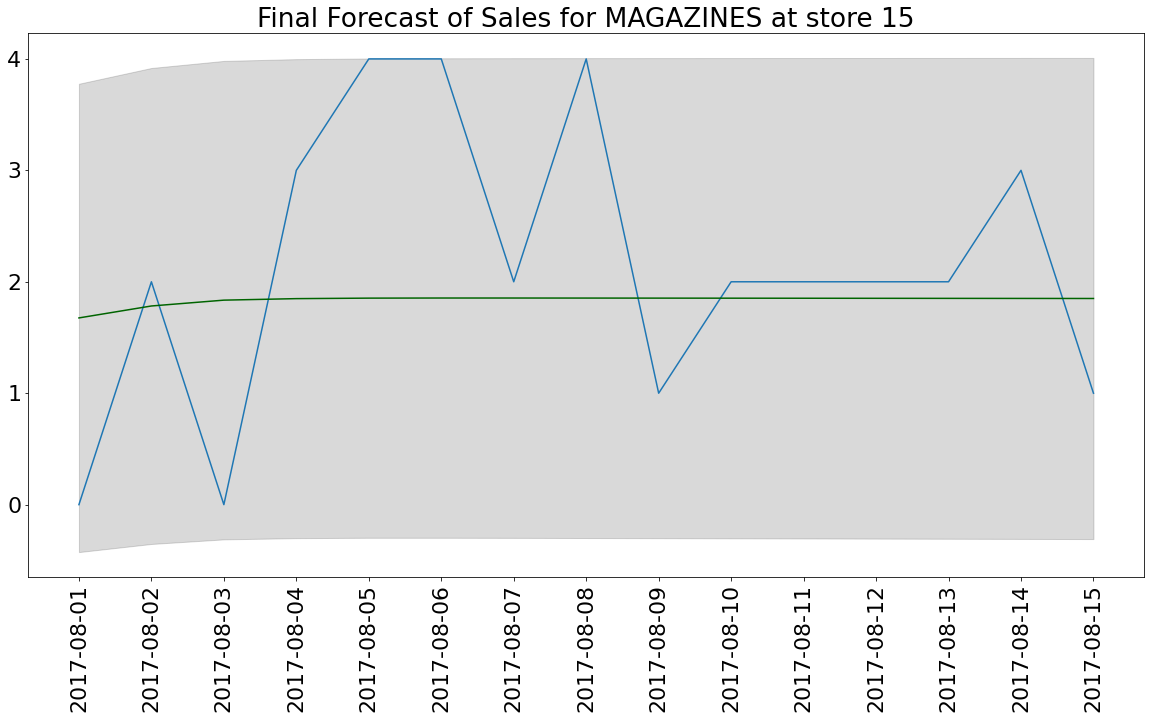

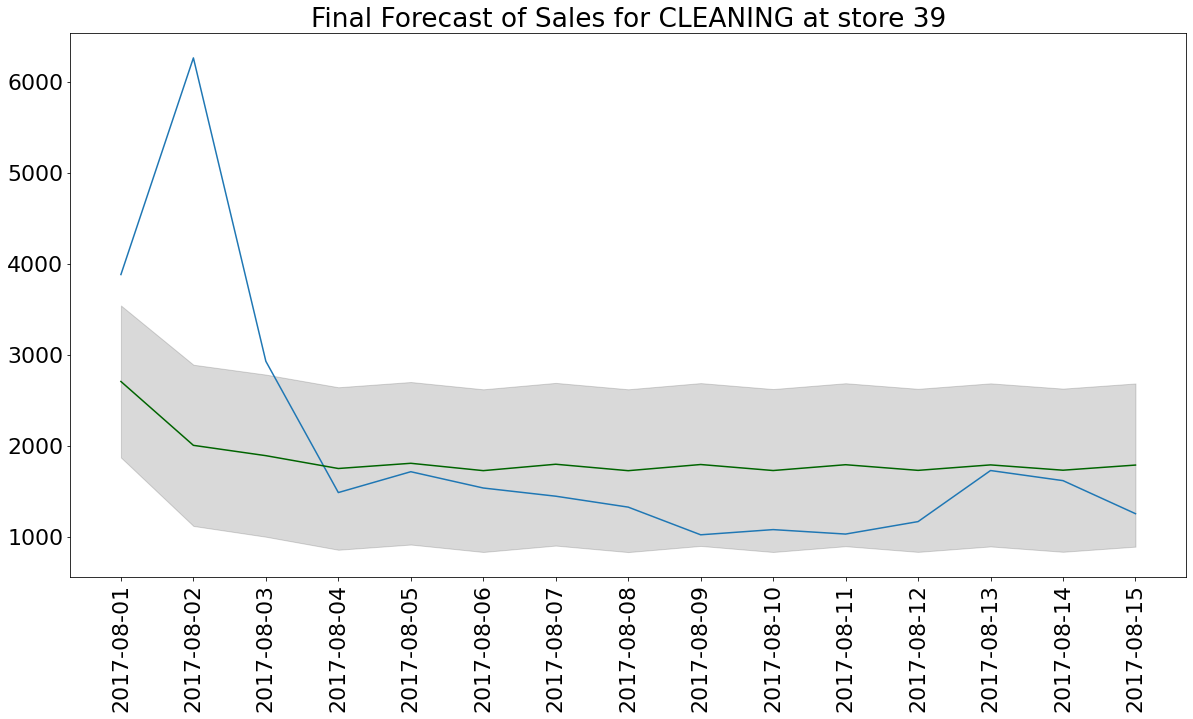

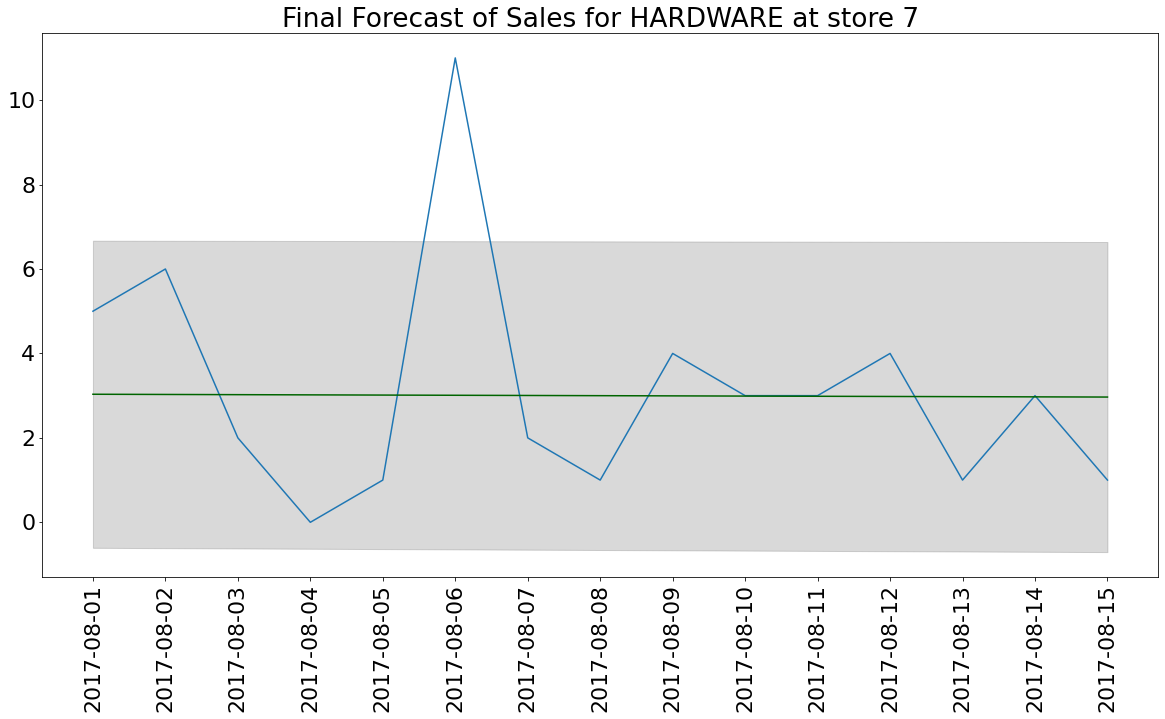

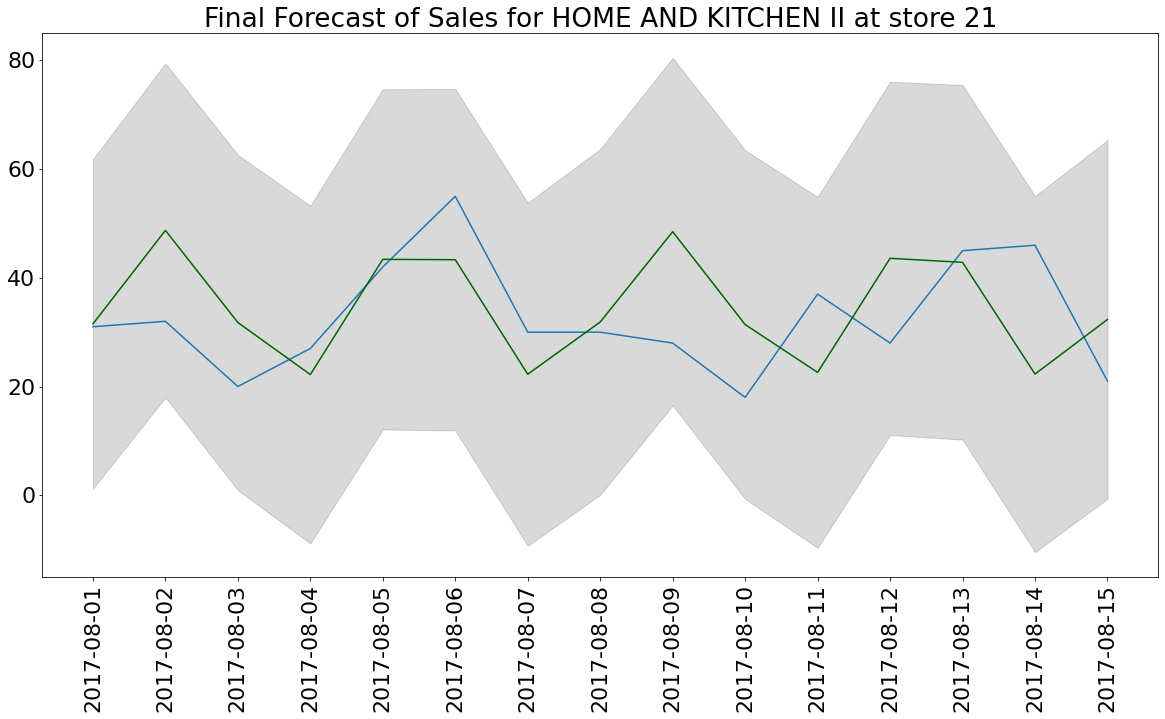

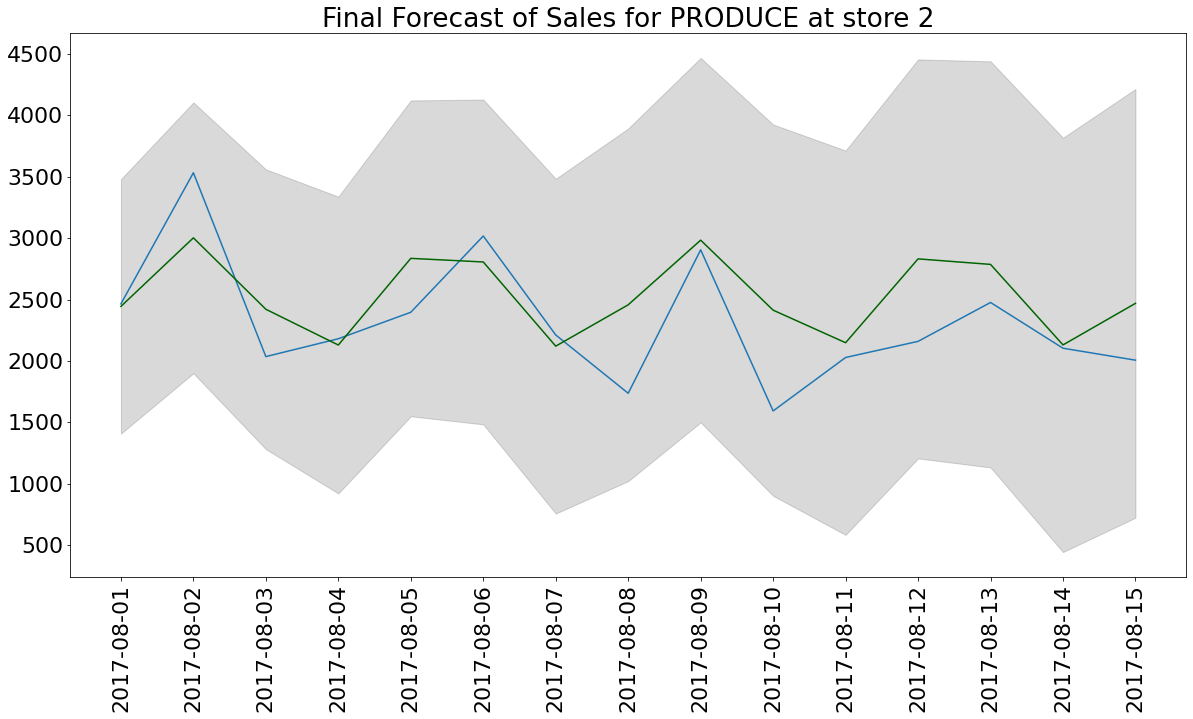

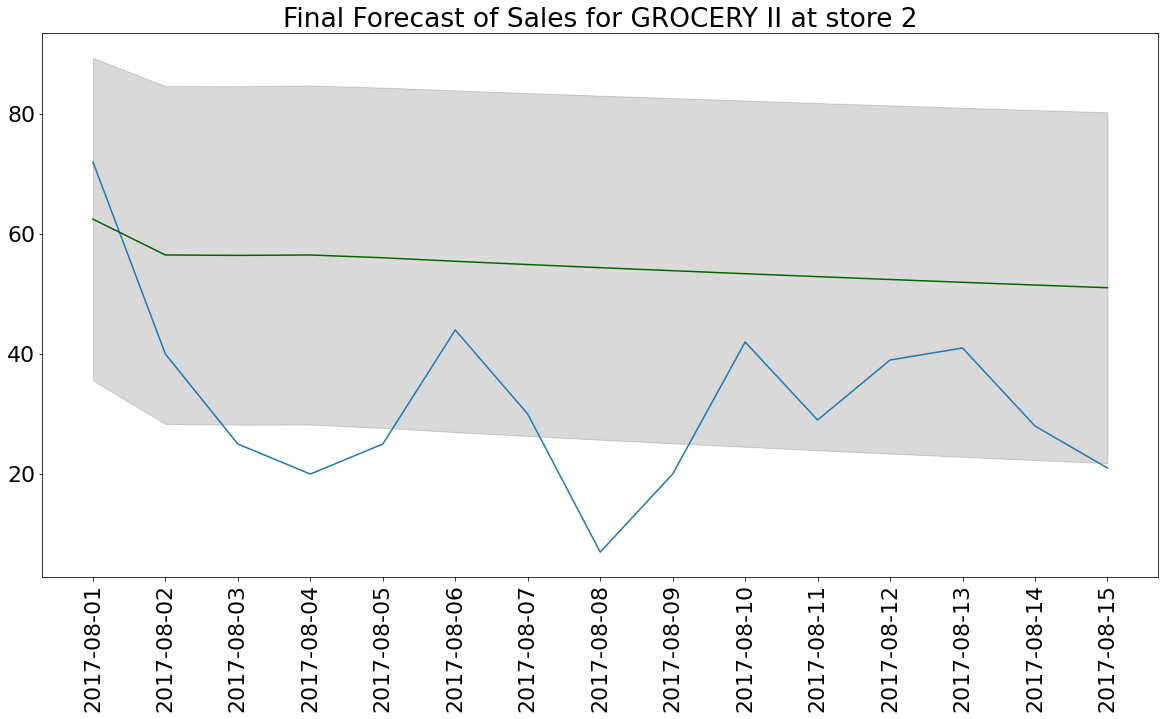

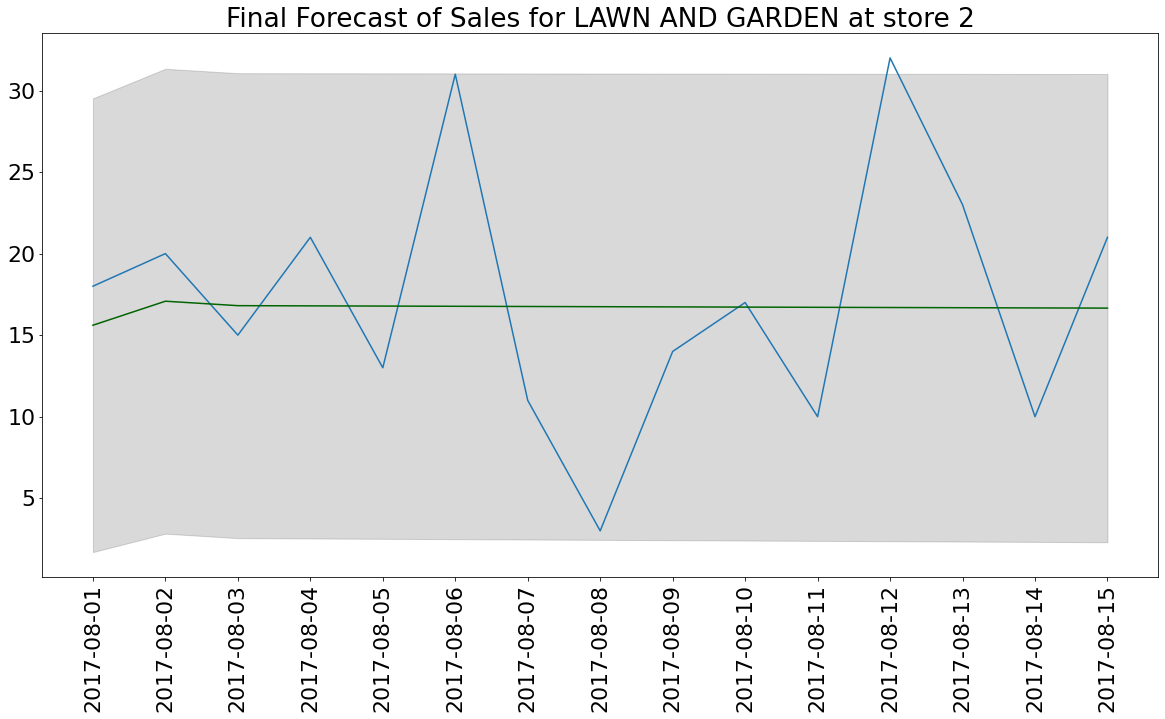

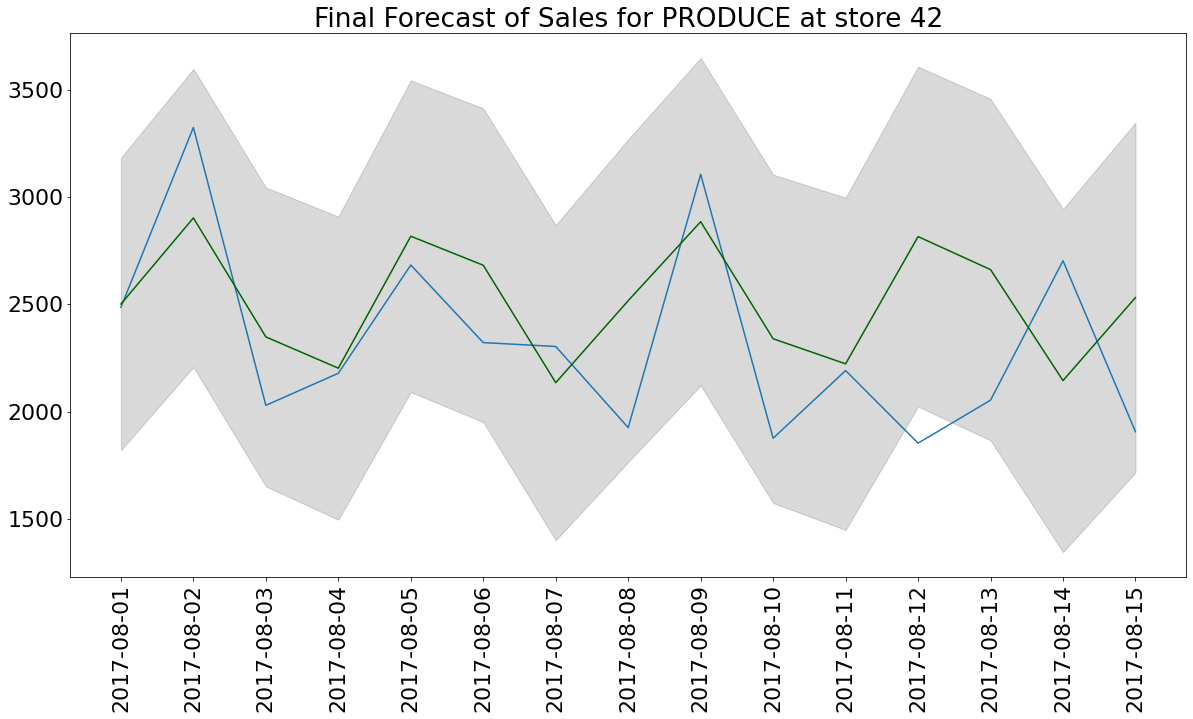

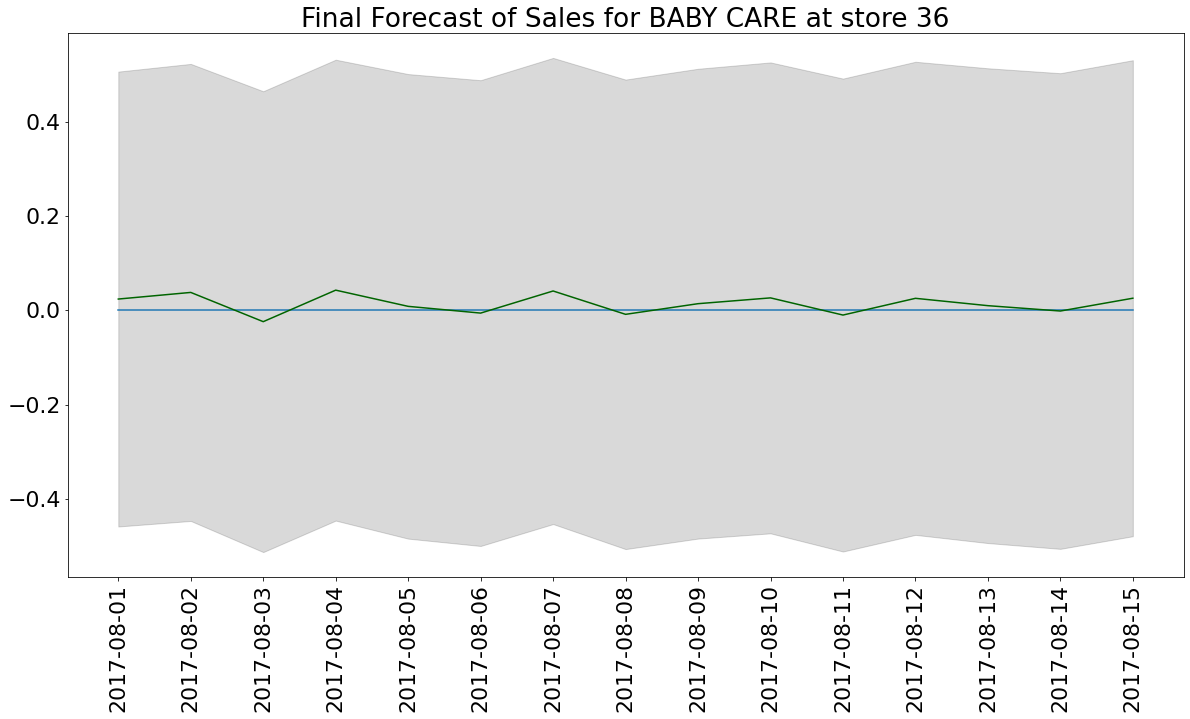

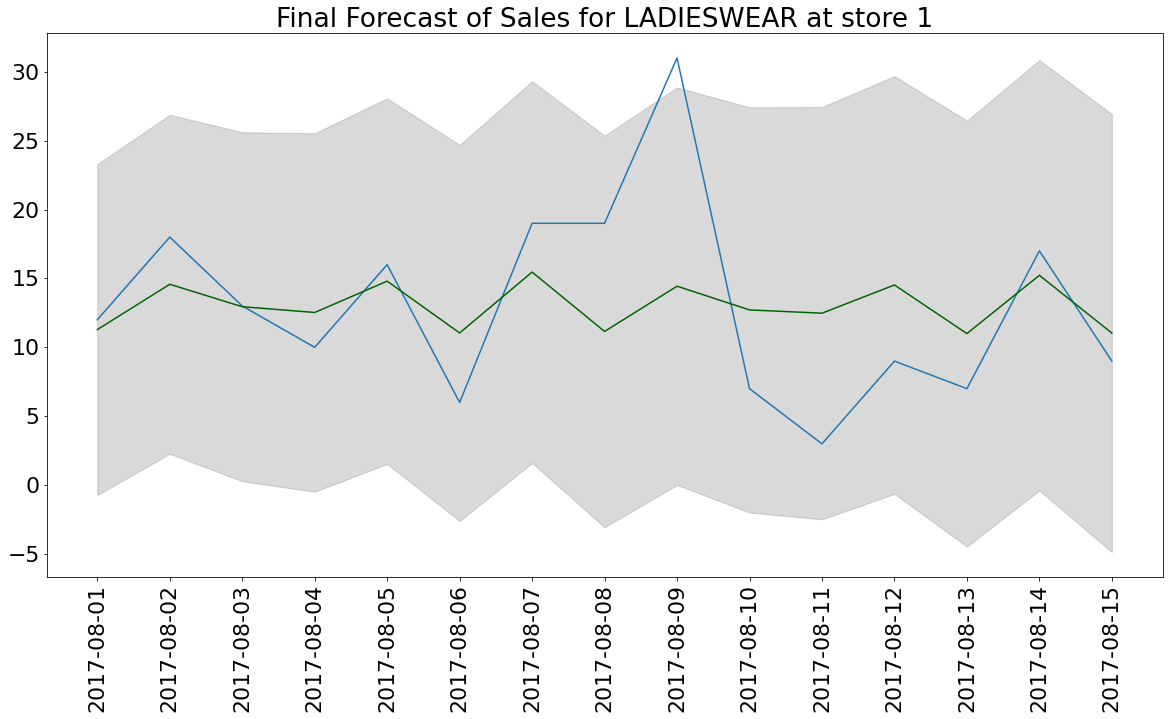

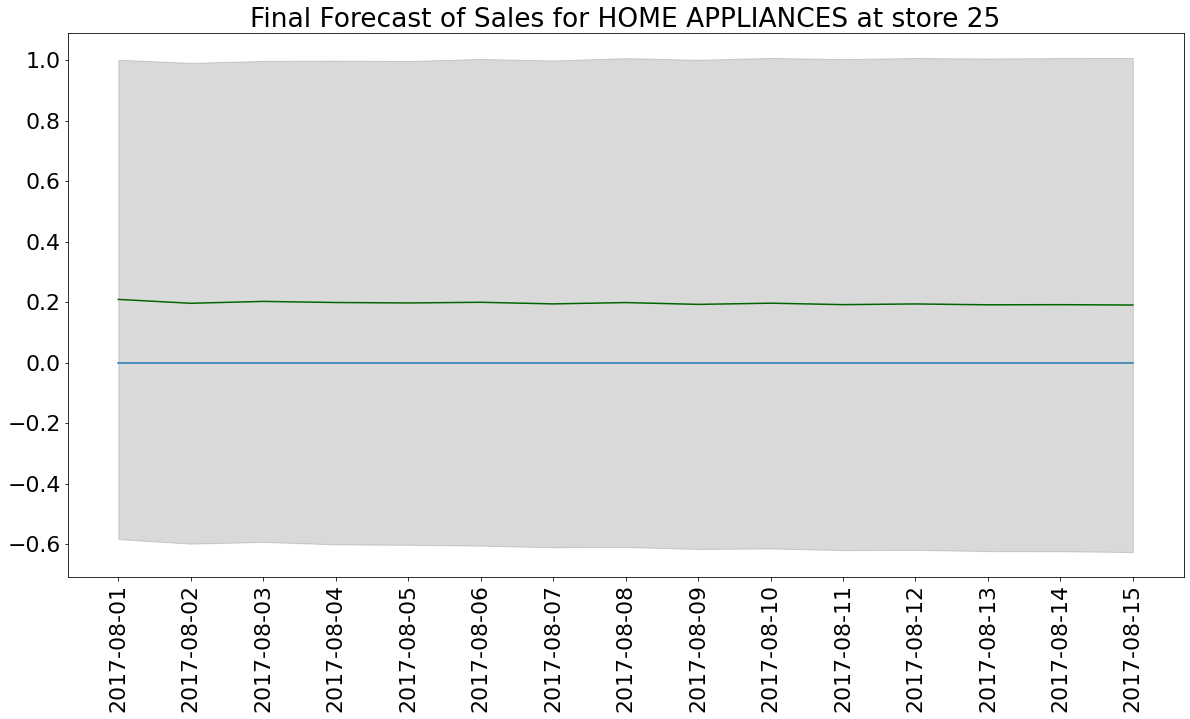

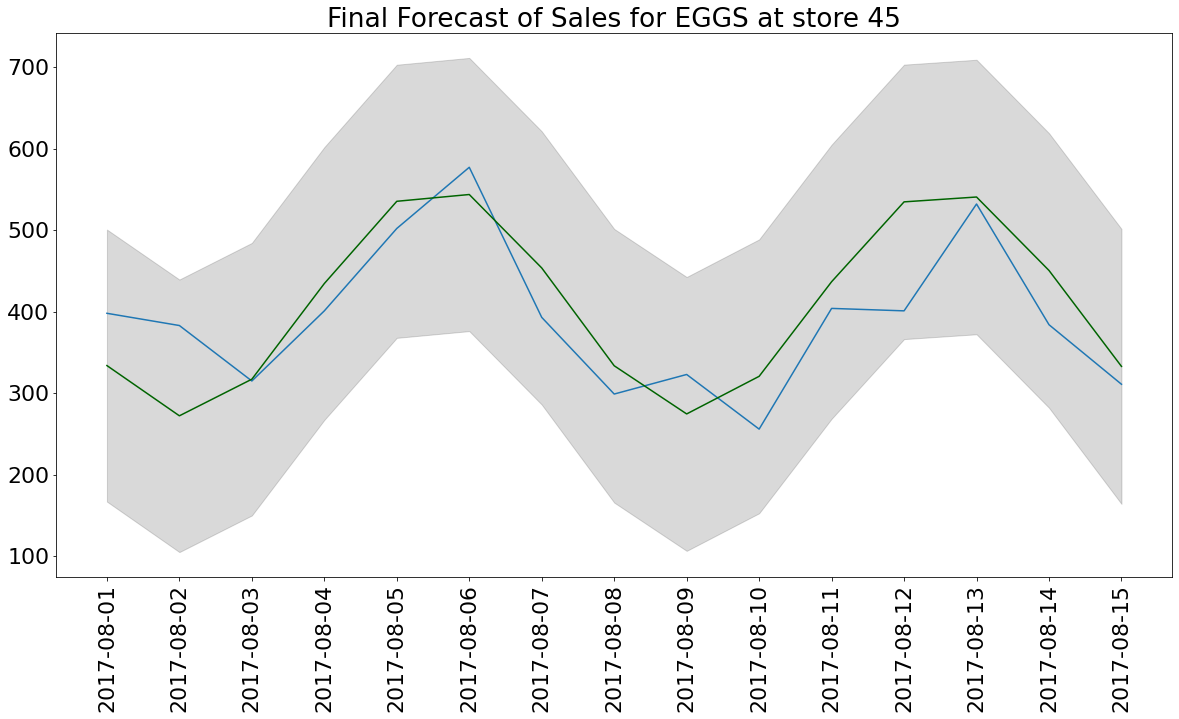

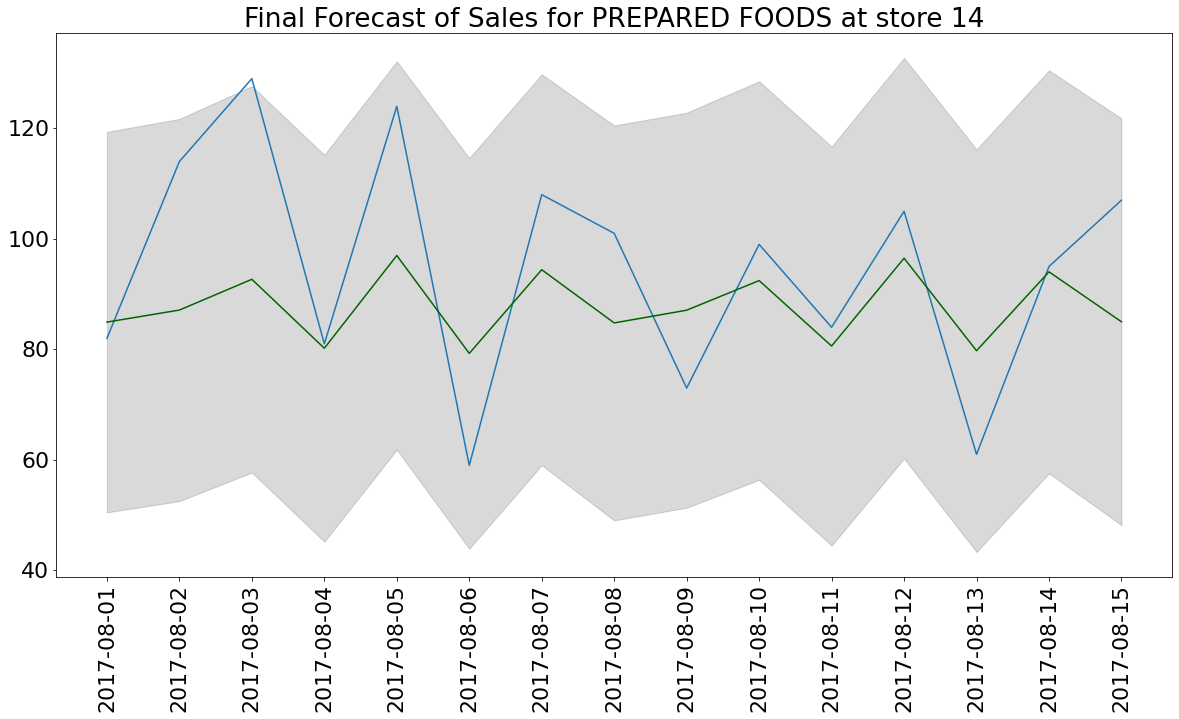

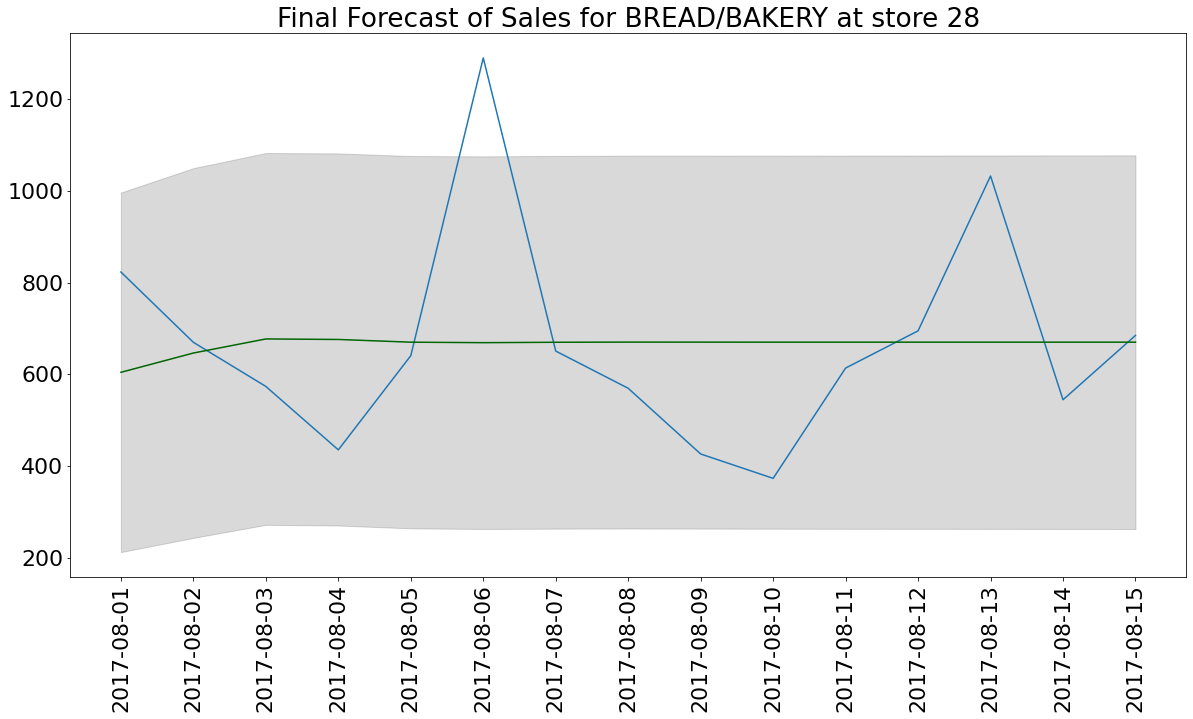

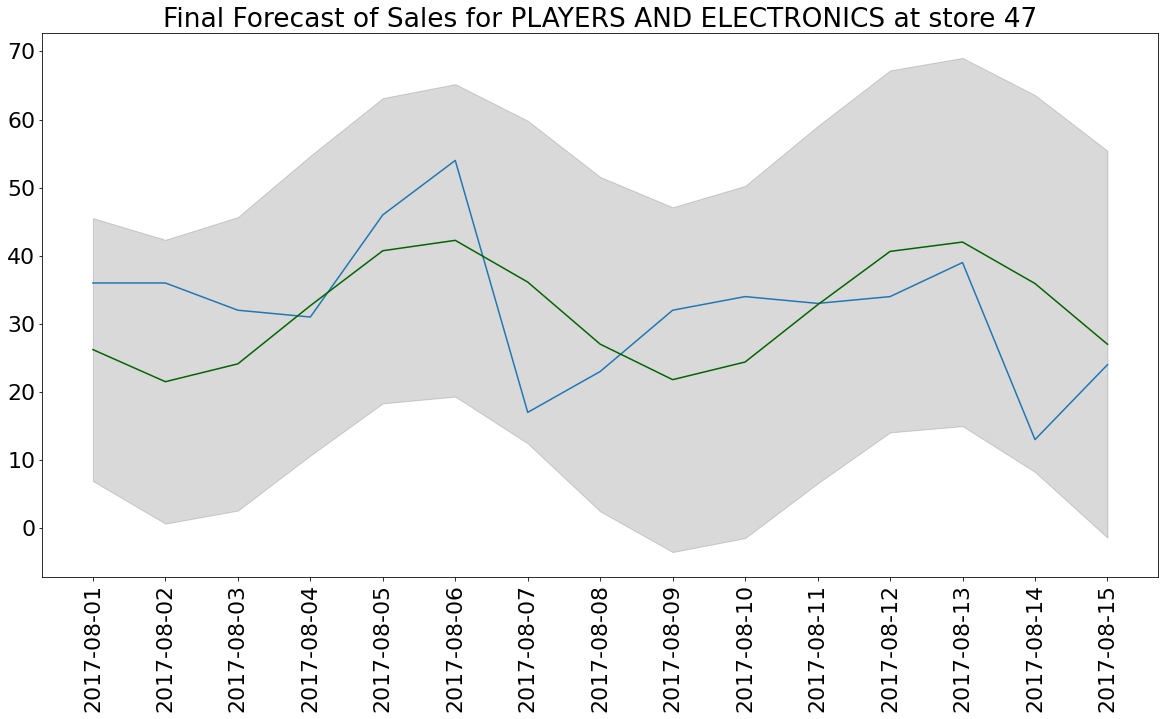

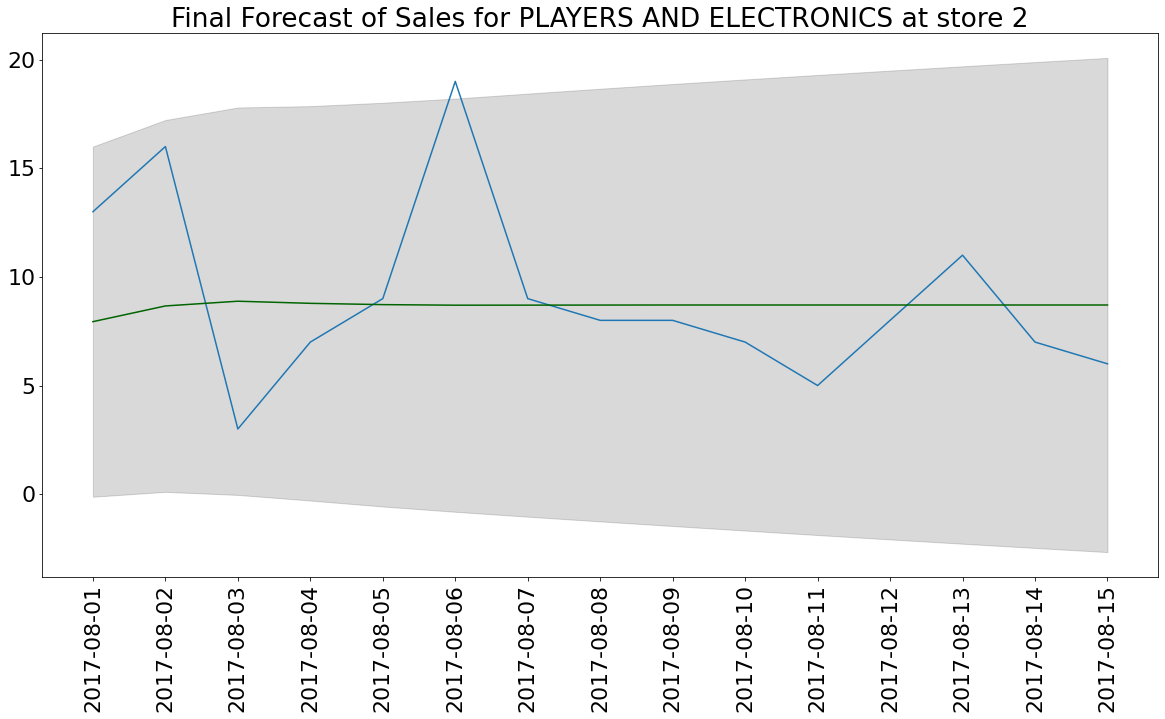

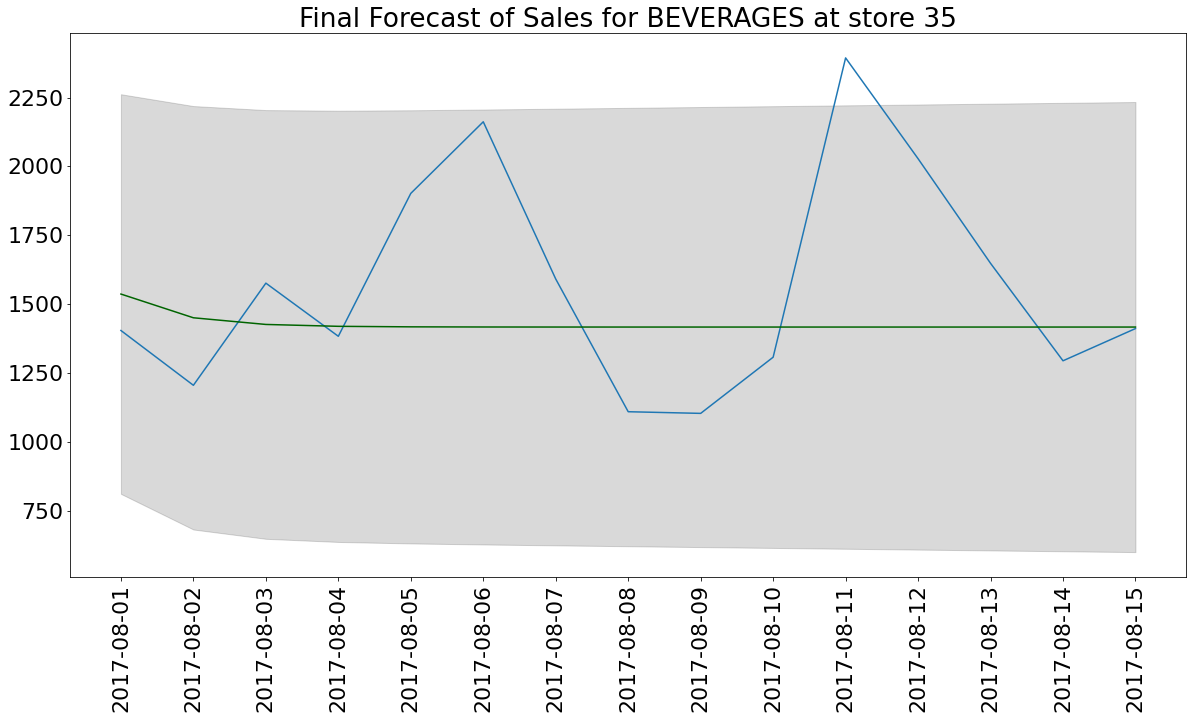

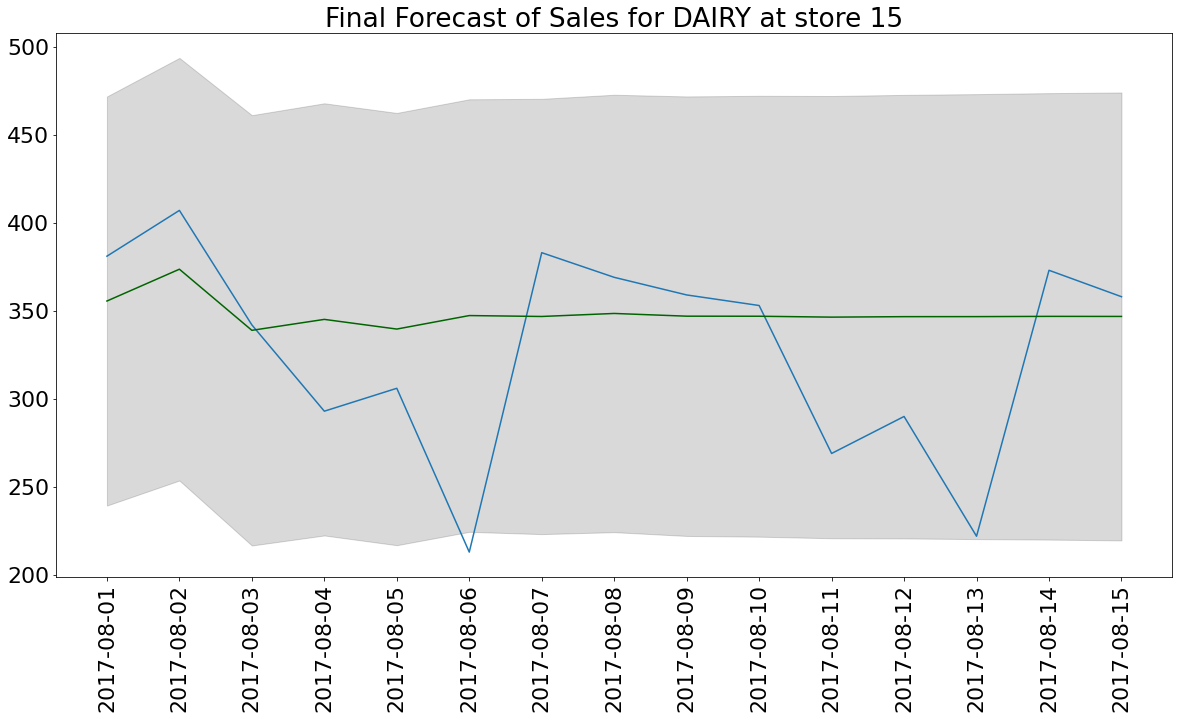

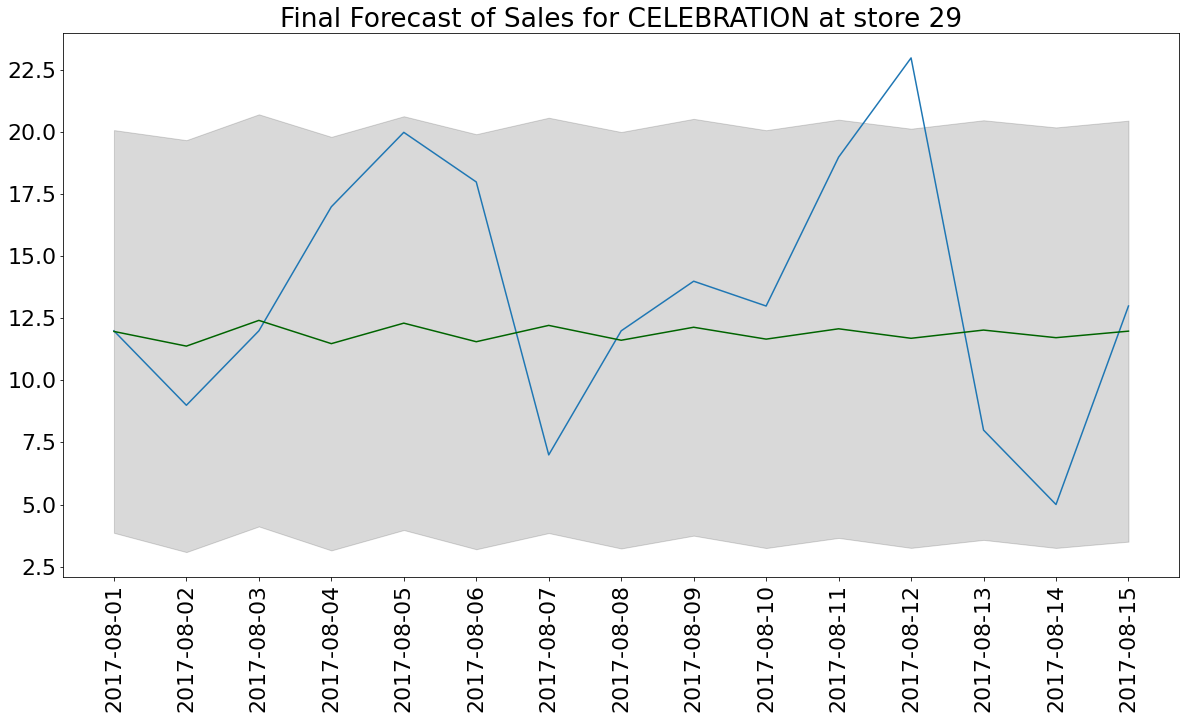

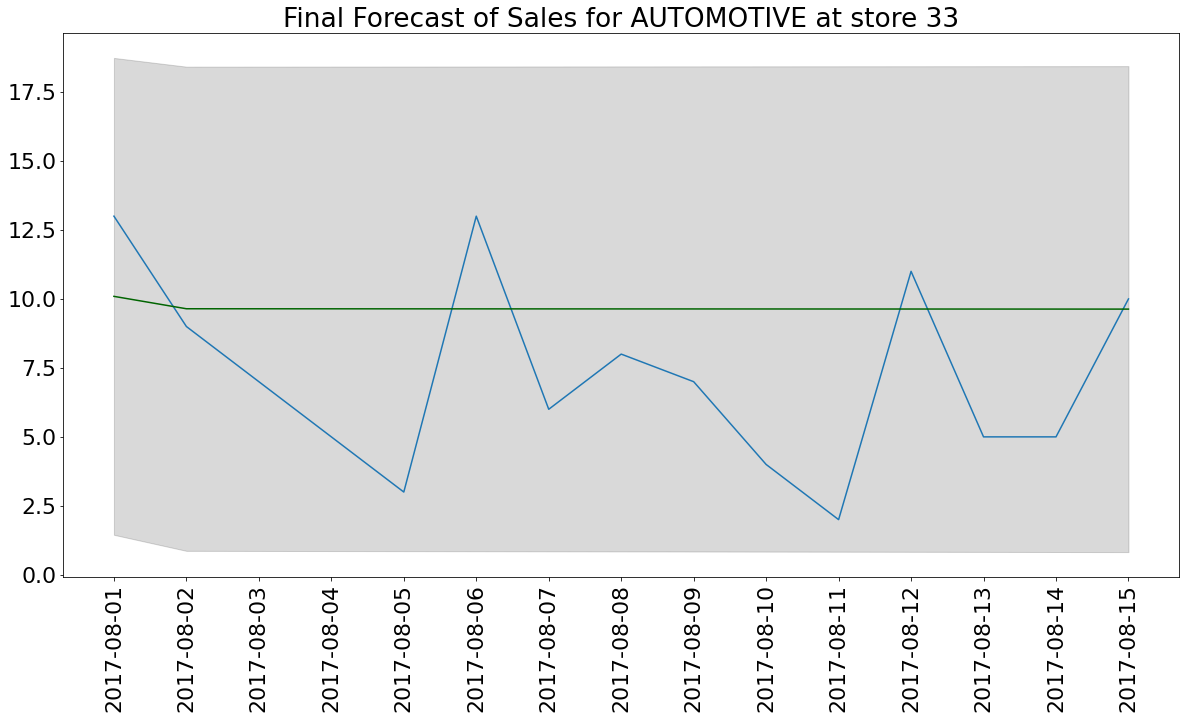

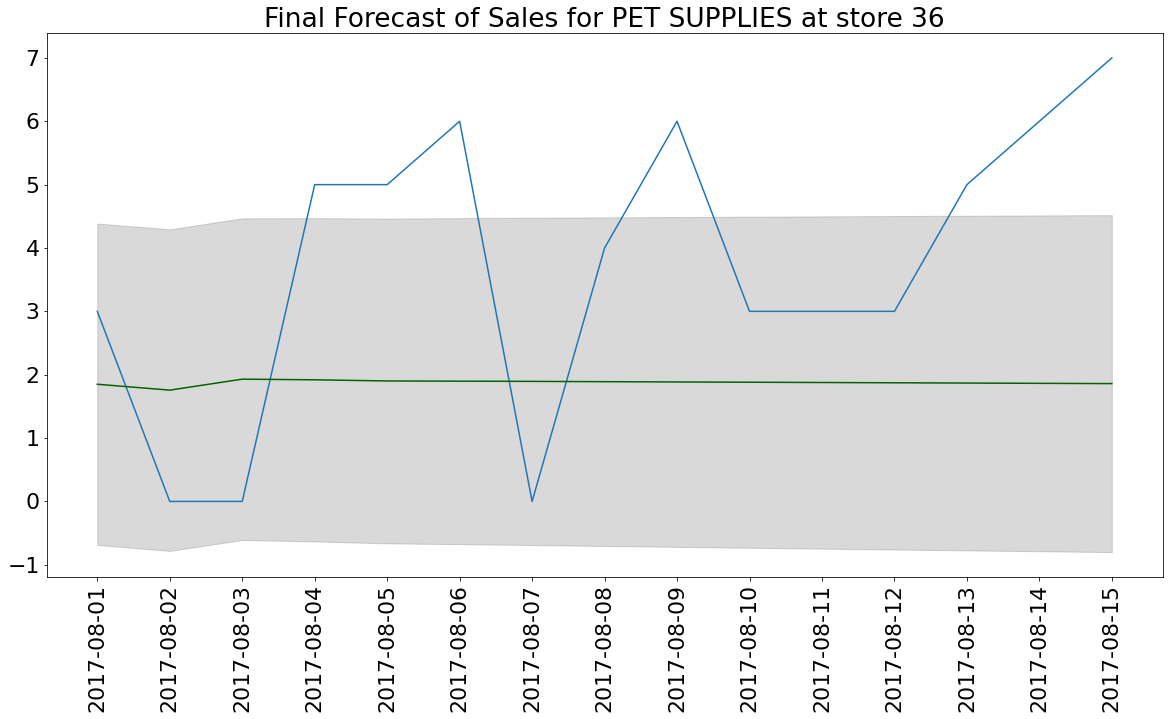

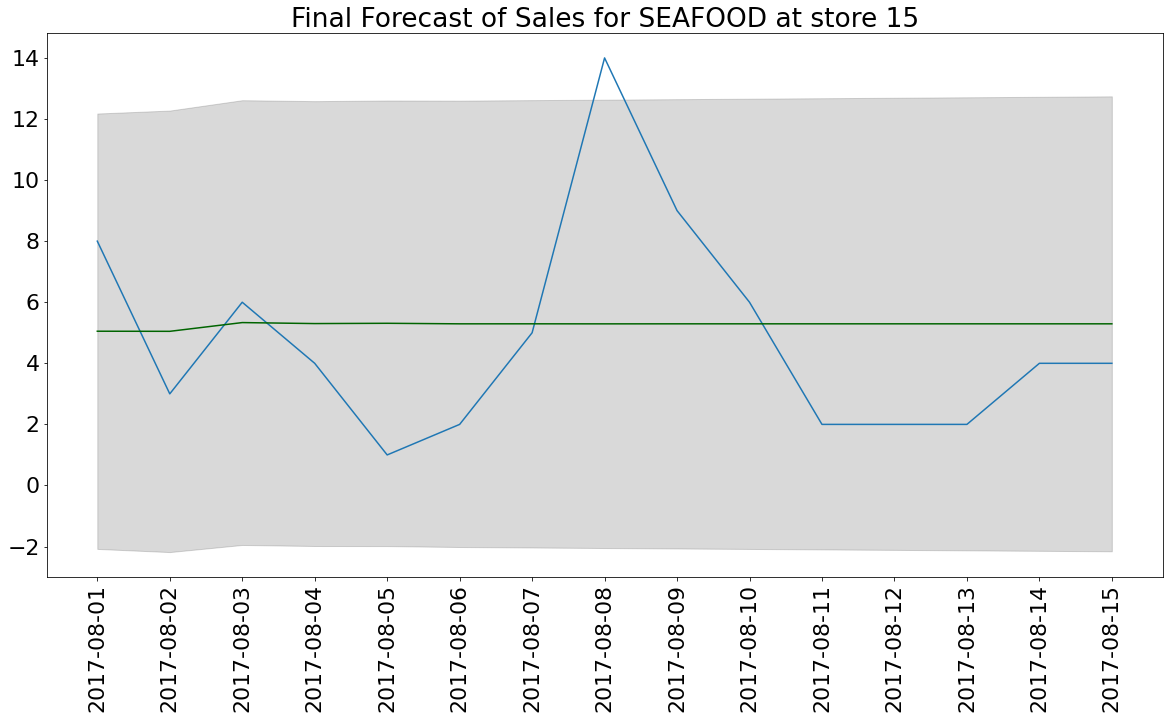

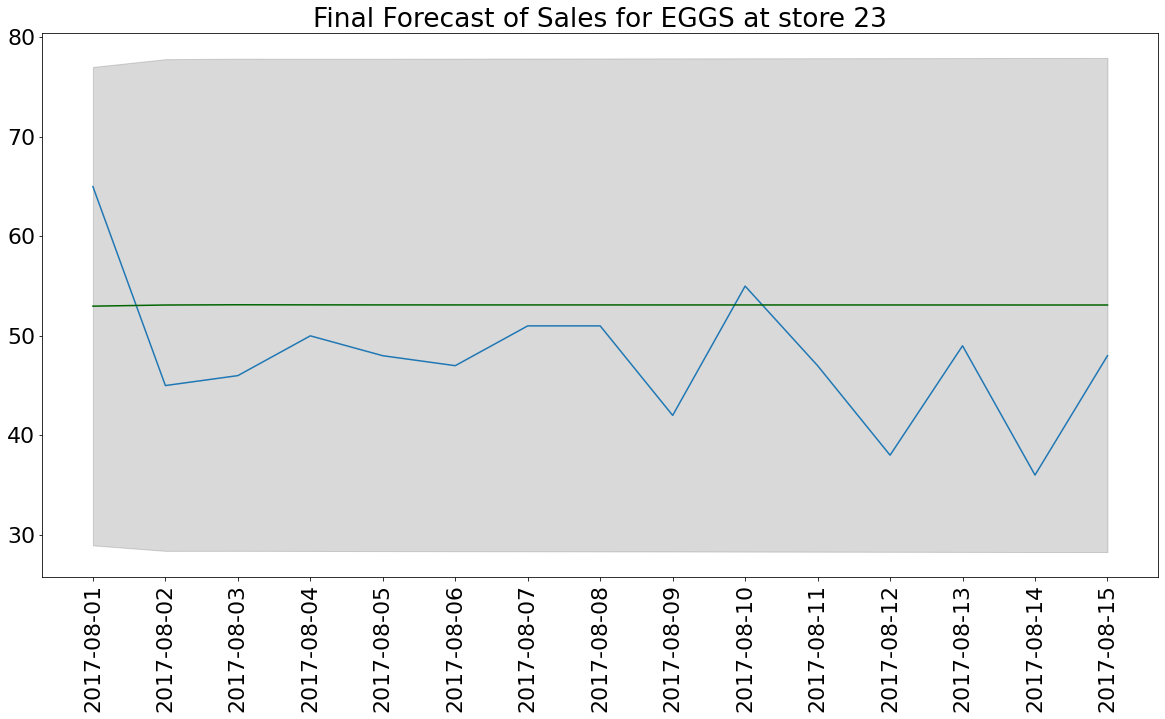

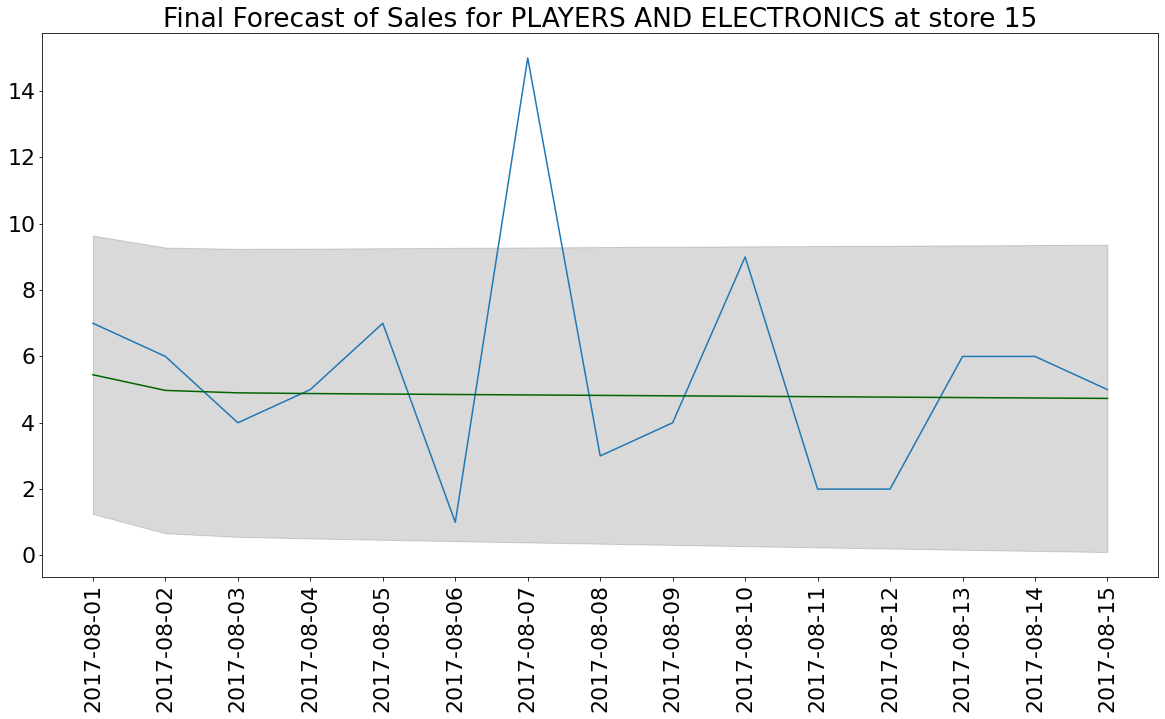

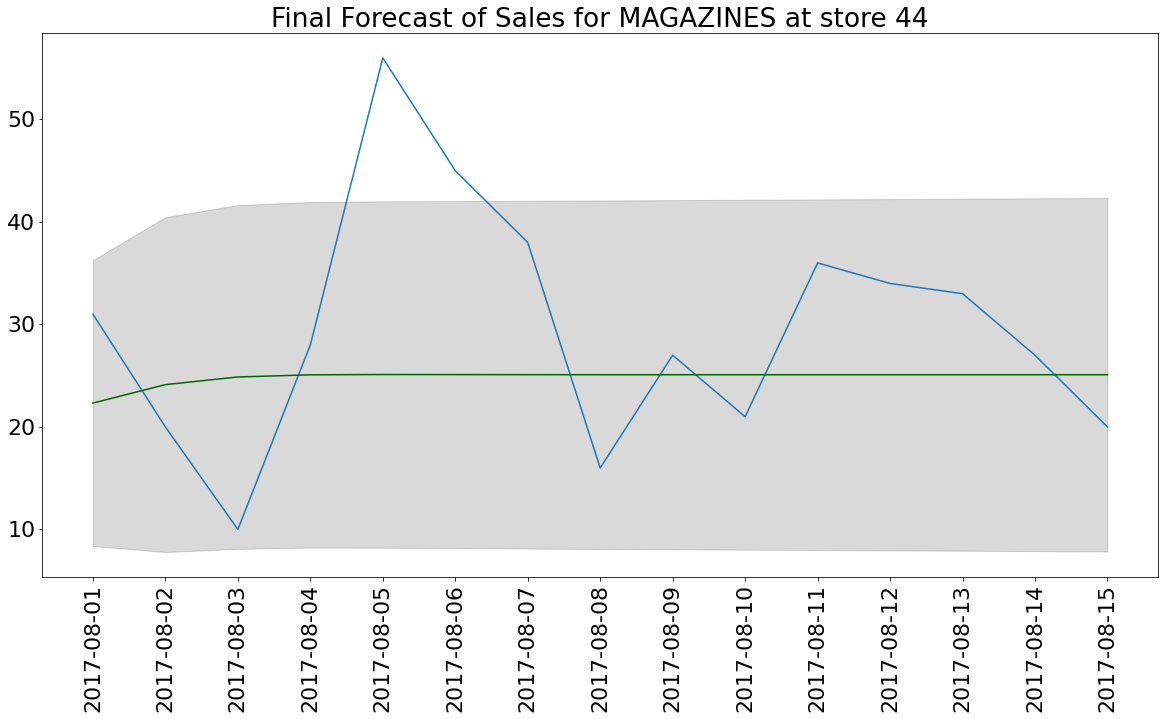

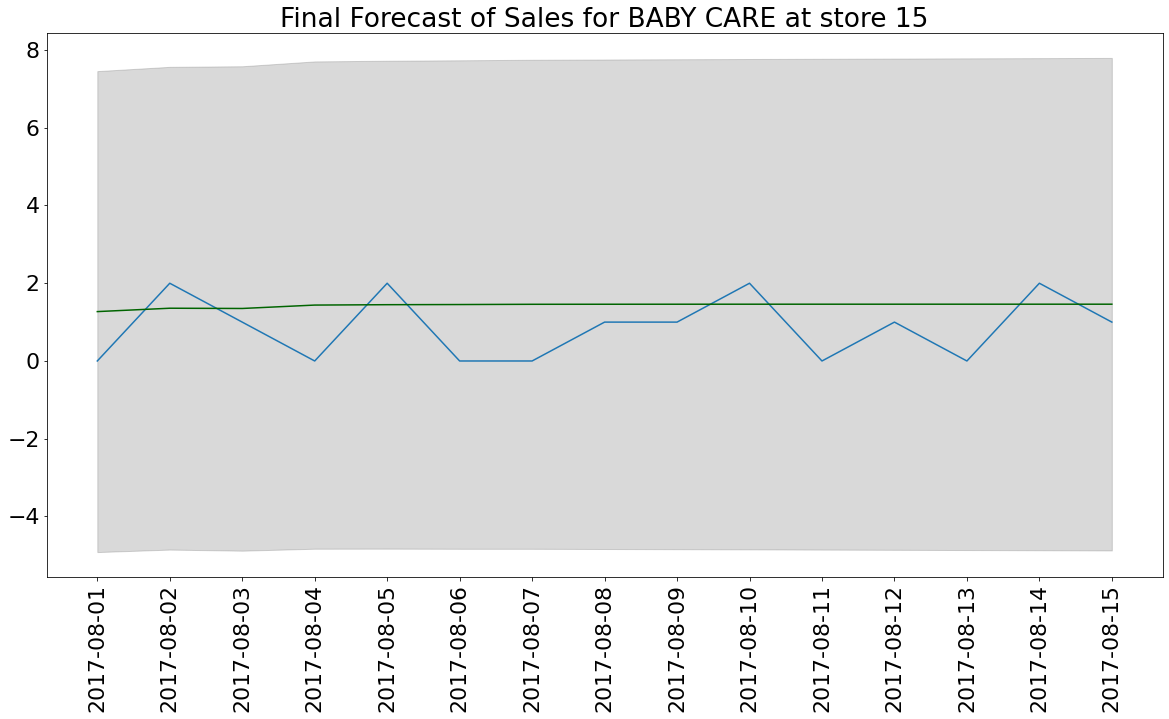

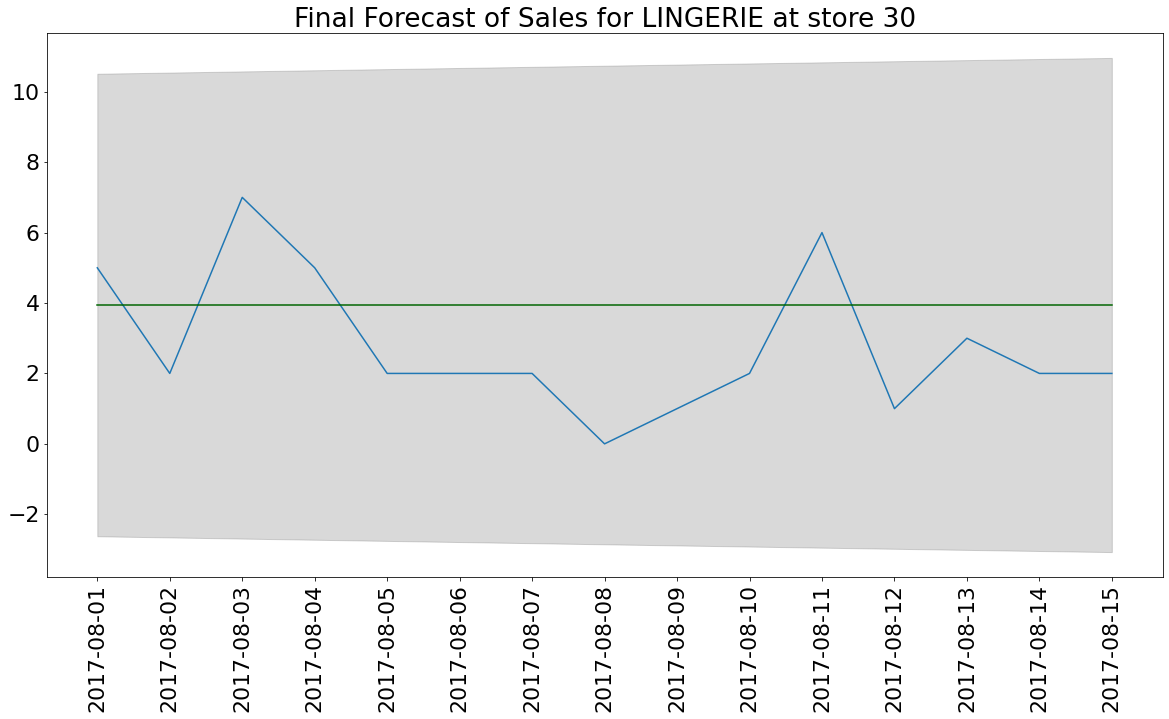

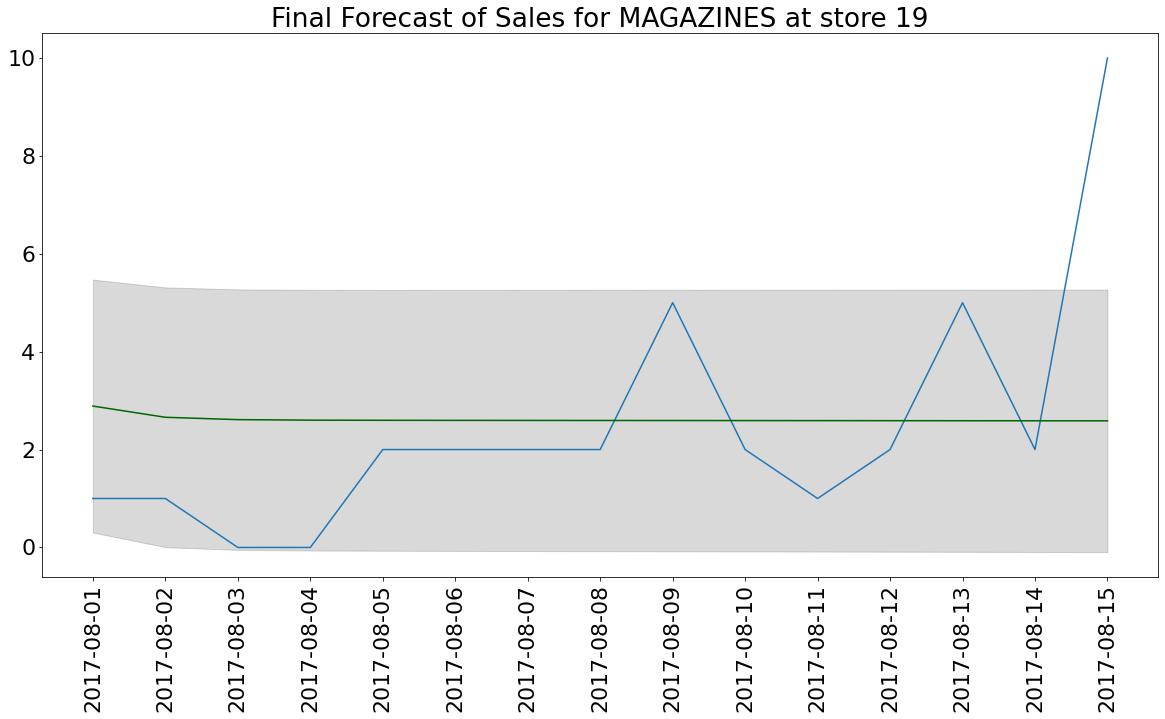

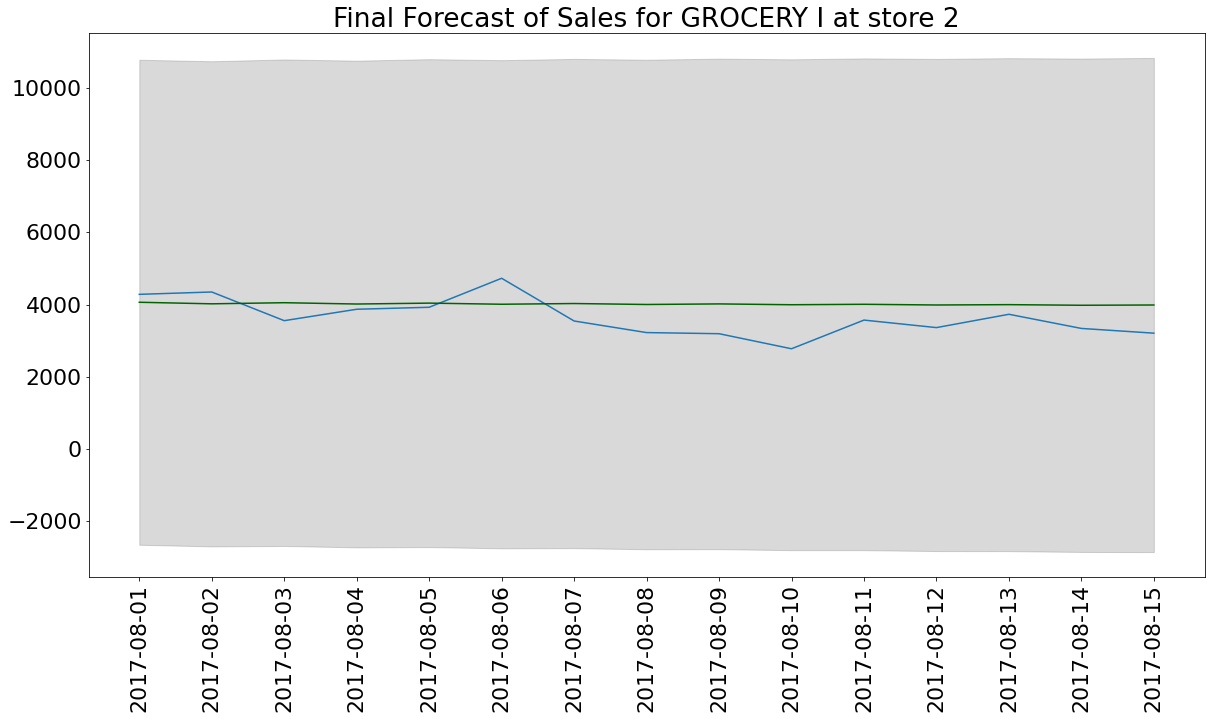

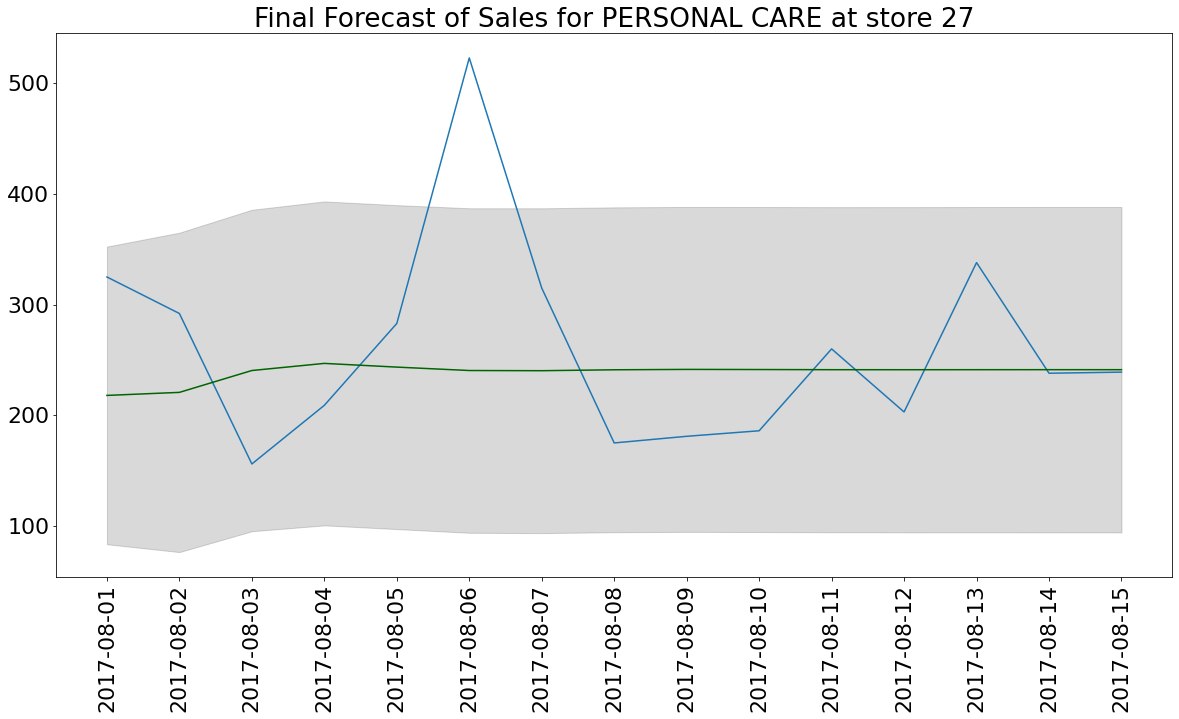

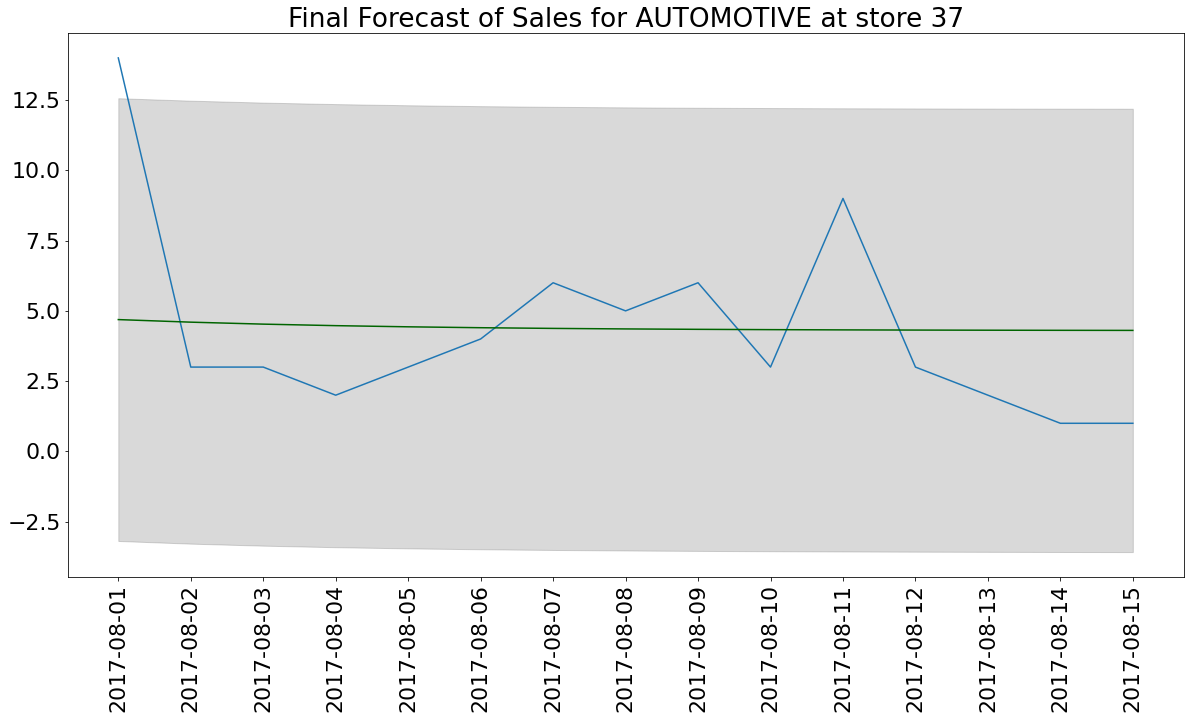

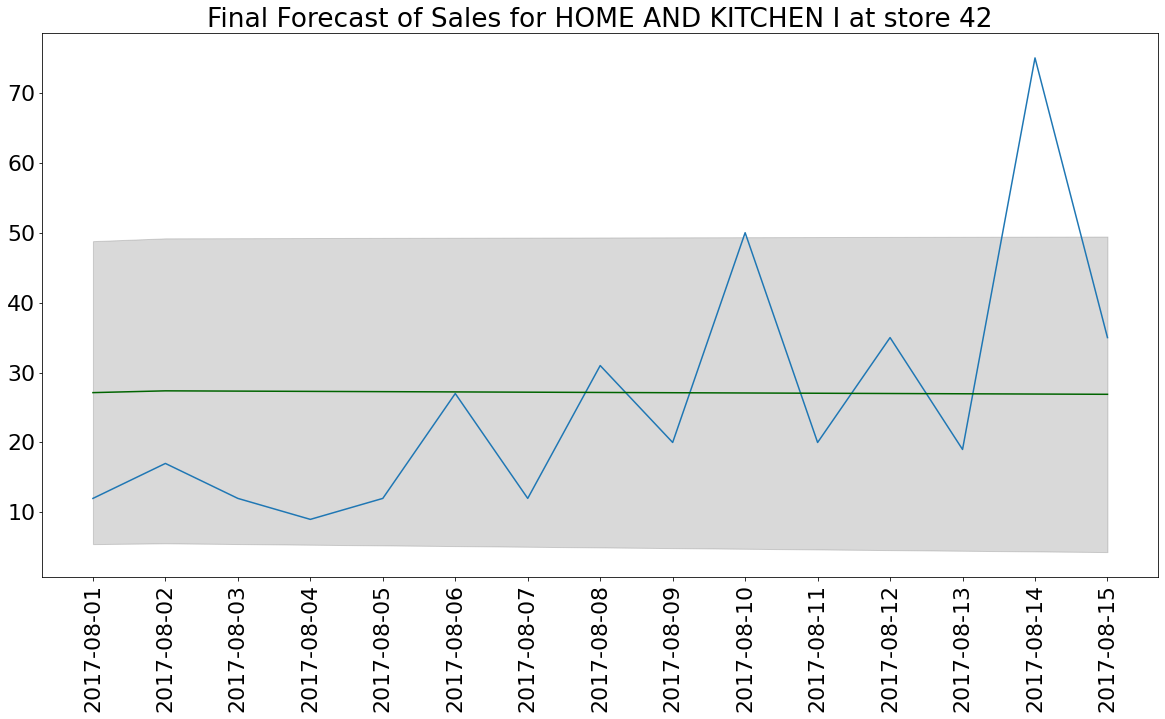

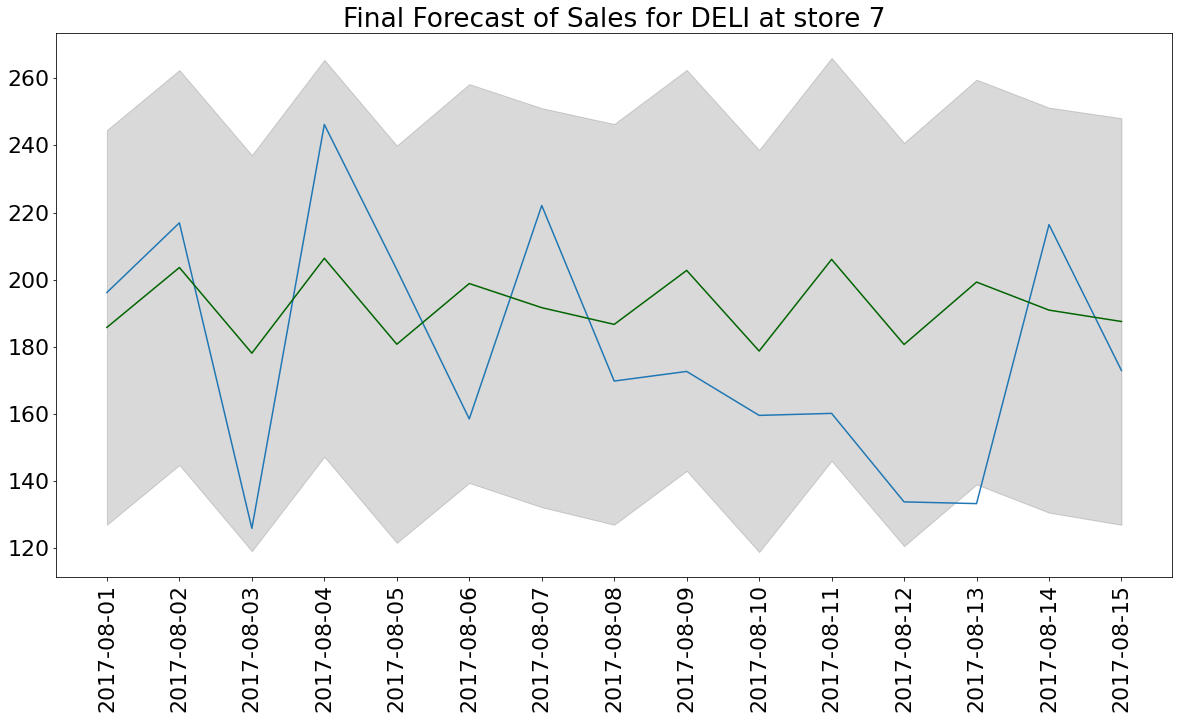

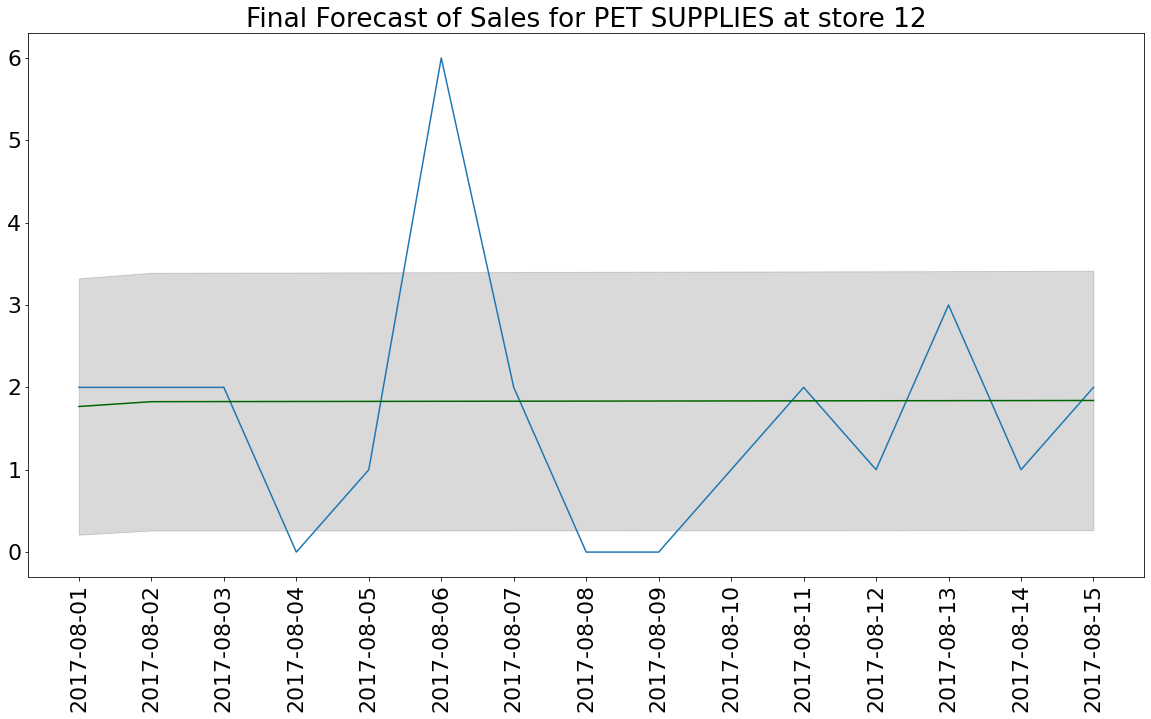

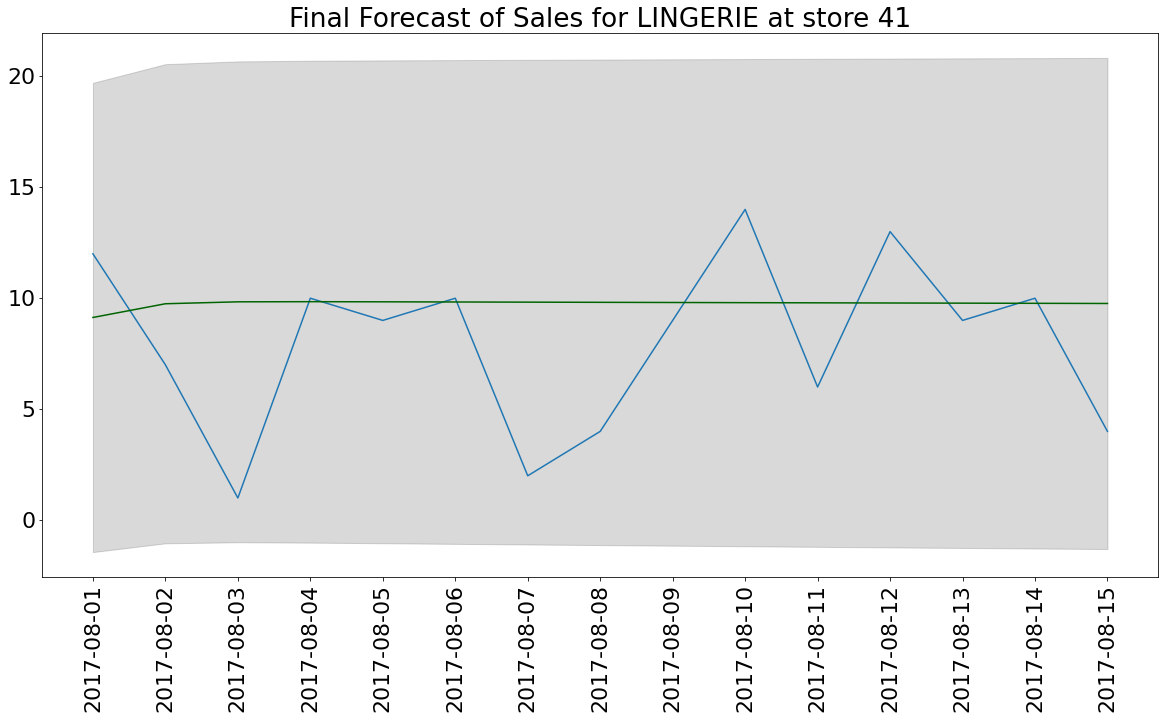

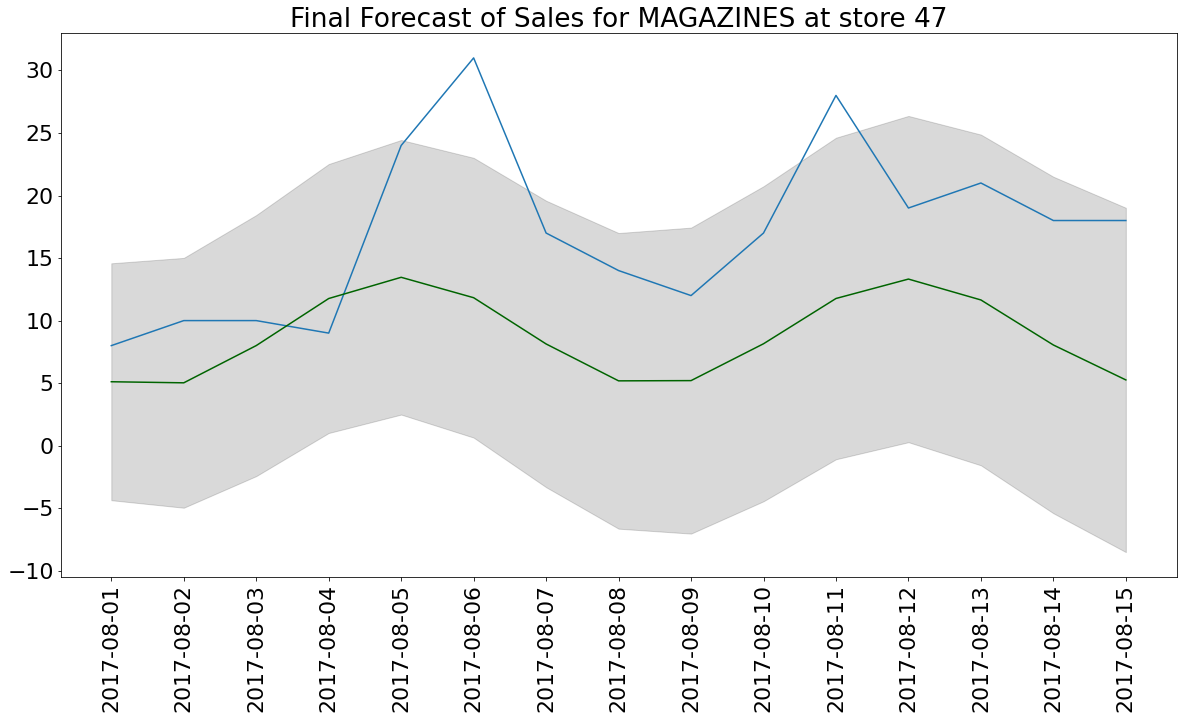

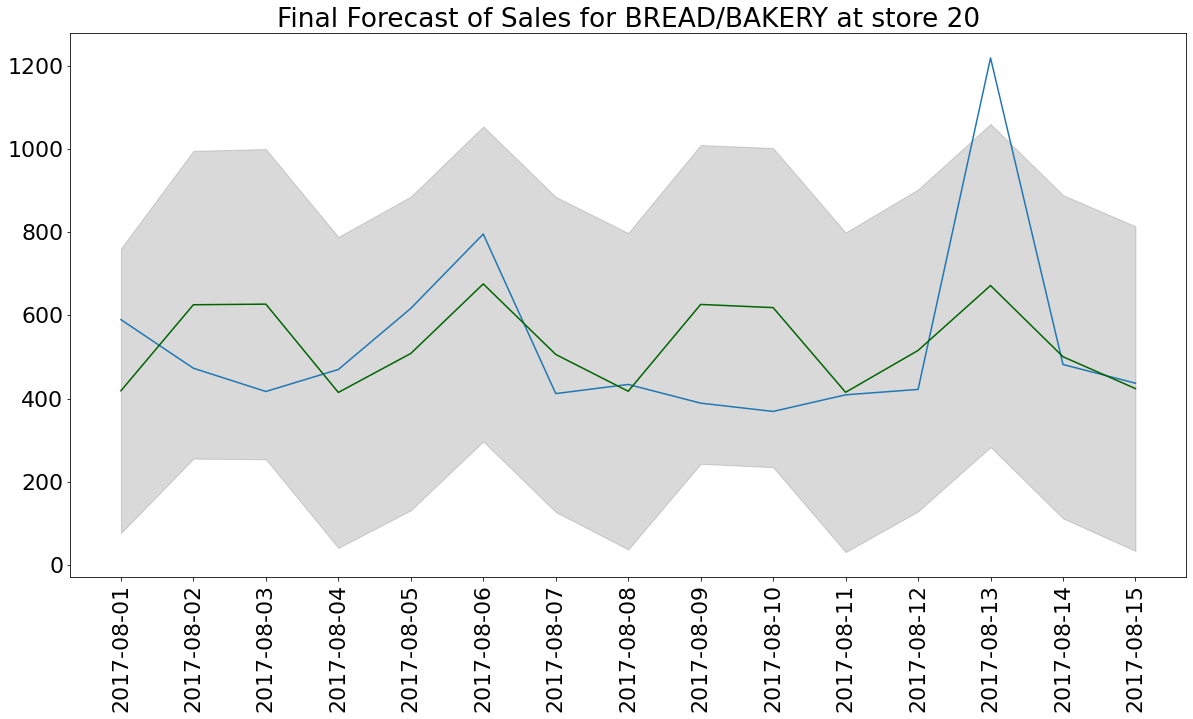

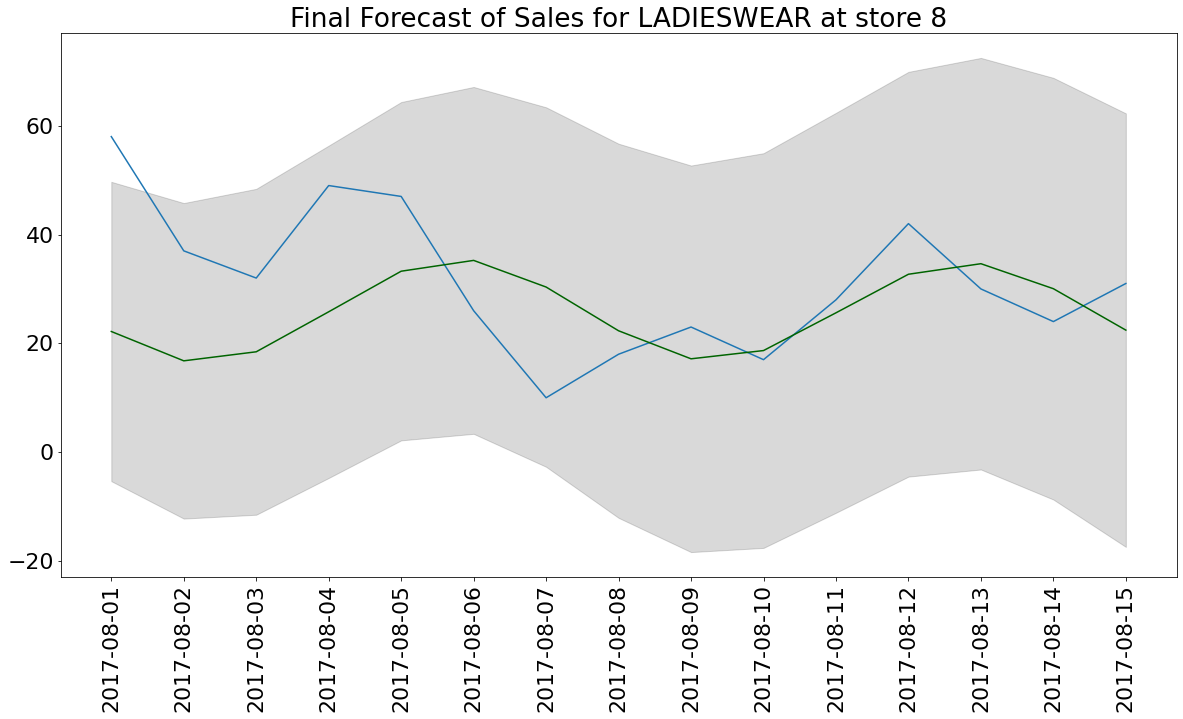

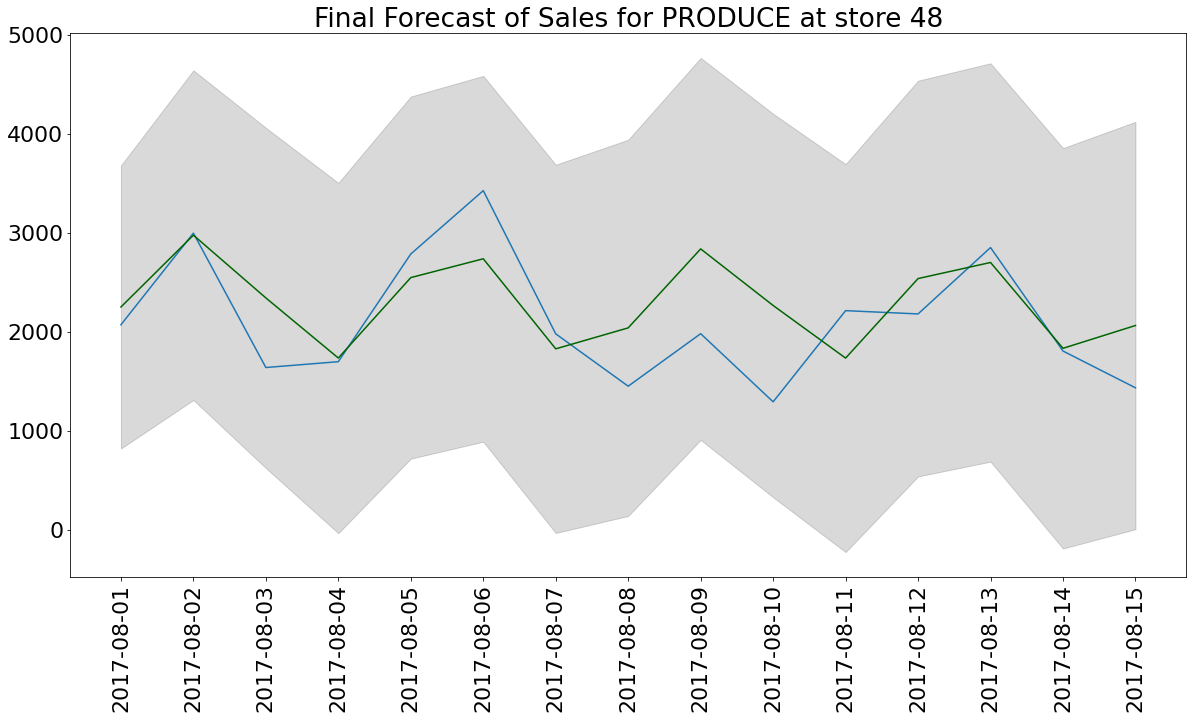

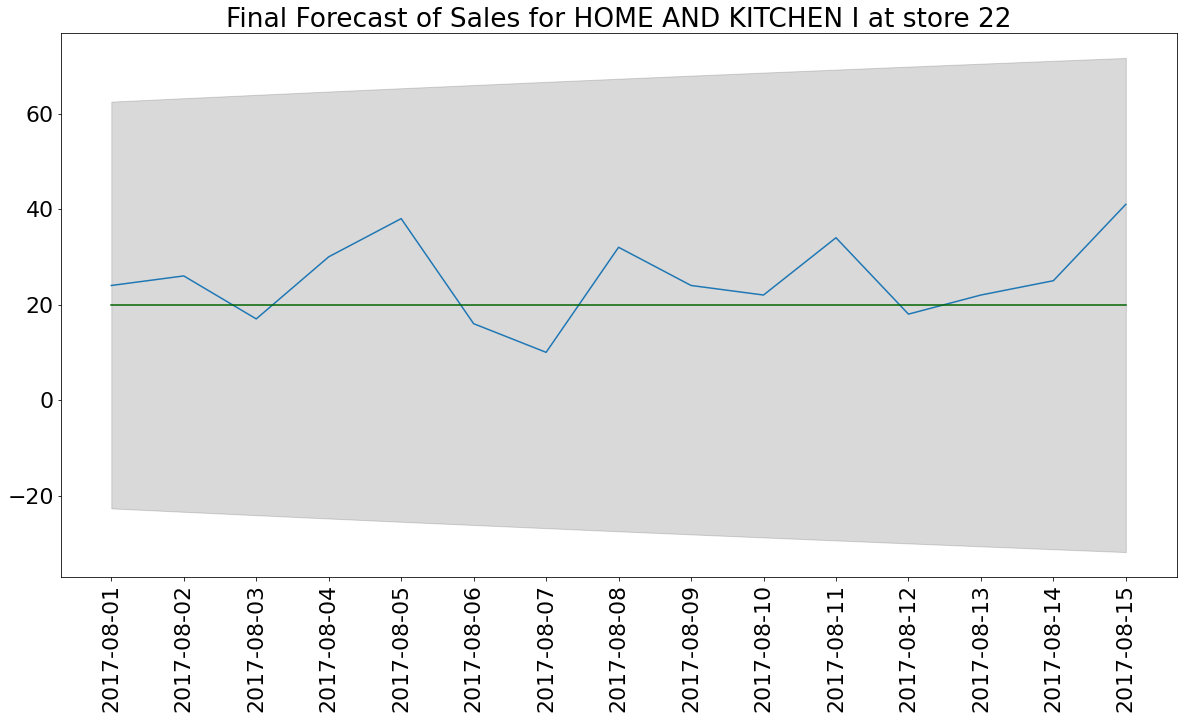

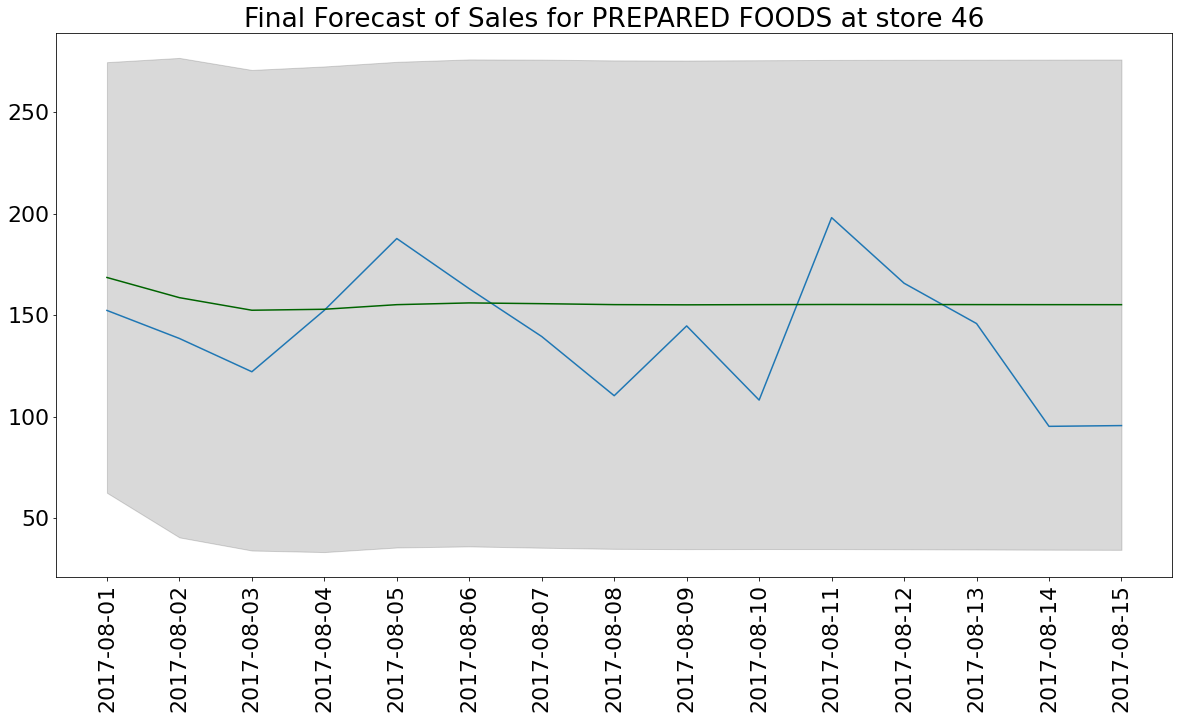

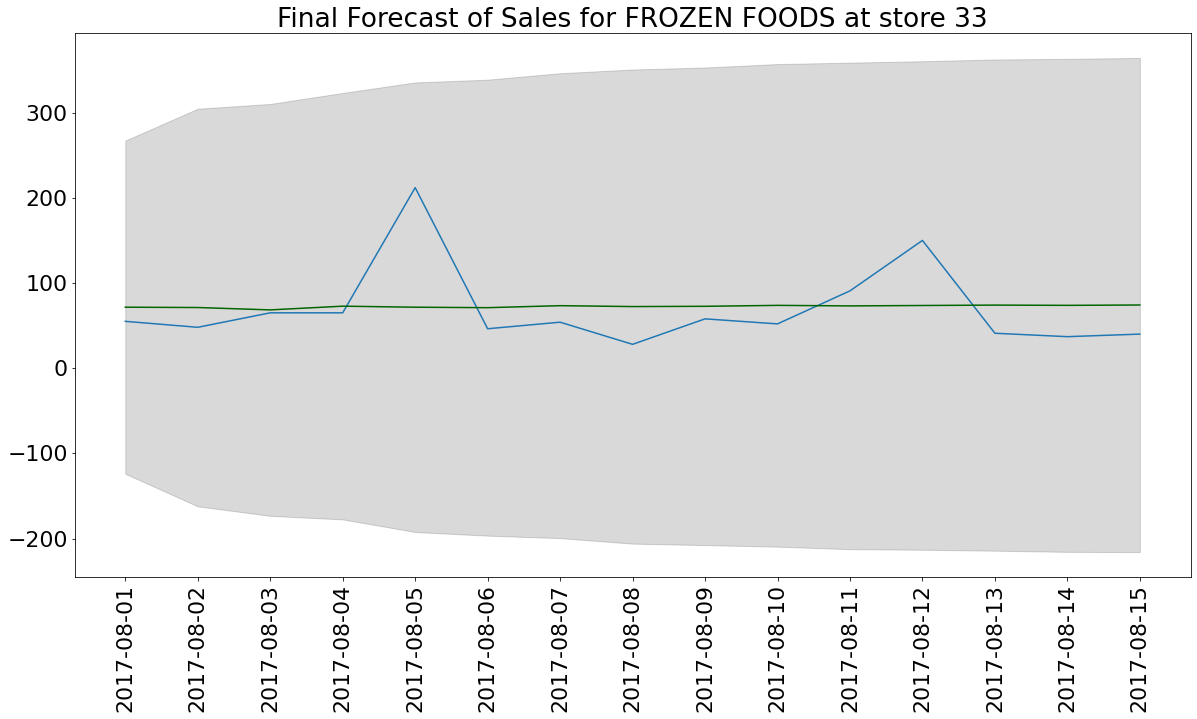

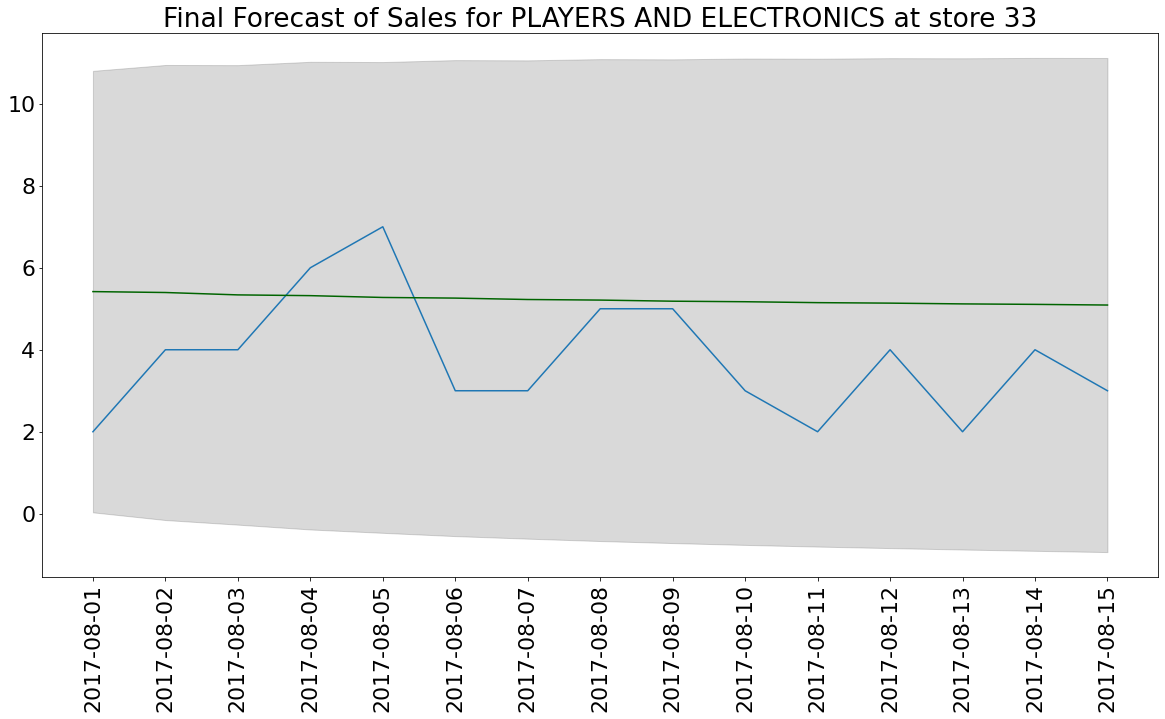

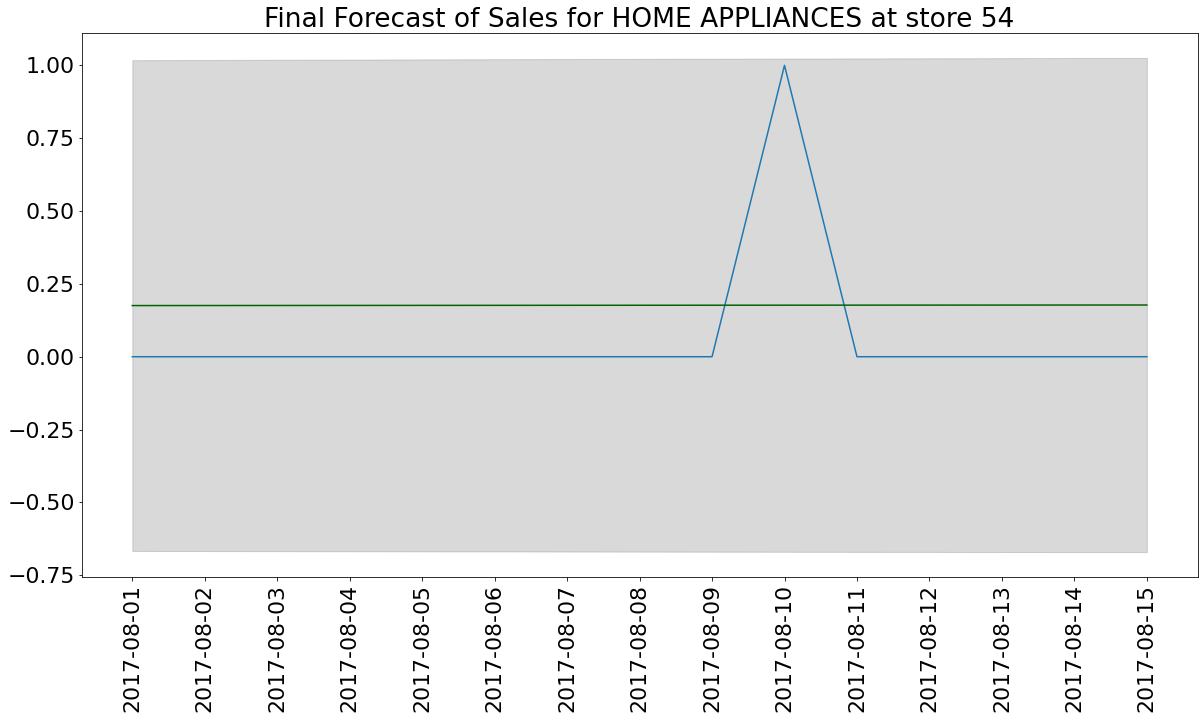

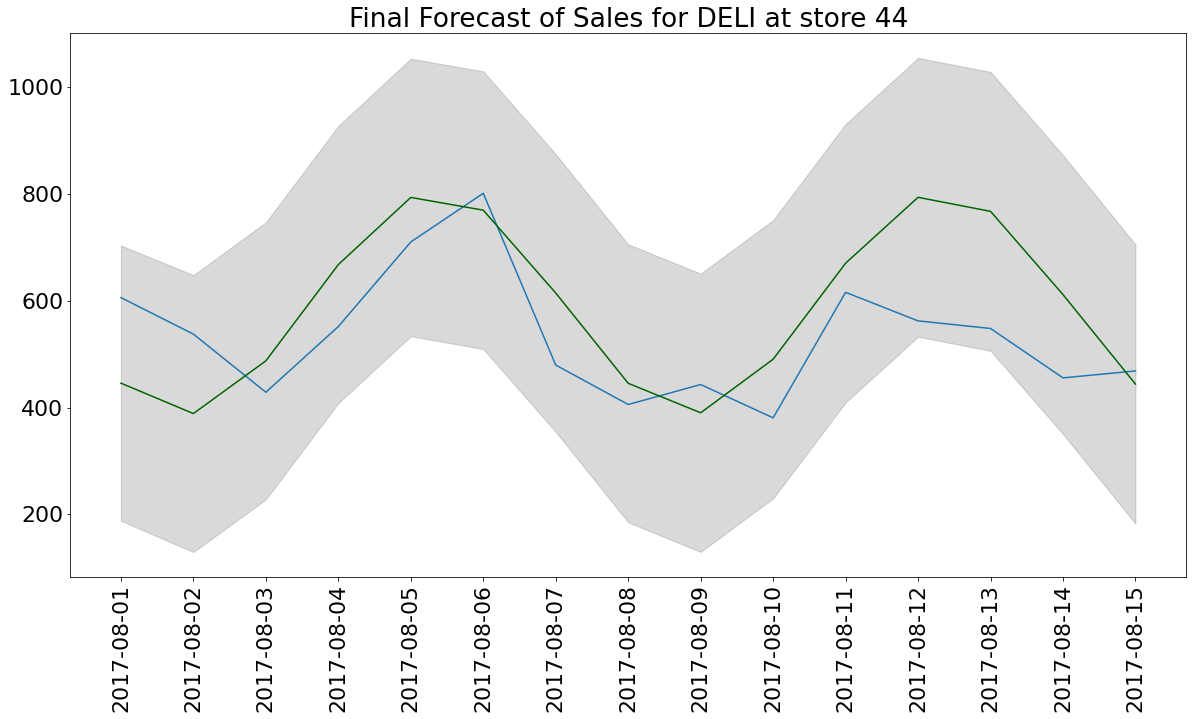

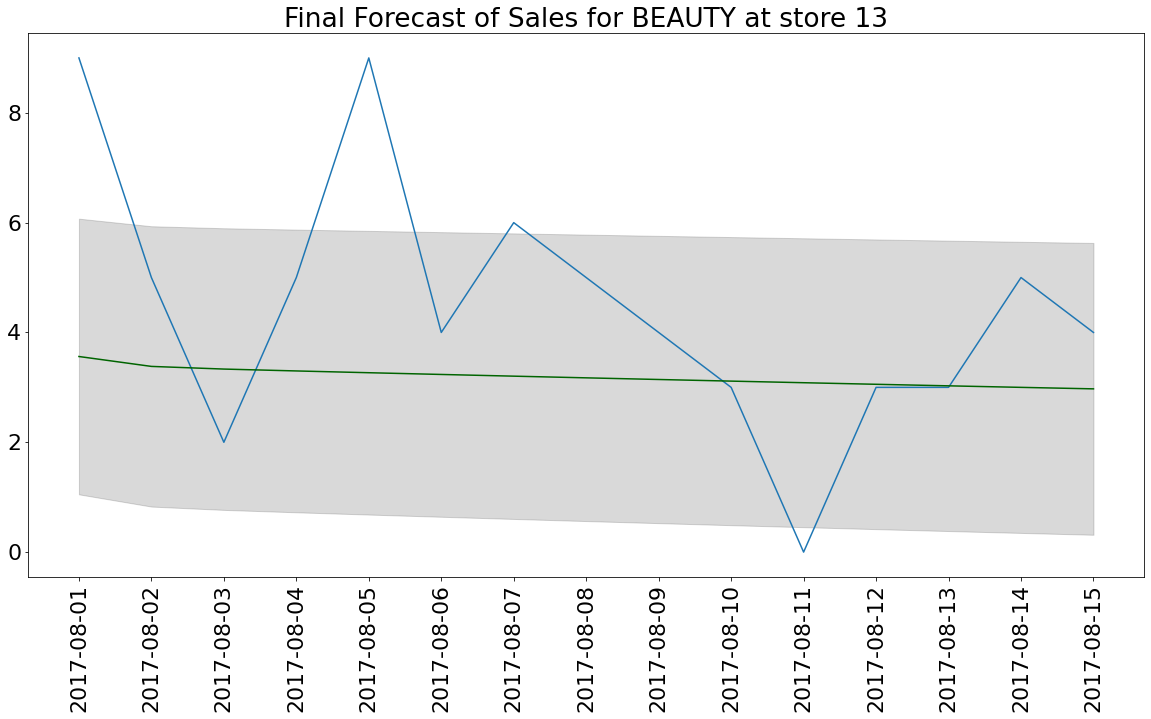

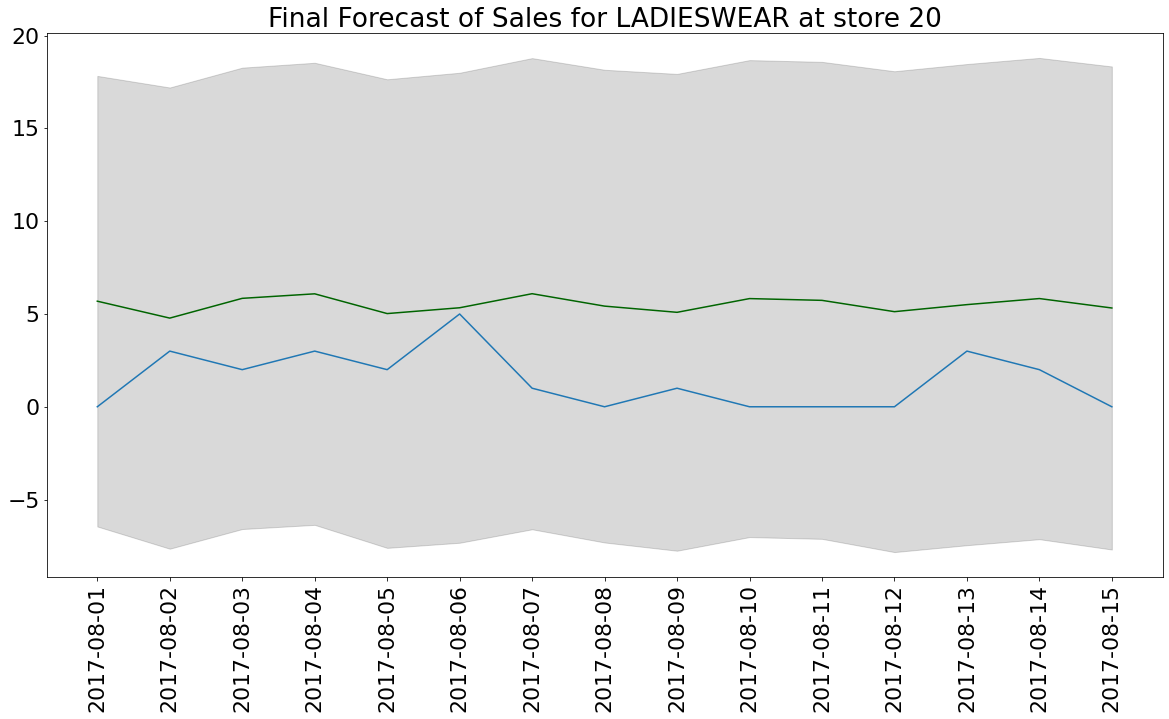

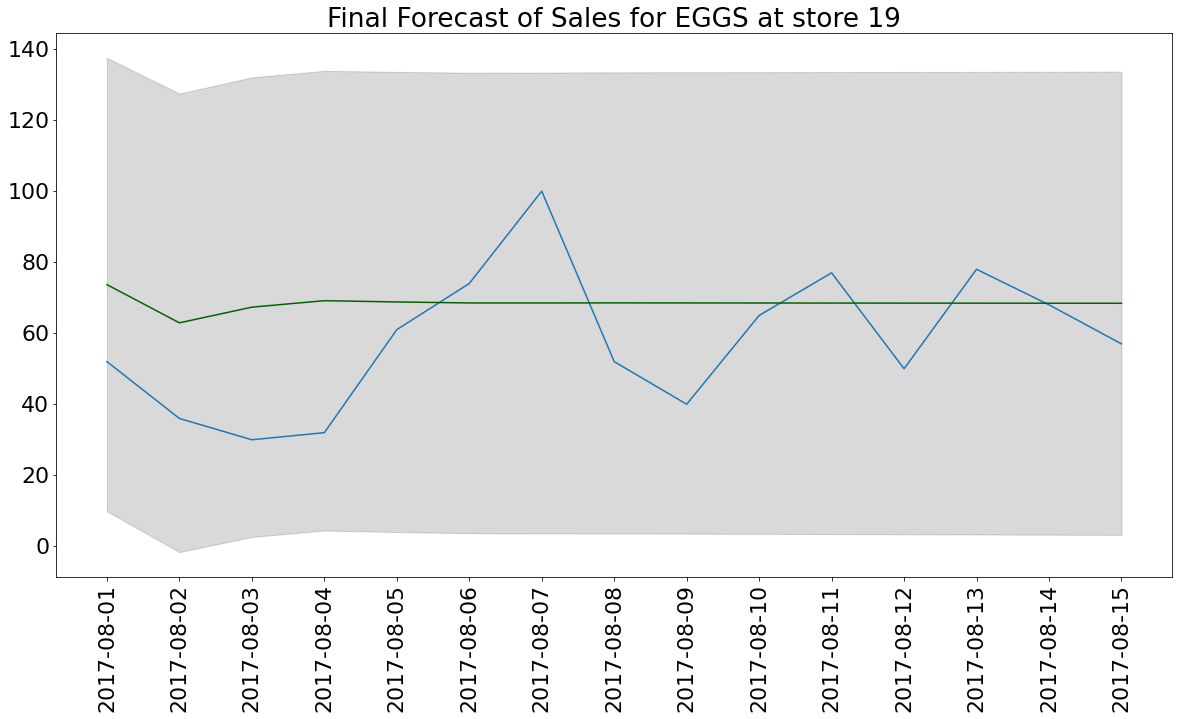

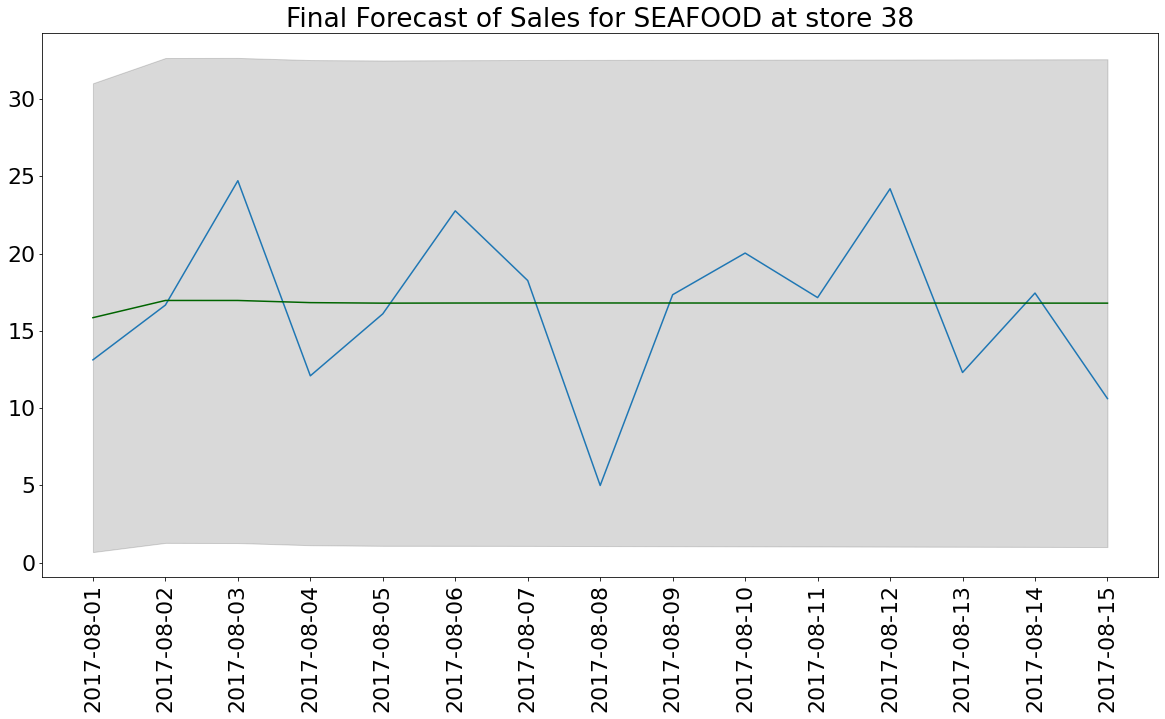

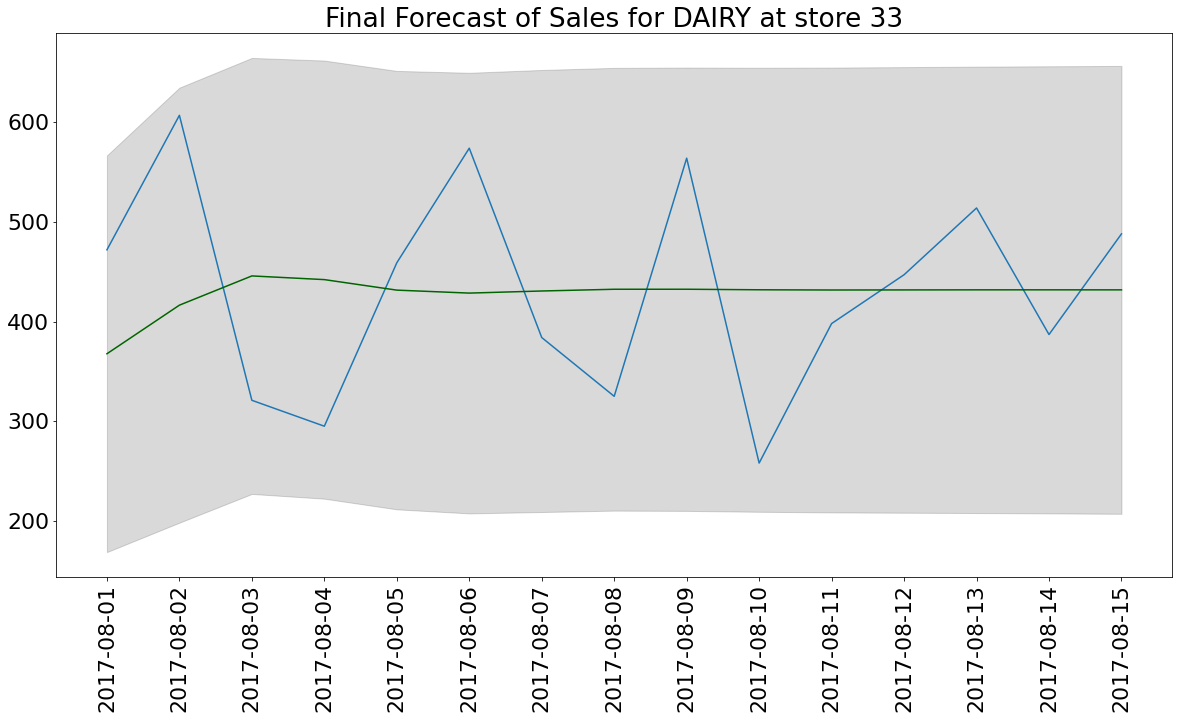

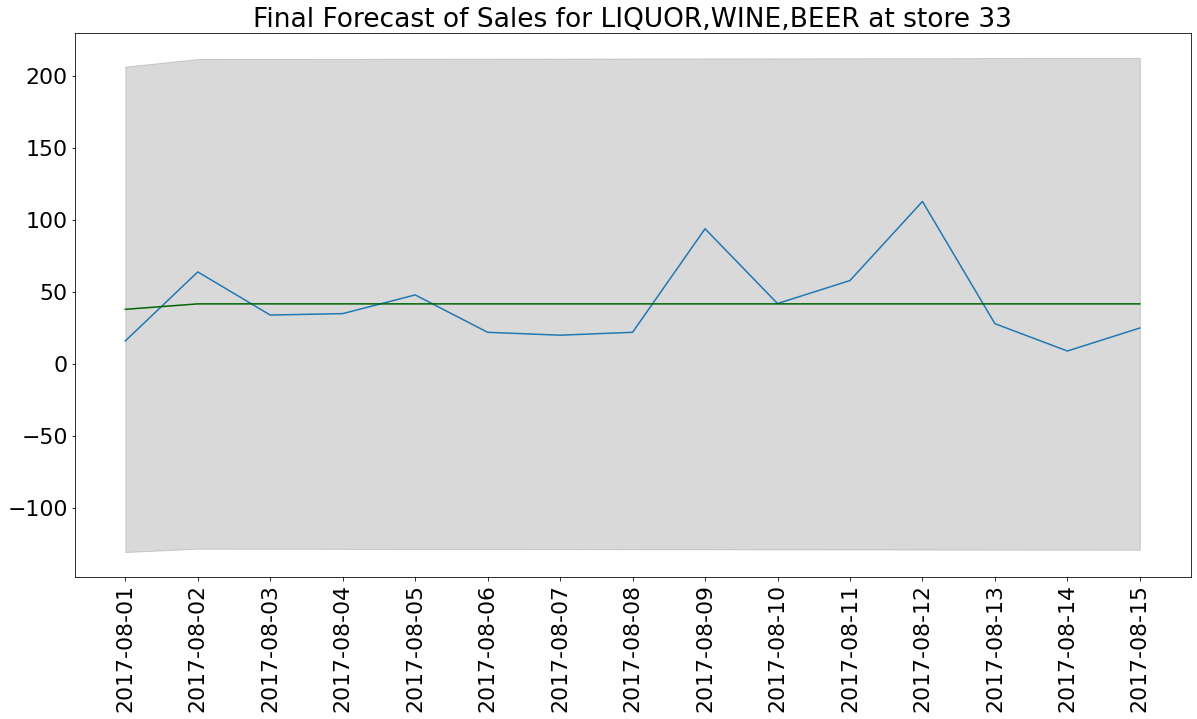

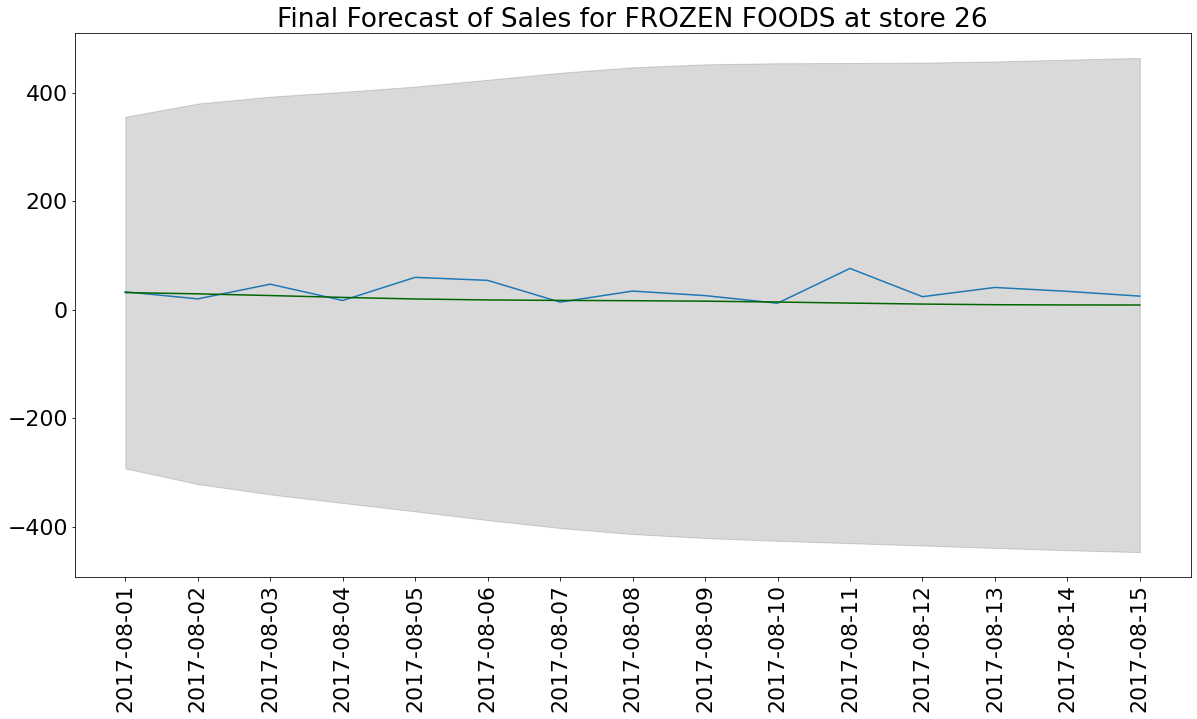

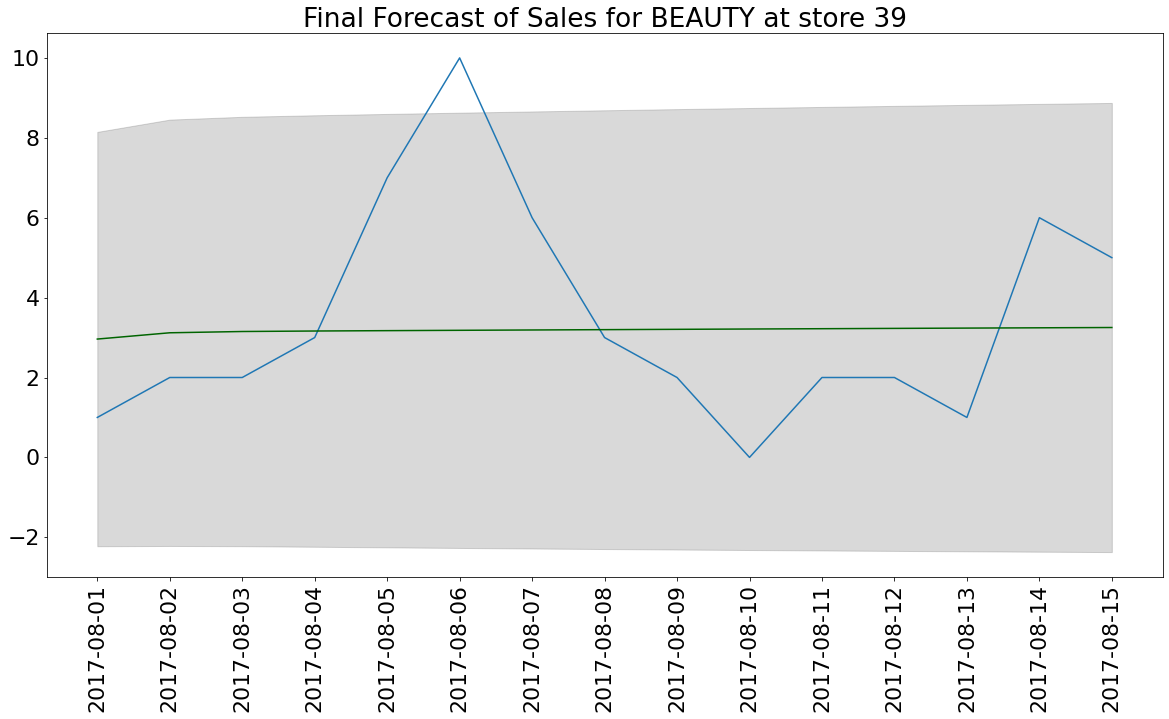

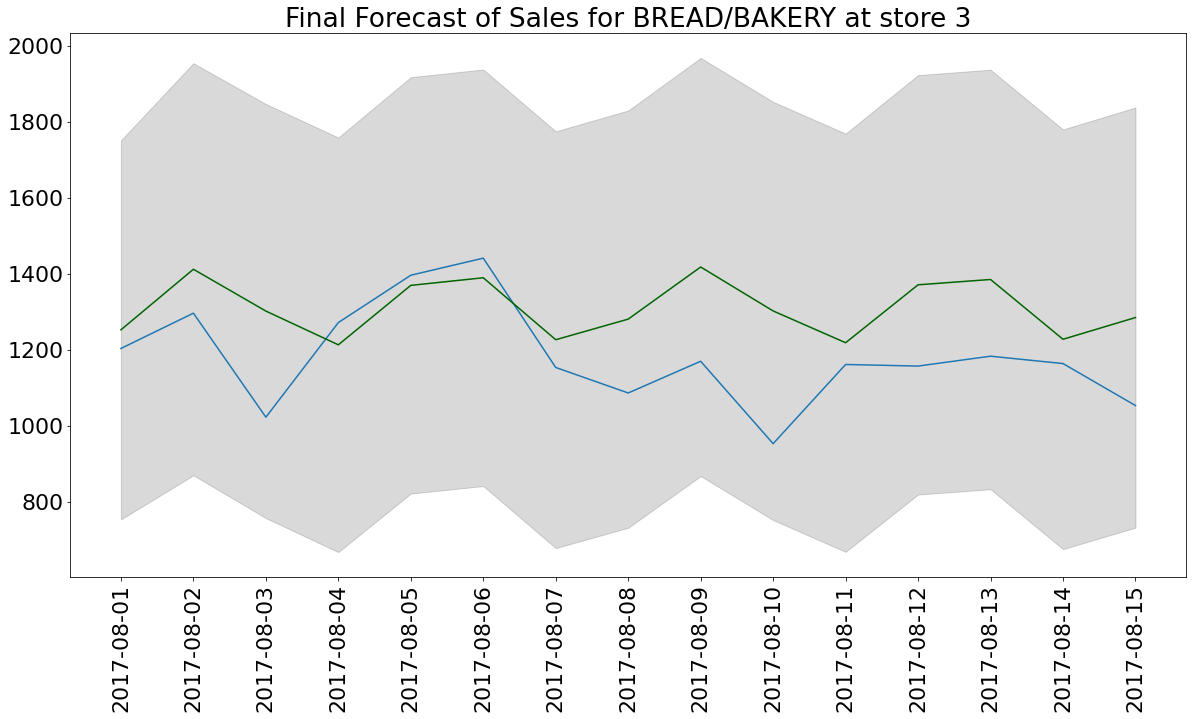

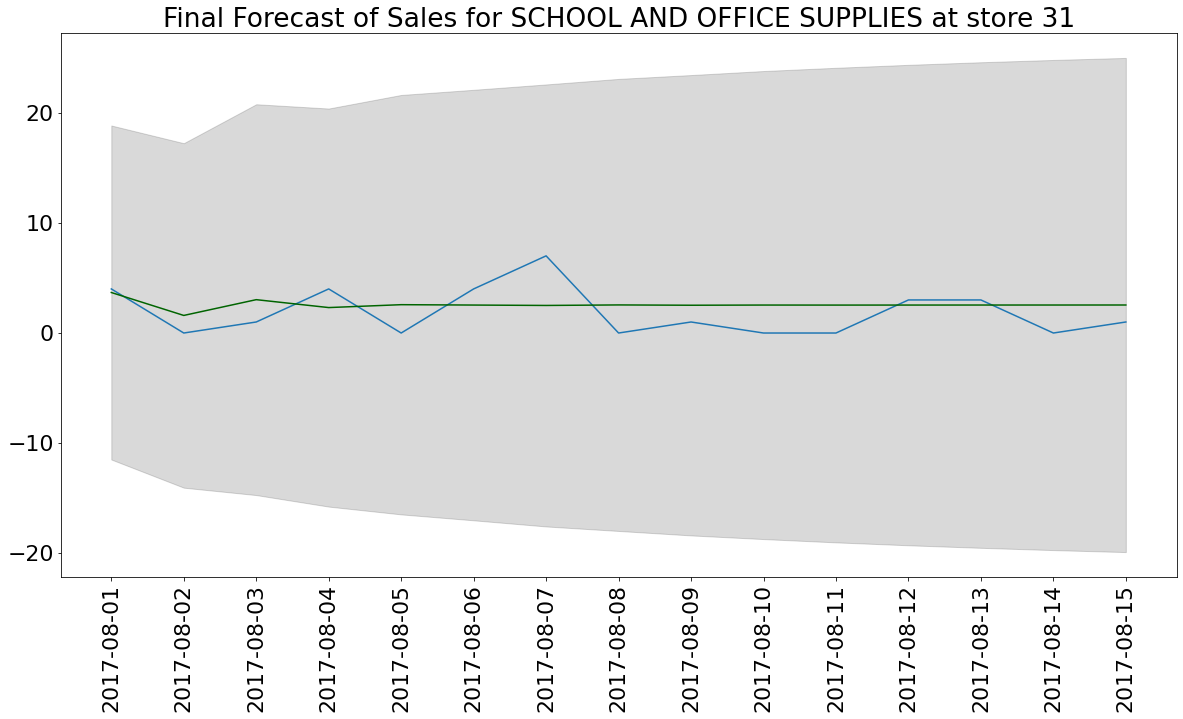

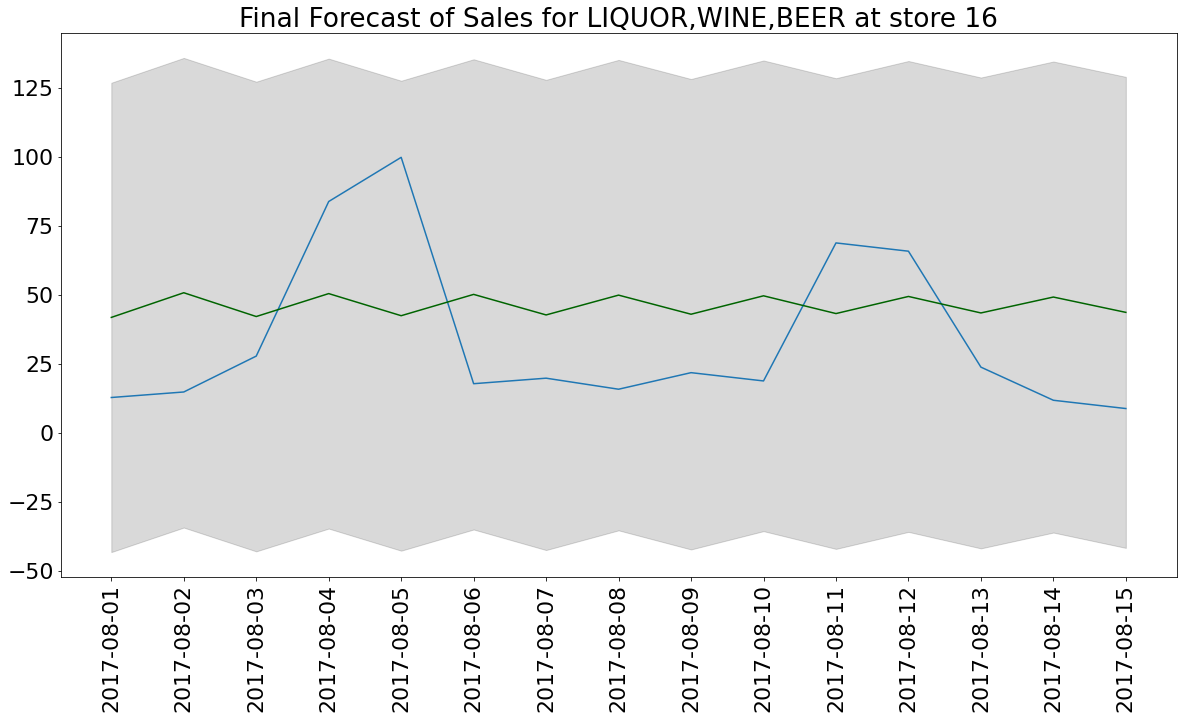

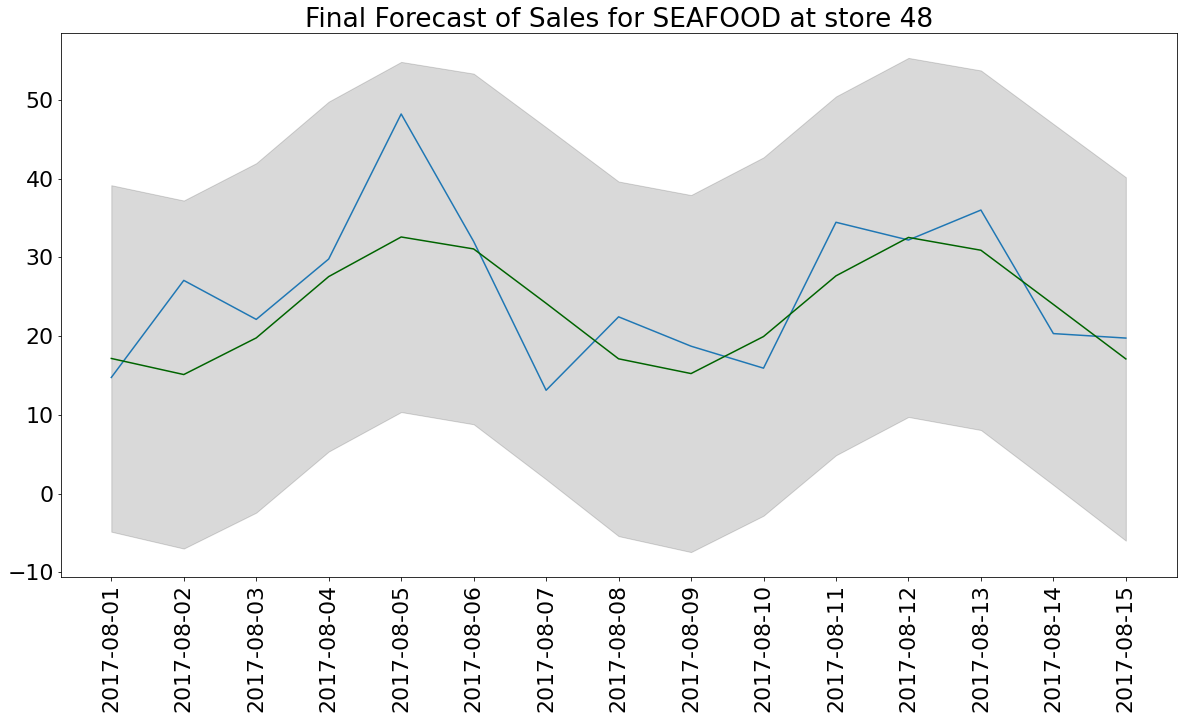

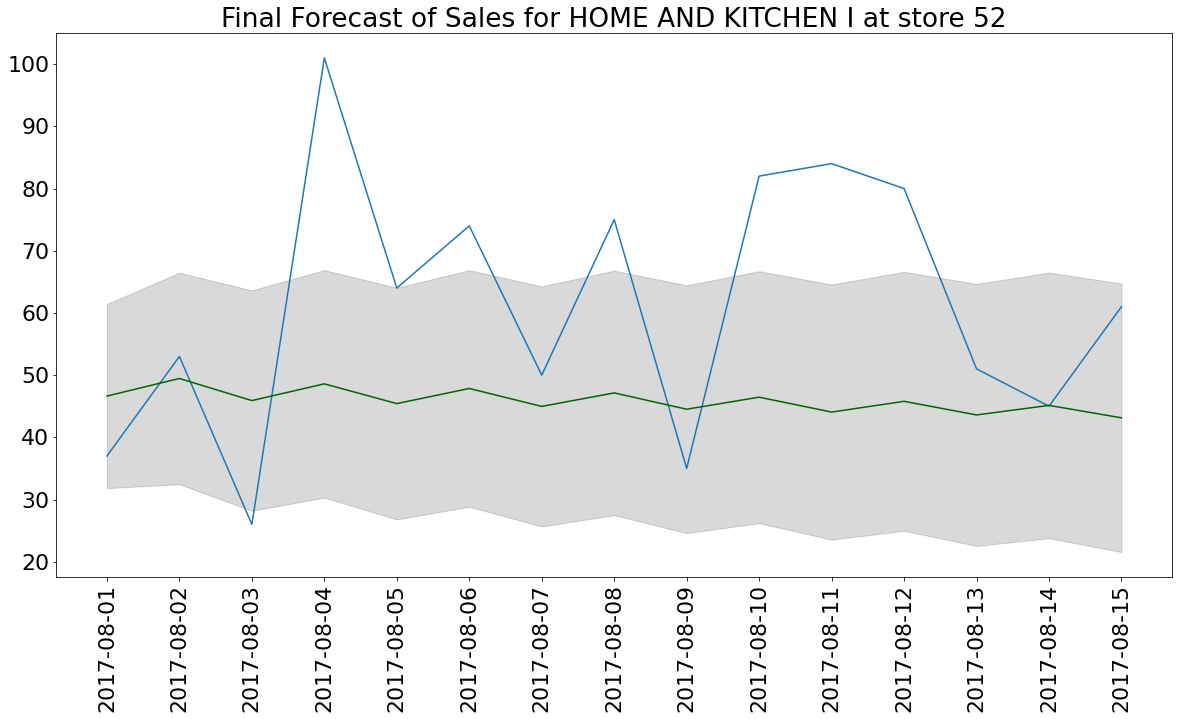

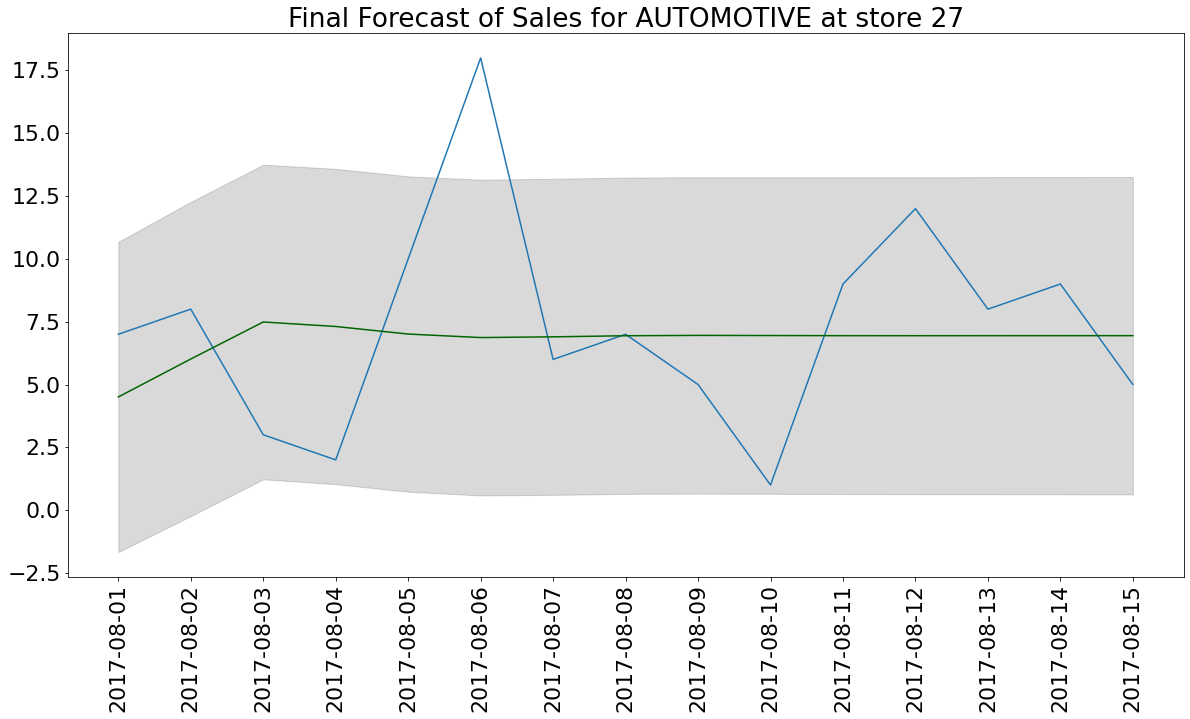

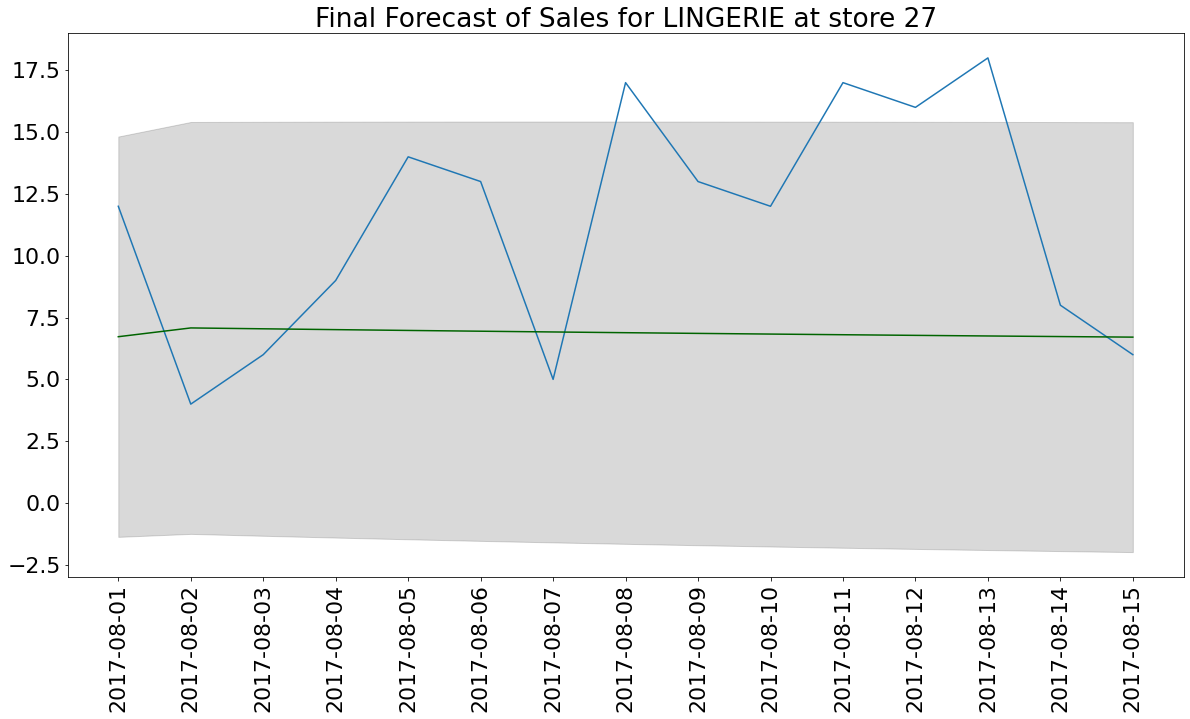

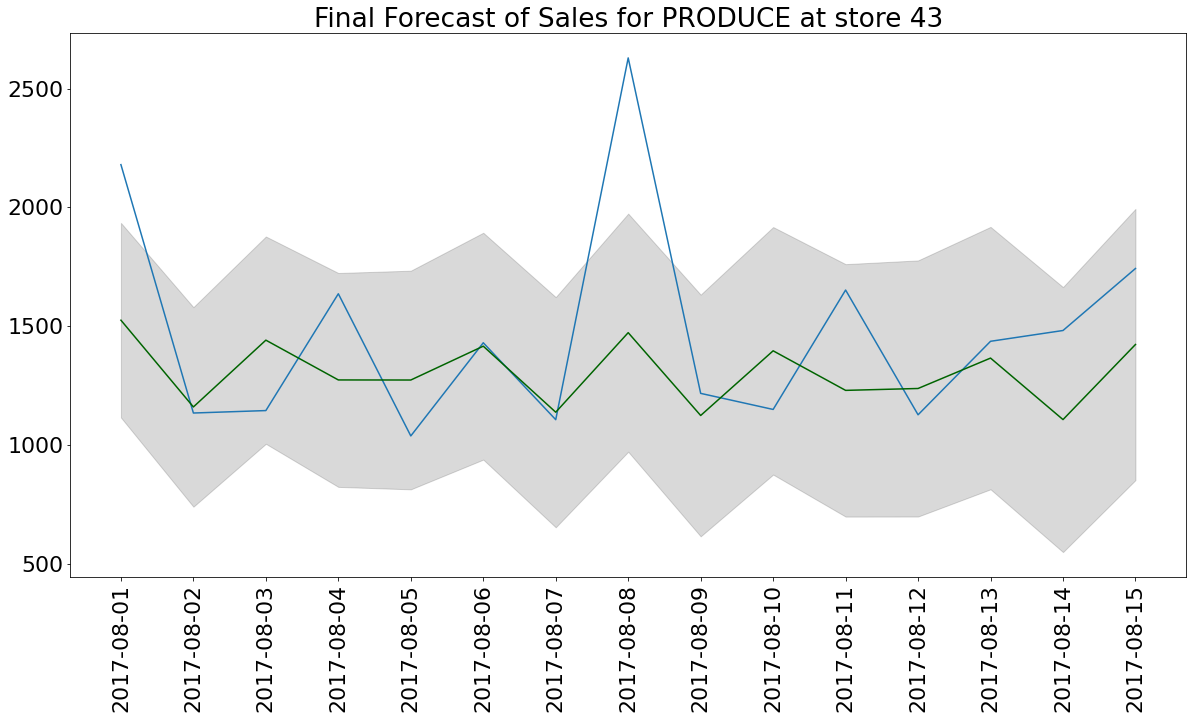

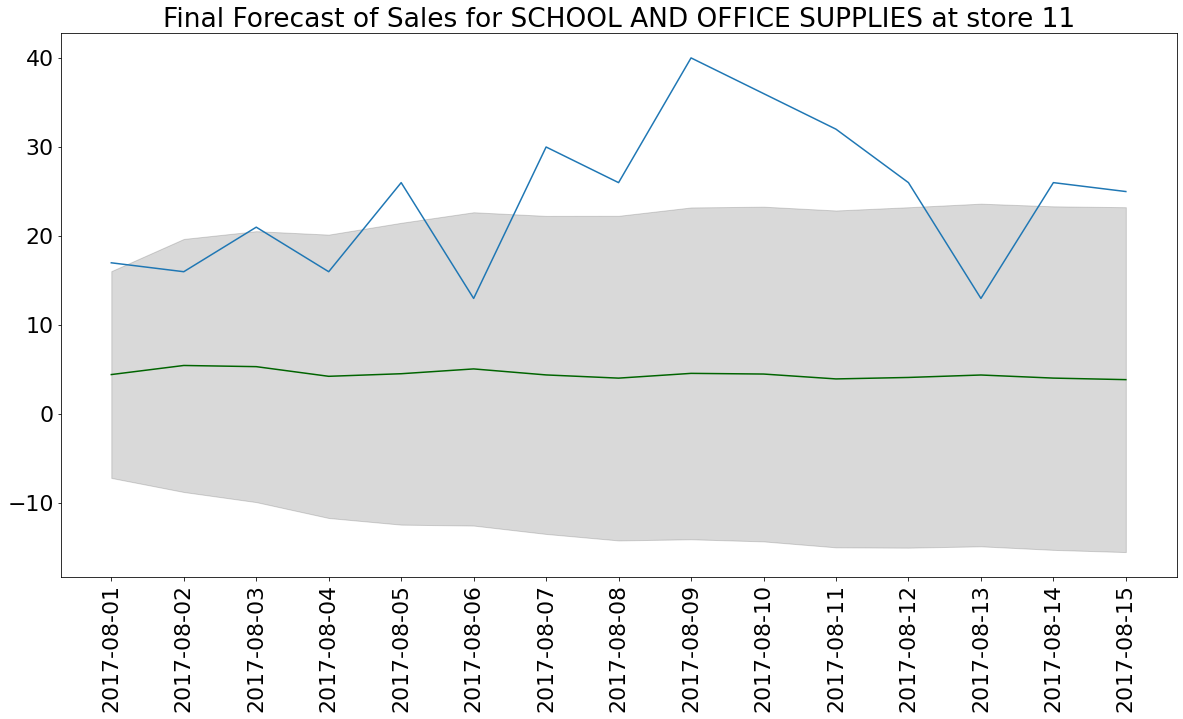

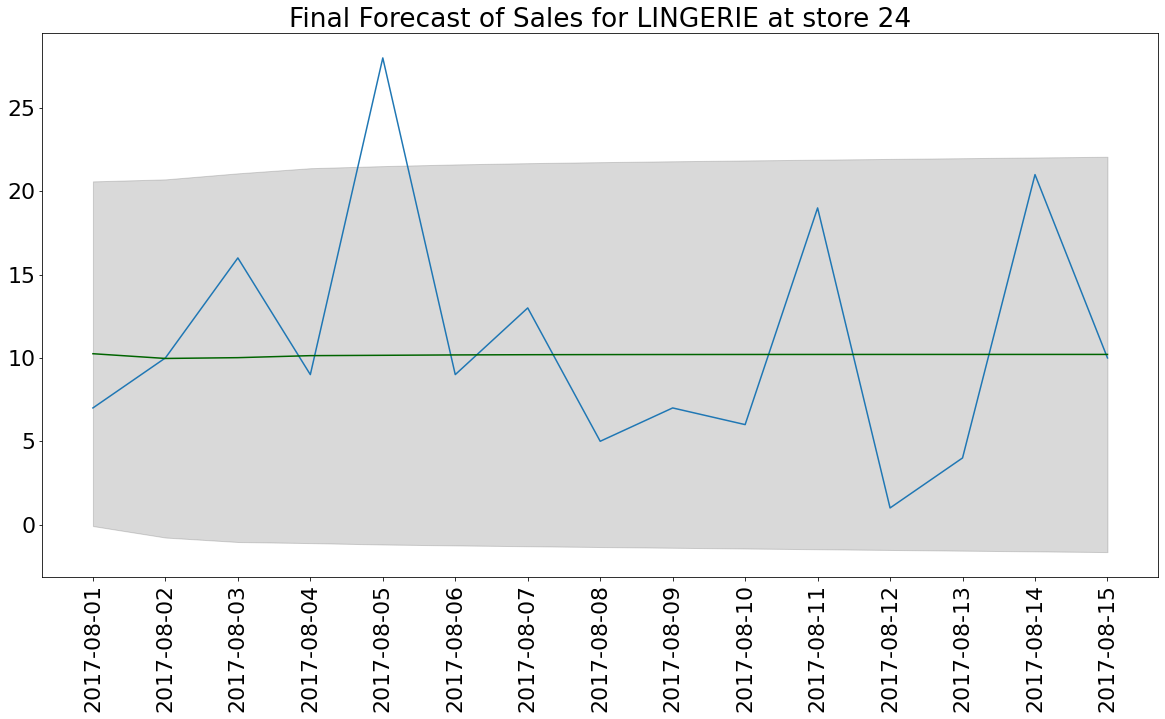

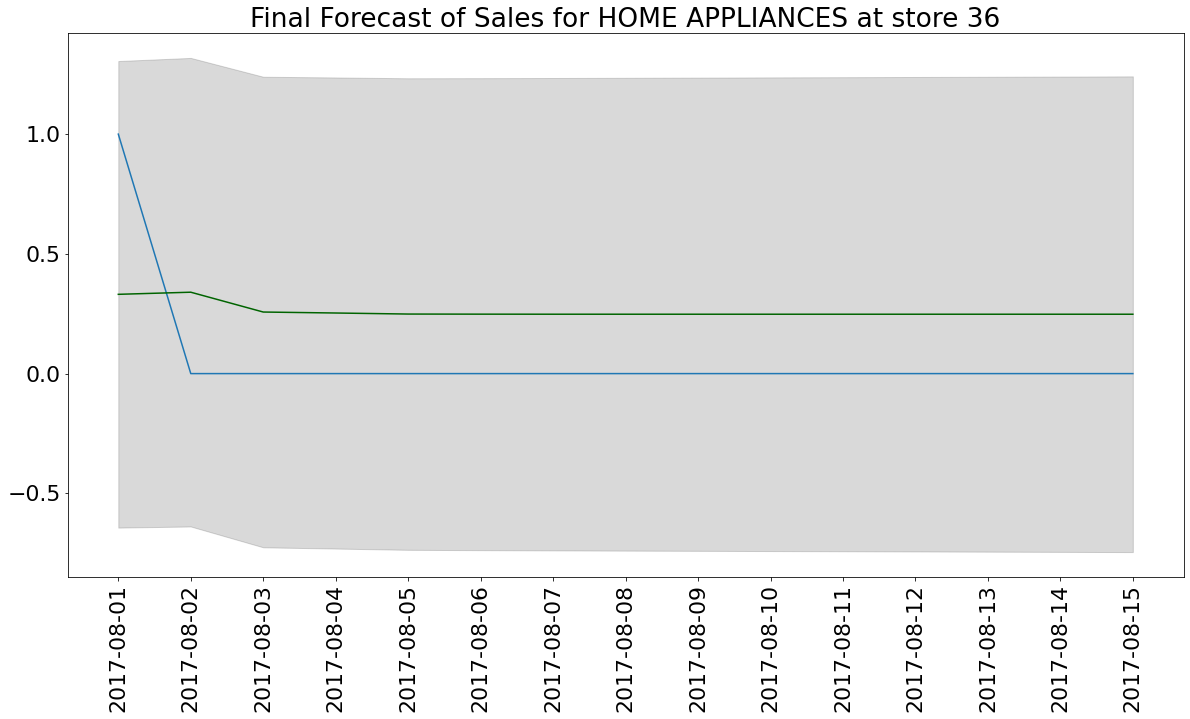

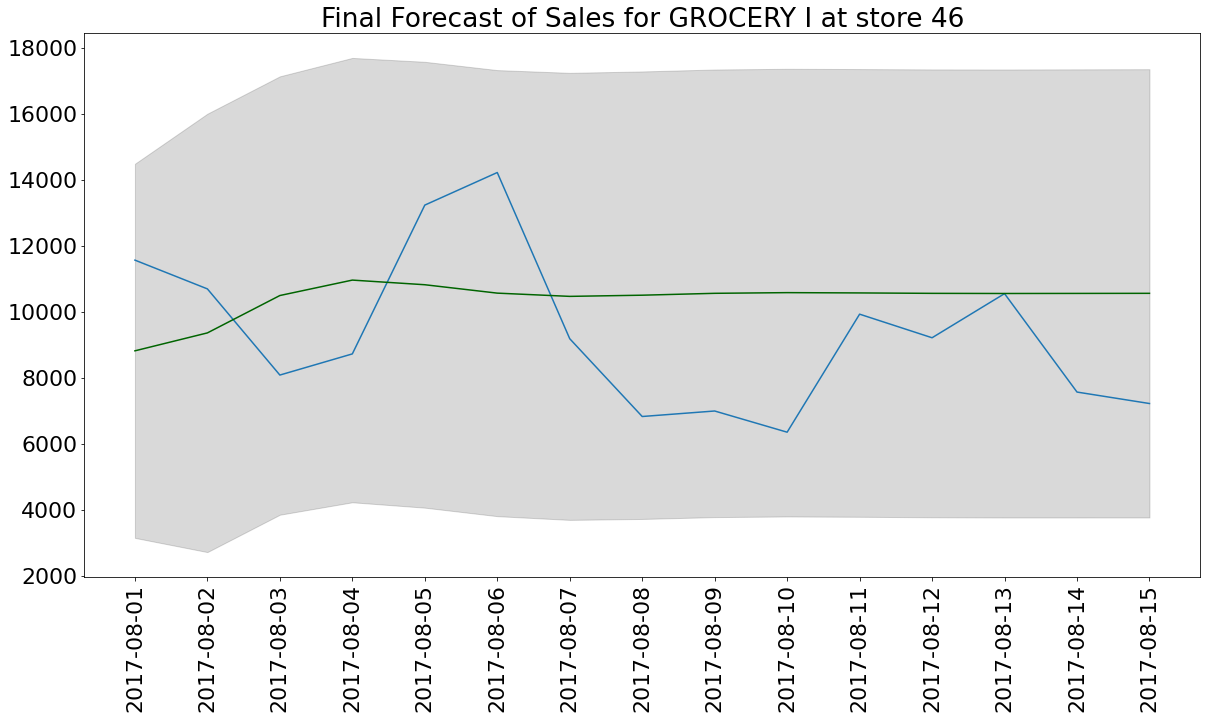

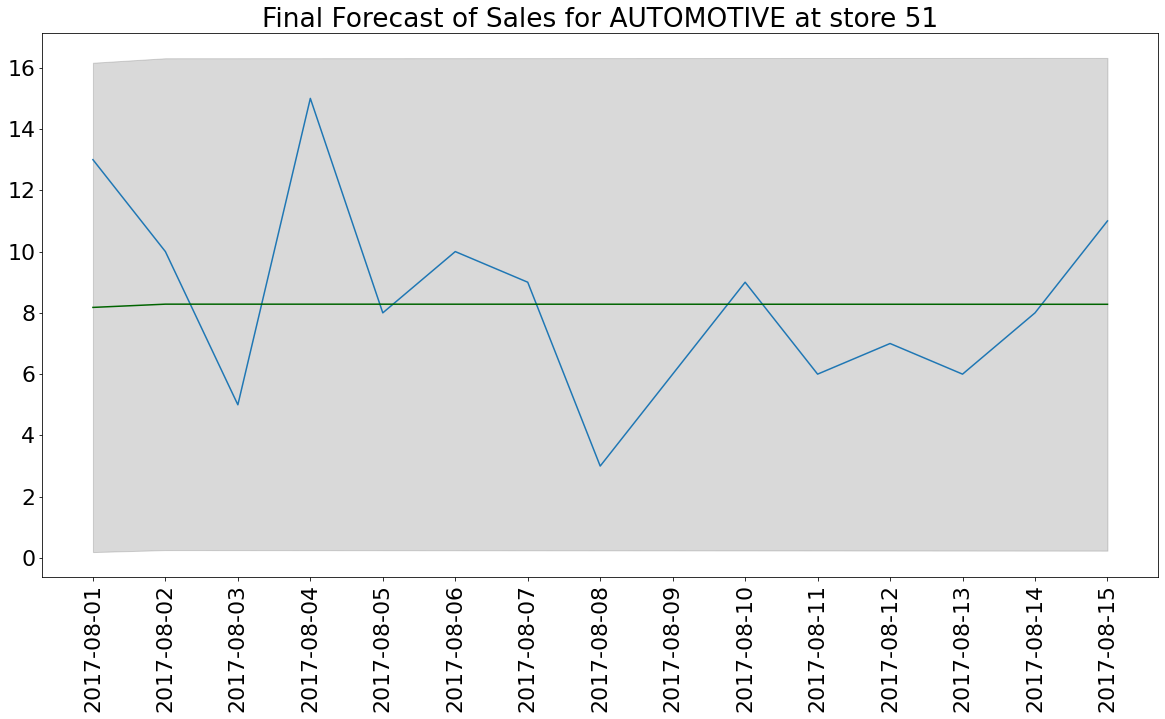

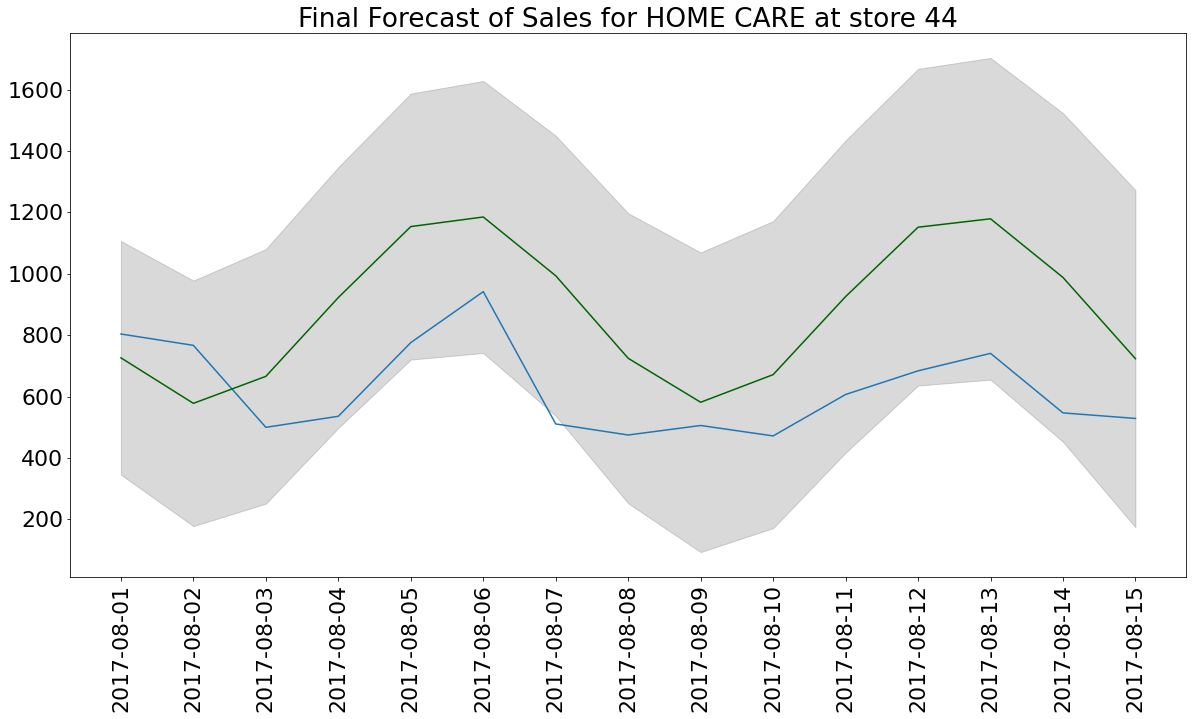

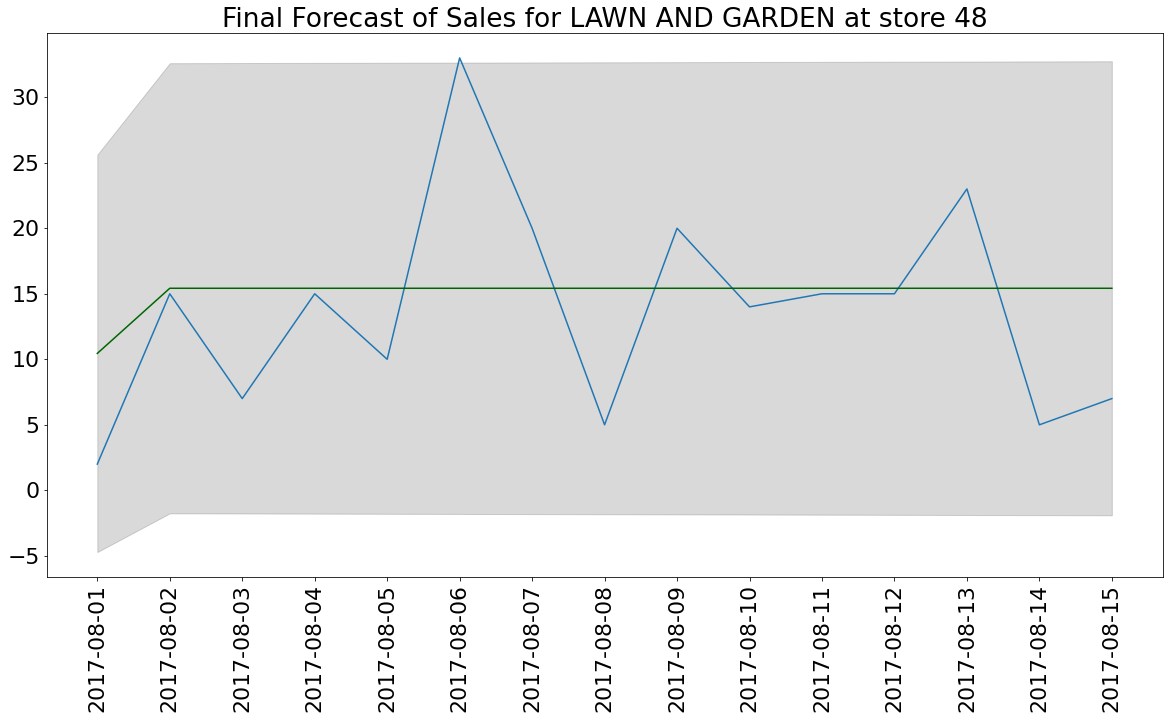

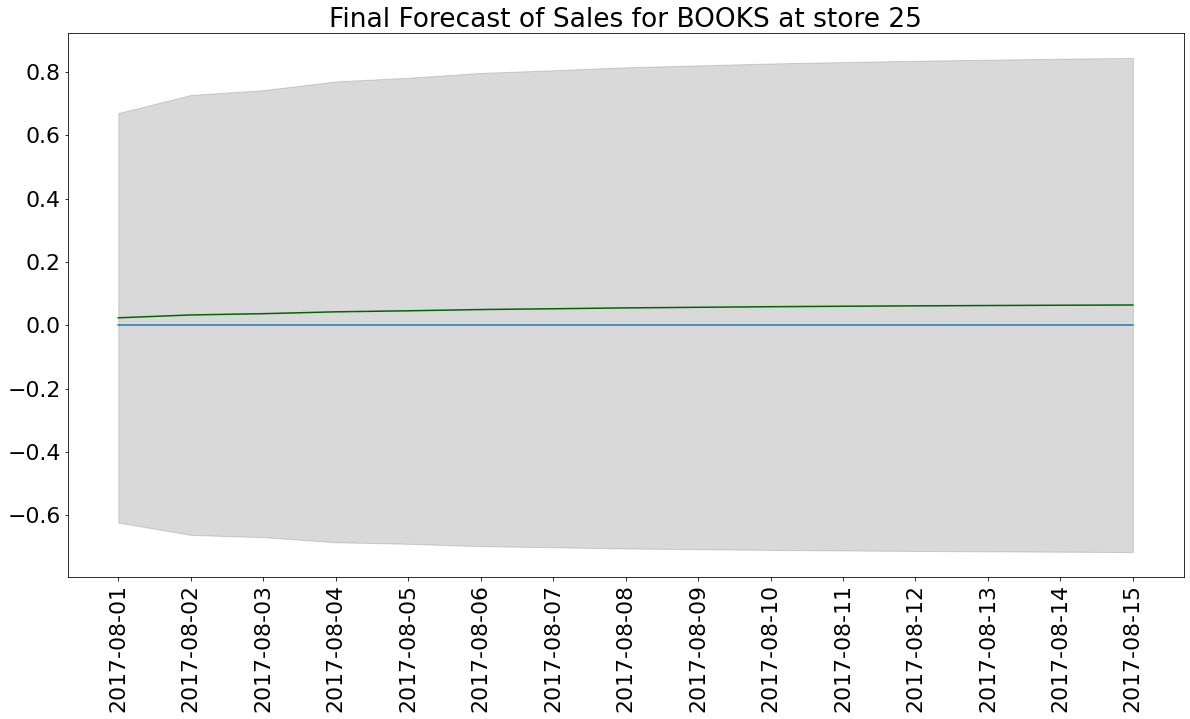

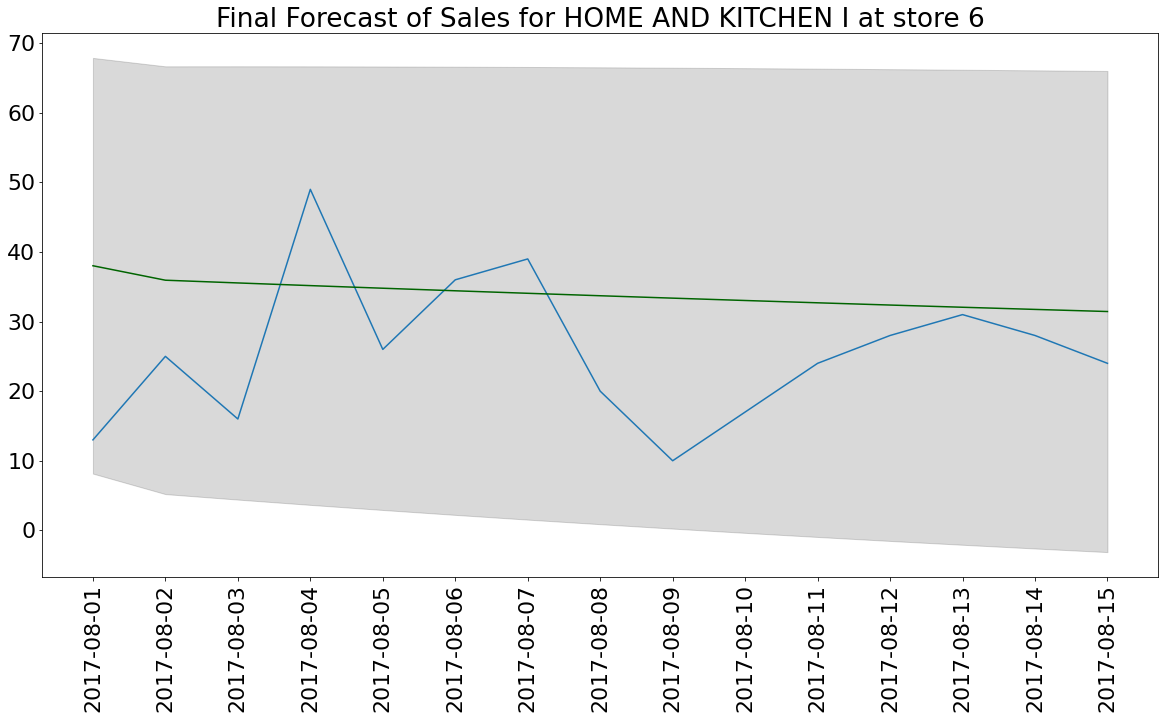

In [69]:
for i in values:
    # if time series is non-stationary, then use first order differencing
    if i in non_stationary_list:
        d_0 = 1
    else:
        d_0 = 0
    # Slice each time series 
    selected_store = combination_update.iloc[i].store_nbr
    selected_family = combination_update.iloc[i].family
    sample_train = train_df.loc[(train_df['store_nbr']==selected_store) & (train_df['family']==selected_family)]
    sample_test = test_df.loc[(test_df['store_nbr']==selected_store) & (test_df['family']==selected_family)]
    sample_train.index=sample_train.date
    sample_test.index=sample_test.date
    sample_train = sample_train['sales']
    sample_test = sample_test['sales']
    # Build Auto Arima Model
    model = pm.auto_arima(sample_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=d_0,           # pre-determined to speed the computation
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    # Forecast
    n_periods = 15
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = sample_test.index

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 22})
    plt.xticks(rotation = 90)
    plt.plot(sample_test)
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

    plt.title("Final Forecast of Sales for %s at store %s" % (selected_family, selected_store))
    plt.show()

# Summary



* This project shows us how to apply and scale AUTO ARIMA model on thousands time series forecasting, and at the same time, it 
shows how to speed model training and forecasting by pre-computing d with Augmented Dickey-Fuller test and         statsmodels.tsa.statespace.tools.diff (alternative - pmdarima.arima.ndiffs() or pmdarima.arima.nsdiffs()).
*  AUTO ARIMA model works very well on some time series forecasting but not on others, which is reasonable and under expectation.
*  Here are some future works that we can use to improve forecasting accuracy:

      1. The AUTO ARIMA model in this project didn't put seasonal factors into consideration. So we can set the
         seasonal paramter of the AUTO ARIMA MODEL (seasonal) to True. However, how to choose seasonal parameter -          sometimes requires domain knowledge.
      2. Except the sales data, additional data source, such as oil price and holiday events, are provided. We can          use them as exogenous features with AUTO ARIMA model to improve the forecasting accuracy.
      3. Except the data soruce provided by the host, we can also look for outsourcing data, such as weather data 
         to improve model accuracy
      4. Even though some researches show that tradtional statistical methods out-perform machine learning methods.
         However, it is nice try when traditional techniques doesn't work.
* Finally, here is the link for this Kaggle competition, where you can download data and find other important information there(https://www.kaggle.com/competitions/store-sales-time-series-forecasting)